In [1]:
# Cell 1: Imports and device
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

import torch
import torch.nn as nn

# Optional: choose device if GPU available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [2]:
# Cell 2: SegNet definition with similar depth and bottleneck size as U-Net
class SegNet(nn.Module):
    def __init__(self, in_channels=4, out_classes=1):
        super(SegNet, self).__init__()
        
        # Encoder (similar depth to U-Net)
        self.enc1 = self._make_encoder_block(in_channels, 64, 2)
        self.enc2 = self._make_encoder_block(64, 128, 2)
        self.enc3 = self._make_encoder_block(128, 256, 2)
        self.enc4 = self._make_encoder_block(256, 512, 2)
        self.enc5 = self._make_encoder_block(512, 1024, 2)  # Bottleneck with 1024 channels
        
        # Decoder (mirror encoder)
        self.dec5 = self._make_decoder_block(1024, 512, 2)
        self.dec4 = self._make_decoder_block(512, 256, 2)
        self.dec3 = self._make_decoder_block(256, 128, 2)
        self.dec2 = self._make_decoder_block(128, 64, 2)
        self.dec1 = self._make_decoder_block(64, out_classes, 2, final_layer=True)
        
    def _make_encoder_block(self, in_channels, out_channels, num_convs):
        layers = []
        for i in range(num_convs):
            layers.append(nn.Conv2d(in_channels if i == 0 else out_channels, 
                                   out_channels, kernel_size=3, padding=1))
            layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.ReLU(inplace=True))
        layers.append(nn.MaxPool2d(2, 2, return_indices=True))
        return nn.Sequential(*layers)
    
    def _make_decoder_block(self, in_channels, out_channels, num_convs, final_layer=False):
        layers = [nn.MaxUnpool2d(2, 2)]
        for i in range(num_convs):
            conv_in = in_channels if i == 0 else out_channels
            # For final layer, use Conv2d without BN/ReLU
            if final_layer and i == num_convs - 1:
                layers.append(nn.Conv2d(conv_in, out_channels, kernel_size=3, padding=1))
            else:
                layers.append(nn.Conv2d(conv_in, out_channels, kernel_size=3, padding=1))
                layers.append(nn.BatchNorm2d(out_channels))
                layers.append(nn.ReLU(inplace=True))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        # Store indices for unpooling
        sizes = []
        indices = []
        
        # Encoder forward with pooling indices storage
        def enc_forward(enc, x):
            for layer in enc:
                if isinstance(layer, nn.MaxPool2d):
                    sizes.append(x.size())
                    x, idx = layer(x)
                    indices.append(idx)
                else:
                    x = layer(x)
            return x
        
        x = enc_forward(self.enc1, x)
        x = enc_forward(self.enc2, x)
        x = enc_forward(self.enc3, x)
        x = enc_forward(self.enc4, x)
        x = enc_forward(self.enc5, x)  # Bottleneck features
        
        # Decoder forward with unpooling using stored indices
        def dec_forward(dec, x, idx, size):
            for layer in dec:
                if isinstance(layer, nn.MaxUnpool2d):
                    x = layer(x, indices[idx], output_size=sizes[size])
                else:
                    x = layer(x)
            return x
        
        x = dec_forward(self.dec5, x, -1, -1)  # Last in, first out
        x = dec_forward(self.dec4, x, -2, -2)
        x = dec_forward(self.dec3, x, -3, -3)
        x = dec_forward(self.dec2, x, -4, -4)
        x = dec_forward(self.dec1, x, -5, -5)
            
        return x


In [3]:
# Cell 3: Directory path and load functions

brats_dir = "/home/hiranmoy/Downloads/Sameer/Brats/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"

def load_brain(patient_dir):
    """
    Load 4 modalities for a given patient into NumPy array shape (4, H, W, D).
    patient_dir: full path to folder, e.g. ".../BraTS20_Training_001"
    """
    base = os.path.basename(patient_dir)
    modalities = ['flair', 't1', 't1ce', 't2']
    imgs = []
    for m in modalities:
        path = os.path.join(patient_dir, f"{base}_{m}.nii")
        if not os.path.isfile(path):
            raise FileNotFoundError(f"Missing file: {path}")
        arr = nib.load(path).get_fdata()
        imgs.append(arr)
    stacked = np.stack(imgs, axis=0)  # (4, H, W, D)
    return stacked

def load_mask(patient_dir):
    """
    Load segmentation mask for a given patient as NumPy array (H, W, D).
    """
    base = os.path.basename(patient_dir)
    mask_path = os.path.join(patient_dir, f"{base}_seg.nii")
    if not os.path.isfile(mask_path):
        raise FileNotFoundError(f"Missing seg file: {mask_path}")
    mask = nib.load(mask_path).get_fdata()
    return mask  # (H, W, D)


In [4]:
# Cell 4: List patient folders and choose one
all_patients = sorted([
    os.path.join(brats_dir, d)
    for d in os.listdir(brats_dir)
    if os.path.isdir(os.path.join(brats_dir, d)) and d.startswith("BraTS20_Training")
])
print(f"Found {len(all_patients)} patients. Example:", all_patients[:3])

# Choose one patient for experiment
patient_dir = all_patients[0]
# This is for patient index 0 , i.e patient 1 
print("Using patient:", patient_dir)


Found 369 patients. Example: ['/home/hiranmoy/Downloads/Sameer/Brats/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001', '/home/hiranmoy/Downloads/Sameer/Brats/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_002', '/home/hiranmoy/Downloads/Sameer/Brats/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_003']
Using patient: /home/hiranmoy/Downloads/Sameer/Brats/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001


In [5]:
# Cell 5: Load image modalities and mask, inspect shapes
image = load_brain(patient_dir)  # (4, H, W, D)
mask = load_mask(patient_dir)    # (H, W, D)
print("image.shape:", image.shape)  # e.g., (4,240,240,155)
print("image:", image.shape)  # e.g., (4,240,240,155)
print("mask.shape: ", mask.shape)   # e.g., (240,240,155)

# Optionally: print modality stats
for i, mod in enumerate(['flair','t1','t1ce','t2']):
    arr = image[i]
    print(f"{mod}: min {arr.min():.1f}, max {arr.max():.1f}, mean {arr.mean():.1f}, std {arr.std():.1f}")


image.shape: (4, 240, 240, 155)
image: (4, 240, 240, 155)
mask.shape:  (240, 240, 155)
flair: min 0.0, max 625.0, mean 26.0, std 66.8
t1: min 0.0, max 678.0, mean 53.3, std 130.8
t1ce: min 0.0, max 1845.0, mean 62.8, std 155.1
t2: min 0.0, max 376.0, mean 17.3, std 45.0


In [6]:
# Cell 6: Select slice index (center) and form input tensor [1,4,H,W]

depth = image.shape[-1]
center_idx = depth // 2
print("Total slices:", depth, "Using center index:", center_idx)

# Extract center slice: shape (4, H, W)
center_slice = image[..., center_idx]
print("center_slice.shape:", center_slice.shape)

# (Optional) Normalize each modality slice (z-score)
center_norm = np.zeros_like(center_slice, dtype=np.float32)
for i in range(4):
    arr = center_slice[i]
    mu, sd = arr.mean(), arr.std()
    if sd > 0:
        center_norm[i] = (arr - mu) / sd
    else:
        center_norm[i] = arr
# Convert to tensor [1,4,H,W]
input_tensor = torch.from_numpy(center_norm).float().unsqueeze(0).to(device)
print("input_tensor.shape:", input_tensor.shape)  # expect [1,4,240,240]


Total slices: 155 Using center index: 77
center_slice.shape: (4, 240, 240)
input_tensor.shape: torch.Size([1, 4, 240, 240])


Bottleneck feature shape: torch.Size([1, 1024, 15, 15])


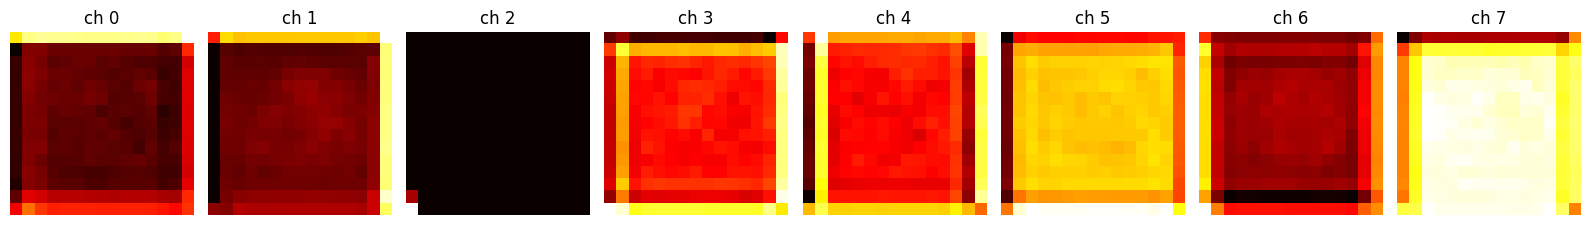

In [7]:
# Cell 7: Instantiate SegNet, register forward hook at bottleneck
model = SegNet(in_channels=4, out_classes=1).to(device)
model.eval()

# We'll extract features from the bottleneck (enc5 output before pooling)
bottleneck_activations = []

def hook_fn(module, inp, outp):
    # We want the output before pooling
    # outp is the output from the last conv layer in the block
    bottleneck_activations.append(outp.detach().cpu())

# Register hook on the last conv layer of enc5
# We need to find the last conv layer in enc5
last_conv_index = -2  # Last layer is MaxPool, so -2 is the last conv
handle = model.enc5[last_conv_index].register_forward_hook(hook_fn)

# Forward pass
with torch.no_grad():
    output = model(input_tensor)  # [1,1,240,240]

# Remove hook
handle.remove()

if not bottleneck_activations:
    raise RuntimeError("Bottleneck hook did not capture any activation.")
    
bottleneck_feat = bottleneck_activations[0]  # [1,1024,h,w] (h,w reduced by factor of 16)
print("Bottleneck feature shape:", bottleneck_feat.shape)



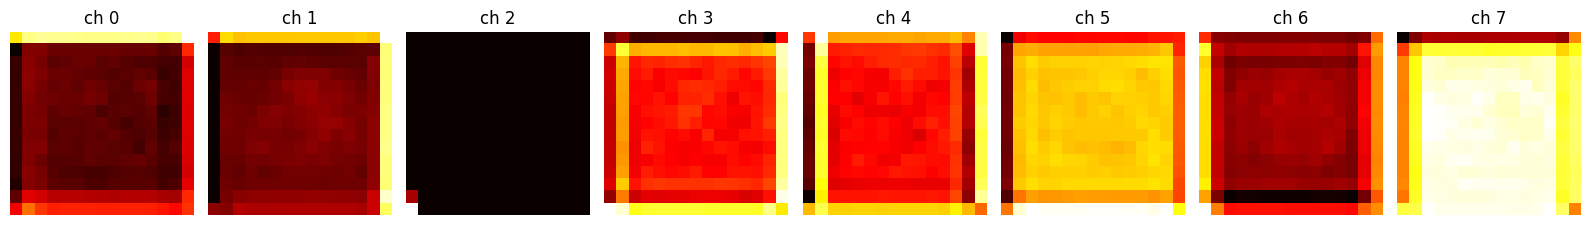

In [8]:
# Cell 8: Visualize first N channels in bottleneck (same as before)
def visualize_features(tensor4d, num_features):
    B, C, h, w = tensor4d.shape
    num = min(num_features, C)
    fig, axes = plt.subplots(1, num, figsize=(16, 16))
    for i in range(num):
        fmap = tensor4d[0, i].numpy()
        axes[i].imshow(fmap, cmap='hot')
        axes[i].set_title(f"ch {i}")
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()
    fig.savefig("expt1_segnet")

visualize_features(bottleneck_feat, num_features=8)

Feature matrix for PCA: (1024, 225)


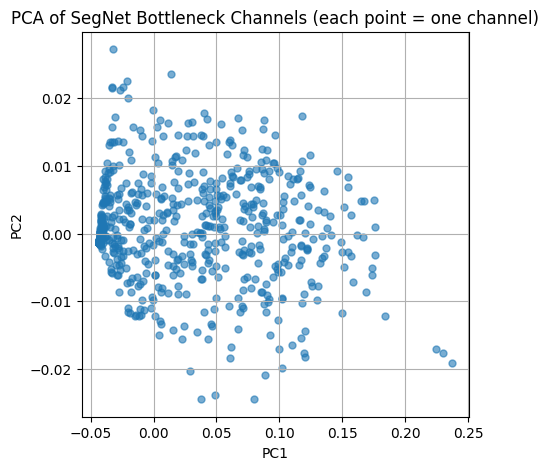

Explained variance ratios (first 2 PCs): [0.9649686  0.01077153]


In [9]:
# Cell 9: PCA on SegNet bottleneck channels
B, C, h, w = bottleneck_feat.shape
feat_mat = bottleneck_feat[0].view(C, -1).numpy()  # shape (C, h*w)
print("Feature matrix for PCA:", feat_mat.shape)

pca = PCA(n_components=2)
pca_res = pca.fit_transform(feat_mat)  # (C,2)

plt.figure(figsize=(5,5))
plt.scatter(pca_res[:,0], pca_res[:,1], s=25, alpha=0.6)
plt.title("PCA of SegNet Bottleneck Channels (each point = one channel)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()
print("Explained variance ratios (first 2 PCs):", pca.explained_variance_ratio_[:2])

SegNet Bottleneck feature shape: torch.Size([1, 1024, 15, 15])  (C=1024, h*w=15x15=225)
Correlation matrix computed.
=== SegNet Channel-Channel Correlation Summary ===
Mean correlation      : 0.0031
Median correlation    : -0.0159
Std deviation         : 0.4255
Min correlation       : -0.9899
Max correlation       : 1.0000
Percentiles (1,5,25,50,75,95,99): [-0.85077606 -0.69787595 -0.29813847 -0.01588438  0.30766774  0.72725195
  0.87332827]


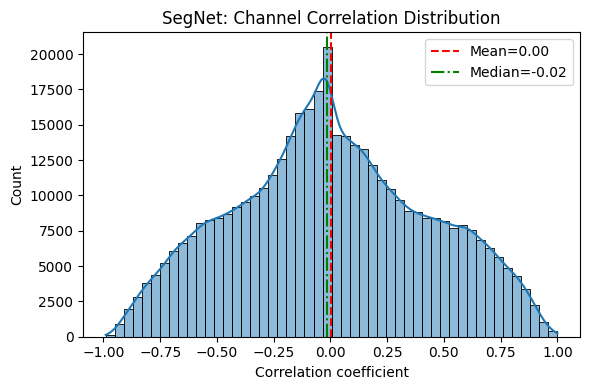

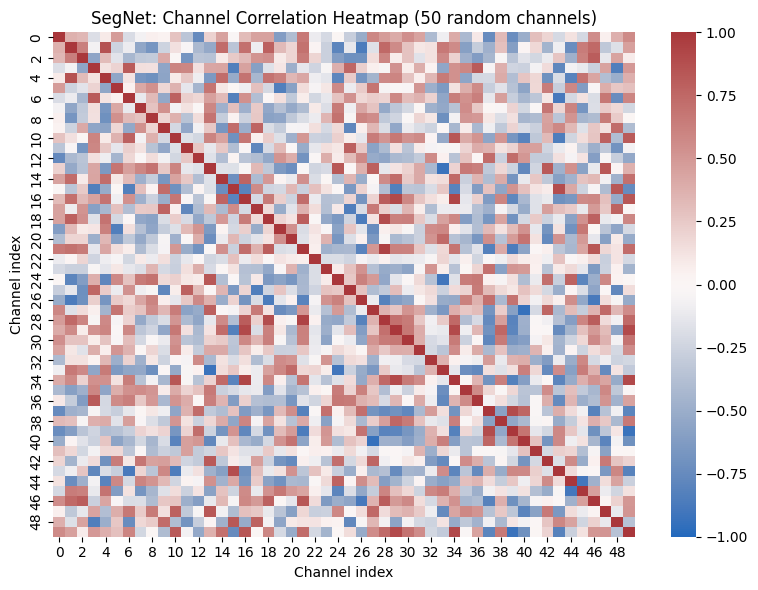

Strongly +corr pairs (> 0.8): 11466
Strongly -corr pairs (< -0.8): 8600


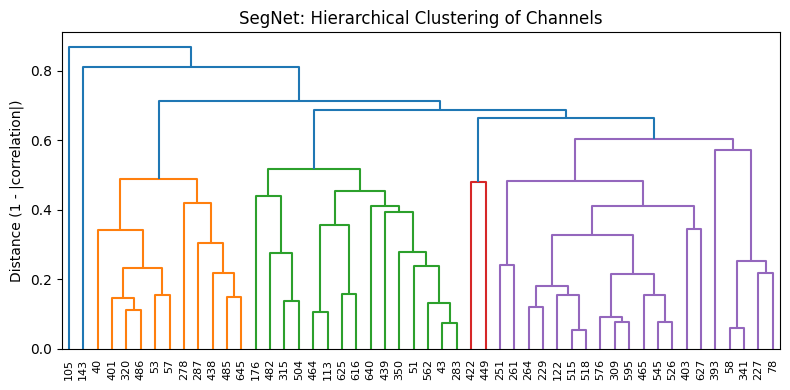

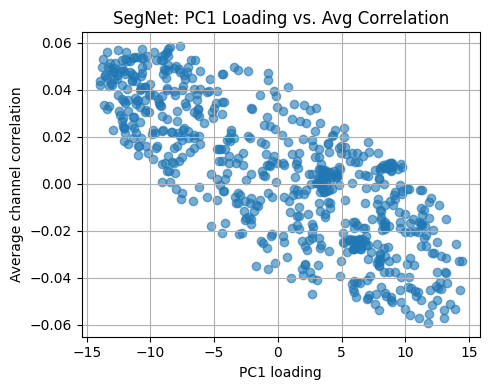

=== SegNet Channel Analysis Complete ===


In [12]:
# Cell 9: PCA on SegNet bottleneck channels (unchanged)

# Enhanced Channel Correlation Analysis for SegNet - FIXED
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assume bottleneck_feat is a CPU tensor of shape [1, C, h, w]
tensor_cpu = bottleneck_feat.detach().cpu()  # ensure on CPU
B, C, h, w = tensor_cpu.shape
print(f"SegNet Bottleneck feature shape: {tensor_cpu.shape}  (C={C}, h*w={h}x{w}={h*w})")

# 1. Flatten channels to shape (C, h*w)
feat = tensor_cpu[0].view(C, -1).numpy()  # shape (C, h*w)

# 2. Identify and remove constant channels (zero variance)
#    These cause division by zero in normalization
valid_mask = np.std(feat, axis=1) > 1e-6
valid_indices = np.where(valid_mask)[0]
invalid_count = C - len(valid_indices)

if invalid_count > 0:
    print(f"Warning: Found {invalid_count} constant channels (zero variance). Removing them.")
    feat = feat[valid_indices]
    C_valid = len(valid_indices)
else:
    C_valid = C

# 3. Normalize each channel vector (zero-mean, unit-std)
feat_mean = feat.mean(axis=1, keepdims=True)  # shape (C_valid,1)
feat_std = feat.std(axis=1, keepdims=True)    # shape (C_valid,1)
feat_norm = (feat - feat_mean) / (feat_std + 1e-6)

# 4. Compute correlation matrix among channels: shape (C_valid, C_valid)
corr = np.corrcoef(feat_norm)  # shape (C_valid, C_valid)
print("Correlation matrix computed.")

# 5. Exclude diagonal entries (self-correlation = 1) for statistics
mask = ~np.eye(C_valid, dtype=bool)
corr_offdiag = corr[mask]  # length C_valid*(C_valid-1)

# 6. Descriptive statistics
mean_corr = np.mean(corr_offdiag)
median_corr = np.median(corr_offdiag)
std_corr = np.std(corr_offdiag)
min_corr = np.min(corr_offdiag)
max_corr = np.max(corr_offdiag)
percentiles = np.percentile(corr_offdiag, [1, 5, 25, 50, 75, 95, 99])

print("=== SegNet Channel-Channel Correlation Summary ===")
print(f"Mean correlation      : {mean_corr:.4f}")
print(f"Median correlation    : {median_corr:.4f}")
print(f"Std deviation         : {std_corr:.4f}")
print(f"Min correlation       : {min_corr:.4f}")
print(f"Max correlation       : {max_corr:.4f}")
print(f"Percentiles (1,5,25,50,75,95,99): {percentiles}")

# 7. Histogram of off-diagonal correlations
plt.figure(figsize=(6,4))
sns.histplot(corr_offdiag, bins=50, kde=True)
plt.title("SegNet: Channel Correlation Distribution")
plt.xlabel("Correlation coefficient")
plt.ylabel("Count")
plt.axvline(mean_corr, color='r', linestyle='--', label=f"Mean={mean_corr:.2f}")
plt.axvline(median_corr, color='g', linestyle='-.', label=f"Median={median_corr:.2f}")
plt.legend()
plt.tight_layout()
plt.show()

# 8. Heatmap of a subset of channels
subset_size = min(50, C_valid)  # Ensure subset size is valid
rng = np.random.default_rng(seed=42)
subset_idx = rng.choice(C_valid, size=subset_size, replace=False)
corr_subset = corr[np.ix_(subset_idx, subset_idx)]

plt.figure(figsize=(8, 6))
sns.heatmap(corr_subset, vmin=-1, vmax=1, cmap='vlag', center=0)
plt.title(f"SegNet: Channel Correlation Heatmap ({subset_size} random channels)")
plt.xlabel("Channel index")
plt.ylabel("Channel index")
plt.tight_layout()
plt.show()

# 9. Identify strongly correlated or anti-correlated pairs
threshold_high = 0.8
threshold_low = -0.8
strong_pos_pairs = np.argwhere((corr > threshold_high) & (mask))
strong_neg_pairs = np.argwhere((corr < threshold_low) & (mask))
print(f"Strongly +corr pairs (> {threshold_high}): {len(strong_pos_pairs)}")
print(f"Strongly -corr pairs (< {threshold_low}): {len(strong_neg_pairs)}")

# 10. Channel clustering
import scipy.cluster.hierarchy as sch

# Compute distance as 1 - absolute correlation for subset
dist_subset = 1 - np.abs(corr_subset)

# Create condensed distance matrix (upper triangle as vector)
condensed_dist = dist_subset[np.triu_indices_from(dist_subset, k=1)]

# Hierarchical clustering
linkage = sch.linkage(condensed_dist, method='average')
plt.figure(figsize=(8, 4))
dn = sch.dendrogram(linkage, labels=[str(i) for i in subset_idx], leaf_rotation=90)
plt.title("SegNet: Hierarchical Clustering of Channels")
plt.ylabel("Distance (1 - |correlation|)")
plt.tight_layout()
plt.savefig("Hierarch_Clustering_of_feature.png")
plt.show()

# 11. Correlation vs. PCA loadings
pca = PCA(n_components=2)
pca_res = pca.fit_transform(feat_norm)  # shape (C_valid,2)
pc1_scores = pca_res[:, 0]  # projection of each channel onto PC1
avg_corr_per_channel = corr.mean(axis=1)

plt.figure(figsize=(5,4))
plt.scatter(pc1_scores, avg_corr_per_channel, alpha=0.6)
plt.xlabel("PC1 loading")
plt.ylabel("Average channel correlation")
plt.title("SegNet: PC1 Loading vs. Avg Correlation")
plt.grid(True)
plt.tight_layout()
plt.show()

# 12. Summary
print("=== SegNet Channel Analysis Complete ===")

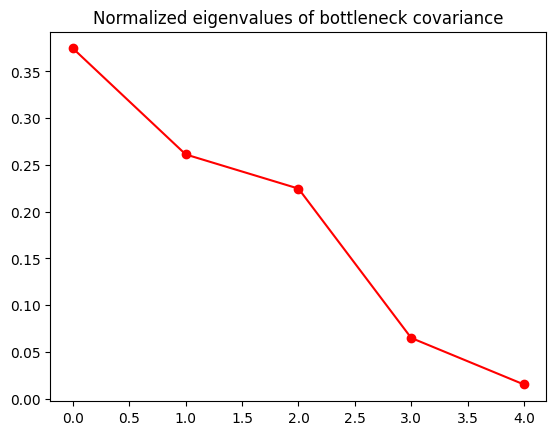

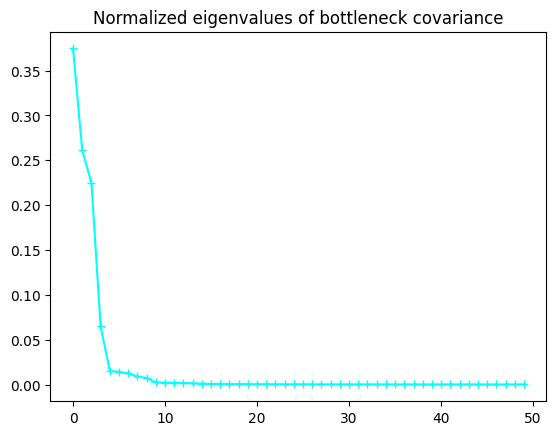

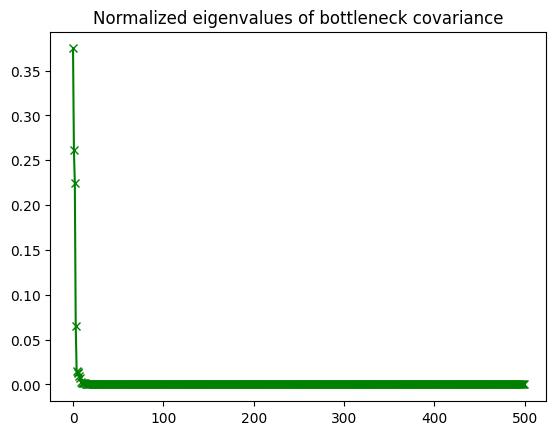

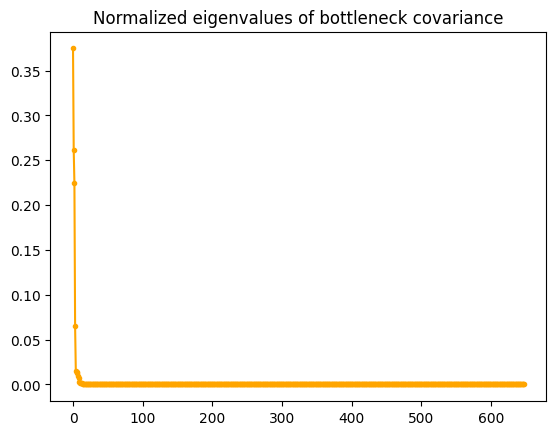

In [14]:
# Eigen Spectrum
from numpy.linalg import eigh
cov = np.cov(feat)  # shape (1024,1024)
vals, _ = eigh(cov)
vals_sorted = np.sort(vals)[::-1]
plt.plot(vals_sorted[:5]/vals_sorted.sum(), marker='o', c = 'red')
plt.title("Normalized eigenvalues of bottleneck covariance")
plt.savefig("Normalized_EV_of_Bottleneck_CoV_5.png")
plt.show()
plt.plot(vals_sorted[:50]/vals_sorted.sum(), marker='+', c = 'cyan')
plt.title("Normalized eigenvalues of bottleneck covariance")
plt.savefig("Normalized_EV_of_Bottleneck_CoV_50.png")
plt.show()
plt.plot(vals_sorted[:500]/vals_sorted.sum(), marker='x', c = 'green')
plt.title("Normalized eigenvalues of bottleneck covariance")
plt.savefig("Normalized_EV_of_Bottleneck_CoV_500.png")
plt.show()
plt.plot(vals_sorted[:1023]/vals_sorted.sum(), marker='.', c = 'orange')
plt.title("Normalized eigenvalues of bottleneck covariance")
plt.savefig("Normalized_EV_of_Bottleneck_CoV_1024.png")
plt.show()


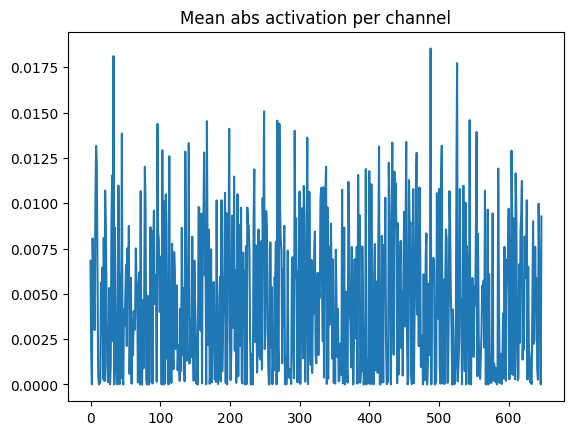

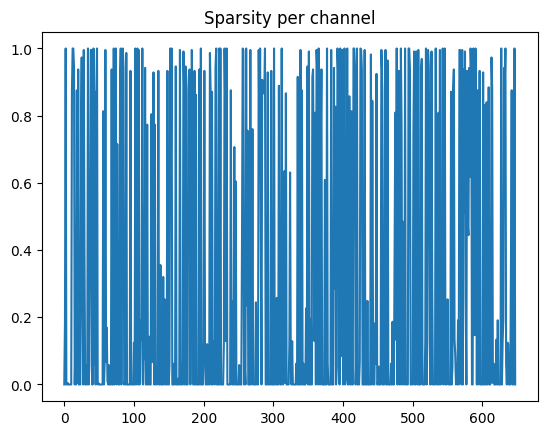

In [15]:
abs_mean = np.mean(np.abs(feat), axis=1)  # shape (C,)
sparsity = np.mean(np.isclose(feat, 0, atol=1e-3), axis=1)
plt.plot(abs_mean); plt.title("Mean abs activation per channel"); plt.show()
plt.plot(sparsity); plt.title("Sparsity per channel"); plt.show()


In [20]:
import torch
import torch.nn as nn


class DoubleConv(nn.Sequential):
    """(Conv → ReLU) × 2"""
    def __init__(self, in_channels, out_channels):
        super().__init__(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True),
        )


class EncBlock(nn.Module):
    """DoubleConv → MaxPool(return_indices=True)."""
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = DoubleConv(in_ch, out_ch)
        self.pool = nn.MaxPool2d(2, 2, return_indices=True)

    def forward(self, x):
        x = self.conv(x)
        size = x.size()
        x, idx = self.pool(x)
        return x, idx, size


class DecBlock(nn.Module):
    """MaxUnpool → DoubleConv."""
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.unpool = nn.MaxUnpool2d(2, 2)
        self.conv   = DoubleConv(in_ch, out_ch)

    def forward(self, x, idx, out_size):
        x = self.unpool(x, indices=idx, output_size=out_size)
        return self.conv(x)


class SegNetEquivalent(nn.Module):
    """
    SegNet with depth & channel widths matched to U-Net but
    bottom kept at 512 channels to align pooling indices:

      Encoder channels:    in→64→128→256→512
      (no 1024 bottleneck)
      Decoder channels:    512→256→128→64→out_classes
    """
    def __init__(self, in_channels=4, out_classes=1):
        super().__init__()
        # Encoder
        self.enc1 = EncBlock(in_channels, 64)
        self.enc2 = EncBlock(64, 128)
        self.enc3 = EncBlock(128, 256)
        self.enc4 = EncBlock(256, 512)

        # “Bottleneck” as another conv block at 512
        self.bottleneck = DoubleConv(512, 512)

        # Decoder
        self.dec3 = DecBlock(512, 256)
        self.dec2 = DecBlock(256, 128)
        self.dec1 = DecBlock(128, 64)

        # Final unpool & conv to restore full resolution
        self.final_unpool = nn.MaxUnpool2d(2, 2)
        self.final_conv   = nn.Conv2d(64, out_classes, 1)

    def forward(self, x, return_feats=False):
        # Encoder
        x, i1, s1 = self.enc1(x)  # → [B,64,H/2,W/2]
        x, i2, s2 = self.enc2(x)  # → [B,128,H/4,W/4]
        x, i3, s3 = self.enc3(x)  # → [B,256,H/8,W/8]
        x, i4, s4 = self.enc4(x)  # → [B,512,H/16,W/16]

        # Bottleneck at 512
        x = self.bottleneck(x)    # → [B,512,H/16,W/16]

        # Decoder
        u3 = self.dec3(x, i4, s4) # → [B,256,H/8,W/8]
        u2 = self.dec2(u3, i3, s3)# → [B,128,H/4,W/4]
        u1 = self.dec1(u2, i2, s2)# → [B,64,H/2,W/2]

        # Final restore
        x = self.final_unpool(u1, indices=i1, output_size=s1)  # → [B,64,H,W]
        out = self.final_conv(x)                                # → [B,out_classes,H,W]

        if return_feats:
            return out, {
                "u3": u3.detach().cpu(),
                "u2": u2.detach().cpu(),
                "u1": u1.detach().cpu(),
            }
        return out


# Comments on equivalence:
# - Encoder/Decoder depth: 4 pooling/unpooling stages + 1 bottleneck.
# - Channel widths begin at 64 and double until 512, then halve back to 64.
# - Bottleneck kept at 512 channels so each unpool’s indices match tensor channels.
# - Uses same DoubleConv blocks throughout.
# - Supports return_feats for intermediate decoder activations.


In [21]:
# Cell 7 (SegNetEquivalent): Instantiate model and capture decoder features

# 1) Instantiate SegNetEquivalent
segnet = SegNetEquivalent(in_channels=4, out_classes=1).to(device)
segnet.eval()

# Prepare input_tensor from earlier cell (shape [1,4,H,W])

# 2) Forward pass and get intermediate decoder activations
with torch.no_grad():
    out_seg, feats_seg = segnet(input_tensor, return_feats=True)

print("SegNet output shape:", out_seg.shape)
for stage, fmap in feats_seg.items():
    print(f"{stage} feature map shape: {fmap.shape}")
    # fmap is on CPU, shape [1, channels, h, w]


SegNet output shape: torch.Size([1, 1, 240, 240])
u3 feature map shape: torch.Size([1, 256, 30, 30])
u2 feature map shape: torch.Size([1, 128, 60, 60])
u1 feature map shape: torch.Size([1, 64, 120, 120])


SegNet output shape: torch.Size([1, 1, 240, 240])


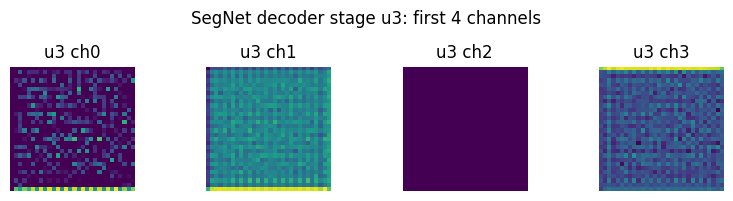

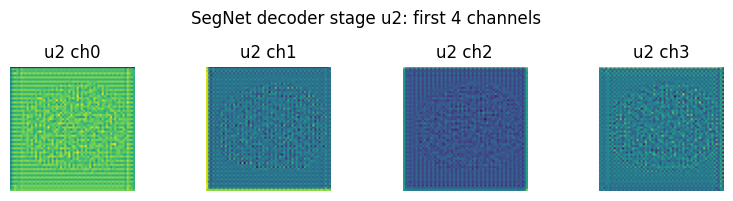

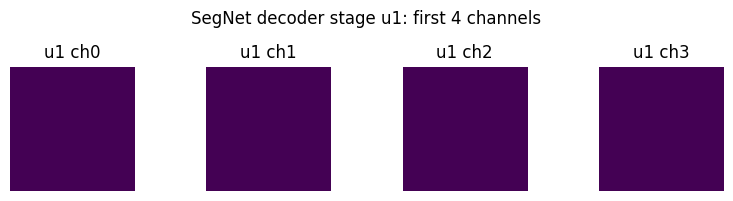

In [22]:
# Cell 8 (SegNetEquivalent): Visualize first few channels at each decoder stage

import matplotlib.pyplot as plt

def visualize_segnet_stage(stage_name, fmap, num_channels=4, cmap='viridis'):
    """
    fmap: tensor on CPU, shape [1, C, h, w]
    Display heatmaps of first num_channels channels.
    """
    _, C, h, w = fmap.shape
    n = min(num_channels, C)
    fig, axes = plt.subplots(1, n, figsize=(2*n, 2))
    for i in range(n):
        img = fmap[0, i].numpy()
        axes[i].imshow(img, cmap=cmap)
        axes[i].set_title(f"{stage_name} ch{i}")
        axes[i].axis('off')
    plt.suptitle(f"SegNet decoder stage {stage_name}: first {n} channels")
    plt.tight_layout()
    plt.show()

# 1) Forward pass to get decoder features
segnet = SegNetEquivalent(in_channels=4, out_classes=1).to(device)
segnet.eval()
with torch.no_grad():
    out_seg, feats_seg = segnet(input_tensor, return_feats=True)

print("SegNet output shape:", out_seg.shape)
# 2) Visualize each decoder stage
for stage in ['u3', 'u2', 'u1']:
    fmap = feats_seg[stage]
    visualize_segnet_stage(stage, fmap, num_channels=4)

# --------------------------------------------------------------
# Comments:
# - This cell runs the SegNetEquivalent model in evaluation mode,
#   capturing intermediate decoder activations at three spatial levels.
# - The visualize_segnet_stage function displays the first few channels
#   of each feature map, revealing how SegNet’s decoder reconstructs spatial detail.
# - These visualizations help compare SegNet’s upsampling via max-unpooling
#   against U‑Net’s concatenative skips, illustrating SegNet’s ability to
#   preserve localization using pooling indices.
# --------------------------------------------------------------


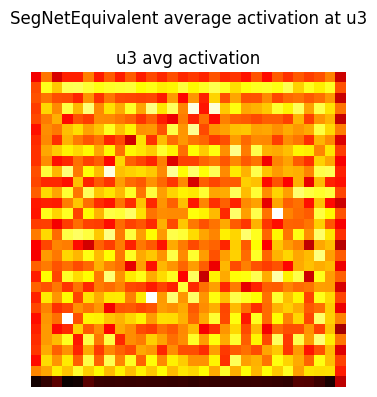

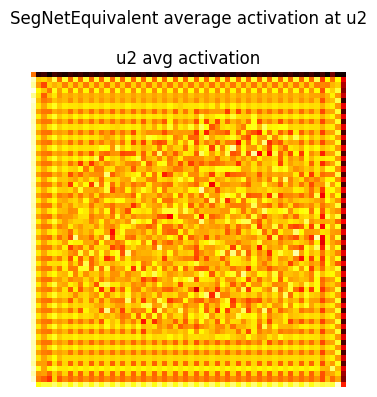

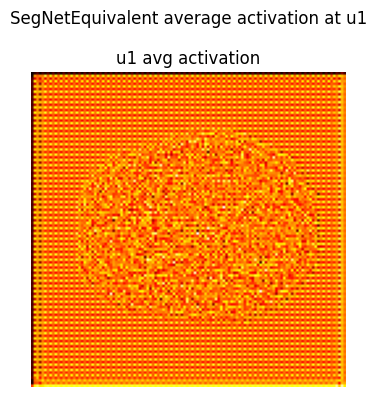

In [23]:
# Cell 8b (SegNetEquivalent): Visualize average activation over channels

import matplotlib.pyplot as plt

for stage in ['u3', 'u2', 'u1']:
    # feats_seg was obtained from segnet(input_tensor, return_feats=True)
    fmap = feats_seg[stage][0]         # [C, h, w]
    avg_map = fmap.mean(dim=0).numpy() # [h, w]

    fig, axs = plt.subplots(1, 1, figsize=(4, 4))
    axs.imshow(avg_map, cmap='hot')
    axs.set_title(f"{stage} avg activation")
    axs.axis('off')
    plt.suptitle(f"SegNetEquivalent average activation at {stage}")
    plt.tight_layout()
    plt.show()

# --------------------------------------------------------------
# Comments:
# - This cell computes the spatial average of all channels at each decoder stage (u3, u2, u1).
# - The heatmaps reveal where SegNetEquivalent places most of its activation energy,
#   showing how the pooling‑indices‐based decoder reconstructs high‑level features.
# - Comparing these maps across stages helps assess how well each upsampling step
#   recovers spatial information without concatenative skip connections.
# --------------------------------------------------------------


In [26]:
# Cell 9 (SegNet: indices vs. simple upsample): Quantify L1 difference between decoding with vs. without pooling indices

import torch
import torch.nn as nn

# Define a DecBlock that upsamples instead of unpooling
class DecBlockNoIdx(nn.Module):
    """Nearest‑neighbor upsample + DoubleConv, matching in/out channels."""
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode='nearest')
        self.conv = DoubleConv(in_ch, out_ch)

    def forward(self, x, *_):
        # ignore idx and out_size, just upsample spatially
        x = self.up(x)
        return self.conv(x)

# Create a SegNet variant without using pooling indices
class SegNetNoIndices(SegNetEquivalent):
    def __init__(self, in_channels=4, out_classes=1):
        super().__init__(in_channels, out_classes)
        # Replace decoder blocks
        self.dec3 = DecBlockNoIdx(512, 256)
        self.dec2 = DecBlockNoIdx(256, 128)
        self.dec1 = DecBlockNoIdx(128, 64)
        # Replace final unpool with upsample
        self.final_unpool = nn.Upsample(scale_factor=2, mode='nearest')
        # final_conv already matches 64→out_classes from SegNetEquivalent

    def forward(self, x, return_feats=False):
        # Encoder path (same as base)
        x, i1, s1 = self.enc1(x)
        x, i2, s2 = self.enc2(x)
        x, i3, s3 = self.enc3(x)
        x, i4, s4 = self.enc4(x)
        # Bottleneck (512→512)
        x = self.bottleneck(x)
        # Decoder path without indices
        u3 = self.dec3(x, None, None)
        u2 = self.dec2(u3, None, None)
        u1 = self.dec1(u2, None, None)
        # Final upsample + conv
        x = self.final_unpool(u1)
        out = self.final_conv(x)
        if return_feats:
            return out, {
                "u3": u3.detach().cpu(),
                "u2": u2.detach().cpu(),
                "u1": u1.detach().cpu(),
            }
        return out

# Instantiate both models
segnet_idx   = SegNetEquivalent(in_channels=4, out_classes=1).to(device).eval()
segnet_noidx = SegNetNoIndices(in_channels=4, out_classes=1).to(device).eval()

# Forward pass to capture features
with torch.no_grad():
    _, feats_idx   = segnet_idx(input_tensor,   return_feats=True)
    _, feats_noidx = segnet_noidx(input_tensor, return_feats=True)

# Compute and print L1 differences per stage
for stage in ['u3','u2','u1']:
    fi = feats_idx[stage][0]    # [C, h, w]
    fn = feats_noidx[stage][0]  # [C, h, w]
    vi = fi.view(fi.shape[0], -1)
    vn = fn.view(fn.shape[0], -1)
    l1 = torch.mean(torch.abs(vi - vn), dim=1).cpu().numpy()
    print(f"{stage}: L1 diff per channel → mean={l1.mean():.4f}, std={l1.std():.4f}, max={l1.max():.4f}")

# --------------------------------------------------------------
# Comments:
# - SegNetEquivalent uses stored pooling indices to guide unpooling,
#   whereas SegNetNoIndices simply upsamples by nearest‑neighbor.
# - This cell measures the mean absolute difference (L1) of decoder
#   feature maps at each stage (u3, u2, u1) between the two variants.
# - High L1 values indicate stages where pooling‑indices unpooling
#   deviates most from naive upsampling, quantifying the benefit of
#   preserving “where” information from encoder pooling operations.
# --------------------------------------------------------------


u3: L1 diff per channel → mean=0.0079, std=0.0069, max=0.0268
u2: L1 diff per channel → mean=0.0119, std=0.0105, max=0.0380
u1: L1 diff per channel → mean=0.0166, std=0.0128, max=0.0478


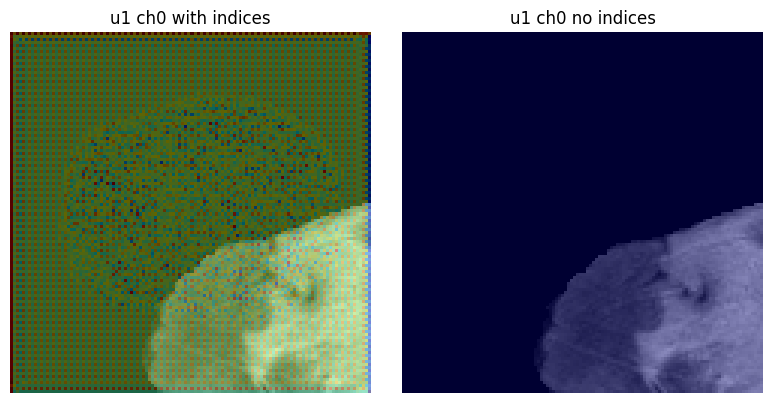

In [27]:
# Cell 10 (SegNetEquivalent): Overlay example for stage u1 channel 0 on input slice

import numpy as np
import matplotlib.pyplot as plt

ch_idx = 0
# input_np: from Cell 6, center_norm[0] is the normalized FLAIR slice [H, W]
input_np = center_norm[0]

# With pooling indices
fmap_idx = feats_idx['u1'][0, ch_idx].numpy()    # [H, W]
# Without pooling indices (naive upsample)
fmap_noidx = feats_noidx['u1'][0, ch_idx].numpy()

# Normalize feature maps to [0,1]
def normalize_map(m):
    mmin, mmax = m.min(), m.max()
    if mmax - mmin > 1e-6:
        return (m - mmin) / (mmax - mmin)
    return np.zeros_like(m)

f_idx_norm = normalize_map(fmap_idx)
f_noidx_norm = normalize_map(fmap_noidx)

# Plot overlays
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
# With indices overlay
axs[0].imshow(input_np, cmap='gray')
axs[0].imshow(f_idx_norm, cmap='jet', alpha=0.4)
axs[0].set_title(f"u1 ch{ch_idx} with indices")
axs[0].axis('off')
# Without indices overlay
axs[1].imshow(input_np, cmap='gray')
axs[1].imshow(f_noidx_norm, cmap='jet', alpha=0.4)
axs[1].set_title(f"u1 ch{ch_idx} no indices")
axs[1].axis('off')
plt.tight_layout()
plt.show()

# --------------------------------------------------------------
# Comments:
# - This cell overlays the normalized decoder activation (channel 0 of u1)
#   onto the original FLAIR slice to visualize spatial alignment.
# - The left plot uses pooling indices for unpooling (SegNetEquivalent),
#   the right uses simple upsampling (SegNetNoIndices).
# - Comparing overlays demonstrates how pooling indices preserve precise
#   feature locations, whereas naive upsampling produces less accurate alignment.
# --------------------------------------------------------------


[DebugCell] Starting SegNet bottleneck debug cell
 • segnet object: SegNetEquivalent(
  (enc1): EncBlock(
    (conv): DoubleConv(
      (0): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (enc2): EncBlock(
    (conv): DoubleConv(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (enc3): EncBlock(
    (conv): DoubleConv(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(256, 256, kernel_size=(3, 3), s

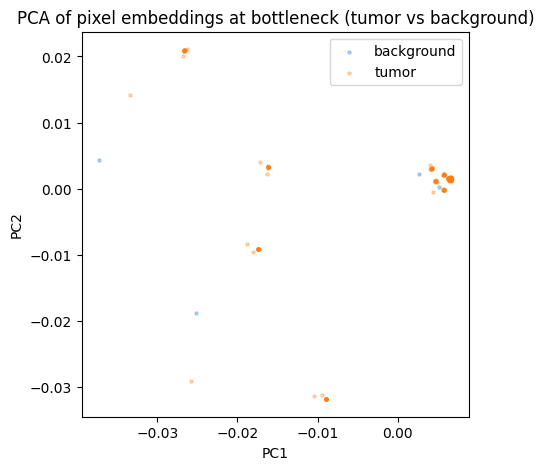

[Debug] LR accuracy: 0.221, chance: 0.93
[DebugCell] Completed successfully.
 • feat shape: (225, 512)
 • labels shape: (225,)
 • acc: 0.22058823529411764


In [38]:
# Cell X: Complete debug analysis for SegNet bottleneck

import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

print("[DebugCell] Starting SegNet bottleneck debug cell")
print(" • segnet object:", segnet)
print(" • input_tensor shape:", getattr(input_tensor, "shape", None))
print(" • mask shape:", getattr(mask, "shape", None))
print(" • center_idx:", center_idx)

def analyze_segnet_bottleneck_debug(segnet, input_tensor, mask, center_idx=None, do_tsne=False):
    print("[Debug] Entered analyze_segnet_bottleneck_debug")
    # 1) Extract bottleneck features
    segnet.eval()
    with torch.no_grad():
        x = input_tensor.to(next(segnet.parameters()).device)
        x, i1, s1 = segnet.enc1(x)
        x, i2, s2 = segnet.enc2(x)
        x, i3, s3 = segnet.enc3(x)
        x, i4, s4 = segnet.enc4(x)
        bottleneck = segnet.bottleneck(x)  # [1, Cb, hb, wb]
    print(f"[Debug] Bottleneck shape: {bottleneck.shape}")

    # 2) Prepare 2D mask slice
    print(f"[Debug] Original mask ndim: {mask.ndim}")
    if mask.ndim == 2:
        mask2d = mask
        print("[Debug] Using 2D mask directly")
    elif mask.ndim == 3:
        if center_idx is None:
            raise ValueError("center_idx must be provided for 3D mask")
        if center_idx < mask.shape[0]:
            mask2d = mask[center_idx]    # (H,W) if (D,H,W)
            print("[Debug] Sliced mask as mask[D,H,W]")
        elif center_idx < mask.shape[-1]:
            mask2d = mask[..., center_idx]  # (H,W) if (H,W,D)
            print("[Debug] Sliced mask as mask[H,W,D]")
        else:
            raise ValueError(f"center_idx {center_idx} out of bounds for mask shape {mask.shape}")
    else:
        raise ValueError(f"Unsupported mask ndim={mask.ndim}")
    H, W = mask2d.shape
    print(f"[Debug] mask2d shape: {(H,W)}")

    # 3) Downsample or interpolate mask to (hb, wb)
    _, Cb, hb, wb = bottleneck.shape
    if H % hb == 0 and W % wb == 0:
        print("[Debug] Block pooling mask down")
        fh, fw = H//hb, W//wb
        mask_down = np.zeros((hb, wb), dtype=np.uint8)
        for i in range(hb):
            for j in range(wb):
                block = mask2d[i*fh:(i+1)*fh, j*fw:(j+1)*fw]
                mask_down[i,j] = 1 if (block>0).any() else 0
    else:
        print("[Debug] Interpolating mask down")
        t = torch.from_numpy((mask2d>0).astype(np.float32))[None,None]
        t2 = F.interpolate(t, size=(hb, wb), mode='nearest')
        mask_down = (t2[0,0].cpu().numpy()>0).astype(np.uint8)
    print(f"[Debug] mask_down shape: {mask_down.shape}, tumor_frac: {mask_down.mean():.3f}")

    # 4) Flatten features & labels
    feat = bottleneck[0].view(Cb, -1).cpu().numpy().T  # (hb*wb, Cb)
    labels = mask_down.flatten()
    print(f"[Debug] Flattened feat: {feat.shape}, labels: {labels.shape}, label_frac: {labels.mean():.3f}")

    # 5) PCA scatter
    pca = PCA(n_components=2)
    pts = pca.fit_transform(feat)
    plt.figure(figsize=(5,5))
    plt.scatter(pts[labels==0,0], pts[labels==0,1], s=5, alpha=0.3, label='background')
    plt.scatter(pts[labels==1,0], pts[labels==1,1], s=5, alpha=0.3, label='tumor')
    plt.legend()
    plt.title("PCA of pixel embeddings at bottleneck (tumor vs background)")
    plt.xlabel("PC1"); plt.ylabel("PC2")
    plt.show()

    # 6) Logistic regression
    acc = None
    if 0 < labels.mean() < 1:
        Xtr, Xte, ytr, yte = train_test_split(feat, labels, test_size=0.3,
                                              stratify=labels, random_state=0)
        clf = LogisticRegression(max_iter=500, class_weight='balanced')
        clf.fit(Xtr, ytr)
        acc = accuracy_score(yte, clf.predict(Xte))
        print(f"[Debug] LR accuracy: {acc:.3f}, chance: {max(labels.mean(),1-labels.mean()):.2f}")
    else:
        print("[Debug] Skipped LR (single-class labels)")

    return feat, labels, acc

# 3️⃣ Call the debug function
try:
    feat, labels, acc = analyze_segnet_bottleneck_debug(
        segnet=segnet,
        input_tensor=input_tensor,
        mask=mask,
        center_idx=center_idx
    )
    print("[DebugCell] Completed successfully.")
    print(" • feat shape:", feat.shape)
    print(" • labels shape:", labels.shape)
    print(" • acc:", acc)
except Exception as e:
    print("[DebugCell] ERROR during debug:", repr(e))


In [39]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_segnet_all_channels(feat_map, stage_name, num_cols=8, vmax=None, figsize=(12,12), cmap='inferno'):
    """
    feat_map: tensor of shape [1, C, H, W] from SegNetEquivalent (feats_idx)
    stage_name: string (e.g. 'u3')
    """
    fmap = feat_map[0].cpu().numpy()  # [C, H, W]
    C, H, W = fmap.shape

    num_rows = (C + num_cols - 1) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    fig.suptitle(f"{stage_name} (SegNet) – All {C} Channels", fontsize=16)
    
    for i in range(C):
        row, col = divmod(i, num_cols)
        ax = axes[row, col] if num_rows > 1 else axes[col]
        ax.imshow(fmap[i], cmap=cmap, vmax=vmax)
        ax.set_title(f'ch {i}', fontsize=8)
        ax.axis('off')

    # Turn off any unused subplots
    for i in range(C, num_rows * num_cols):
        row, col = divmod(i, num_cols)
        ax = axes[row, col] if num_rows > 1 else axes[col]
        ax.axis('off')

    plt.tight_layout()
    plt.show()


def paginate_segnet_feature_maps(feat_map, stage_name, page_size=64, num_cols=8, cmap='inferno'):
    """
    feat_map: tensor [1, C, H, W] from SegNetEquivalent (feats_idx)
    stage_name: string (e.g. 'u3')
    page_size: number of channels per page
    """
    fmap = feat_map[0].cpu().numpy()  # [C, H, W]
    C = fmap.shape[0]
    pages = (C + page_size - 1) // page_size
    for p in range(pages):
        start = p * page_size
        end = min(start + page_size, C)
        print(f"SegNet {stage_name}: Channels {start}–{end-1}")
        # pass only the slice of channels to the visualizer
        slice_tensor = feat_map[:, start:end]
        visualize_segnet_all_channels(
            slice_tensor,
            stage_name=f"{stage_name} ch{start}-{end-1}",
            num_cols=num_cols,
            figsize=(32, 32),
            cmap=cmap
        )


# --------------------------------------------------------------
# Comments:
# - These two functions mirror the U‑Net visualizers but operate on SegNetEquivalent’s
#   decoder feature maps (e.g., feats_idx['u3'], feats_idx['u2'], feats_idx['u1']).
# - `visualize_segnet_all_channels` shows all channels at once (up to num_cols columns).
# - `paginate_segnet_feature_maps` breaks the channels into pages of `page_size` each,
#   printing which channel range is shown and calling the first function for each page.
# - This allows inspection of every decoder channel’s spatial activation for SegNet’s
#   unpooled features, facilitating detailed comparison with U‑Net or naive upsample results.
# --------------------------------------------------------------


SegNet Bottleneck: Channels 0–63


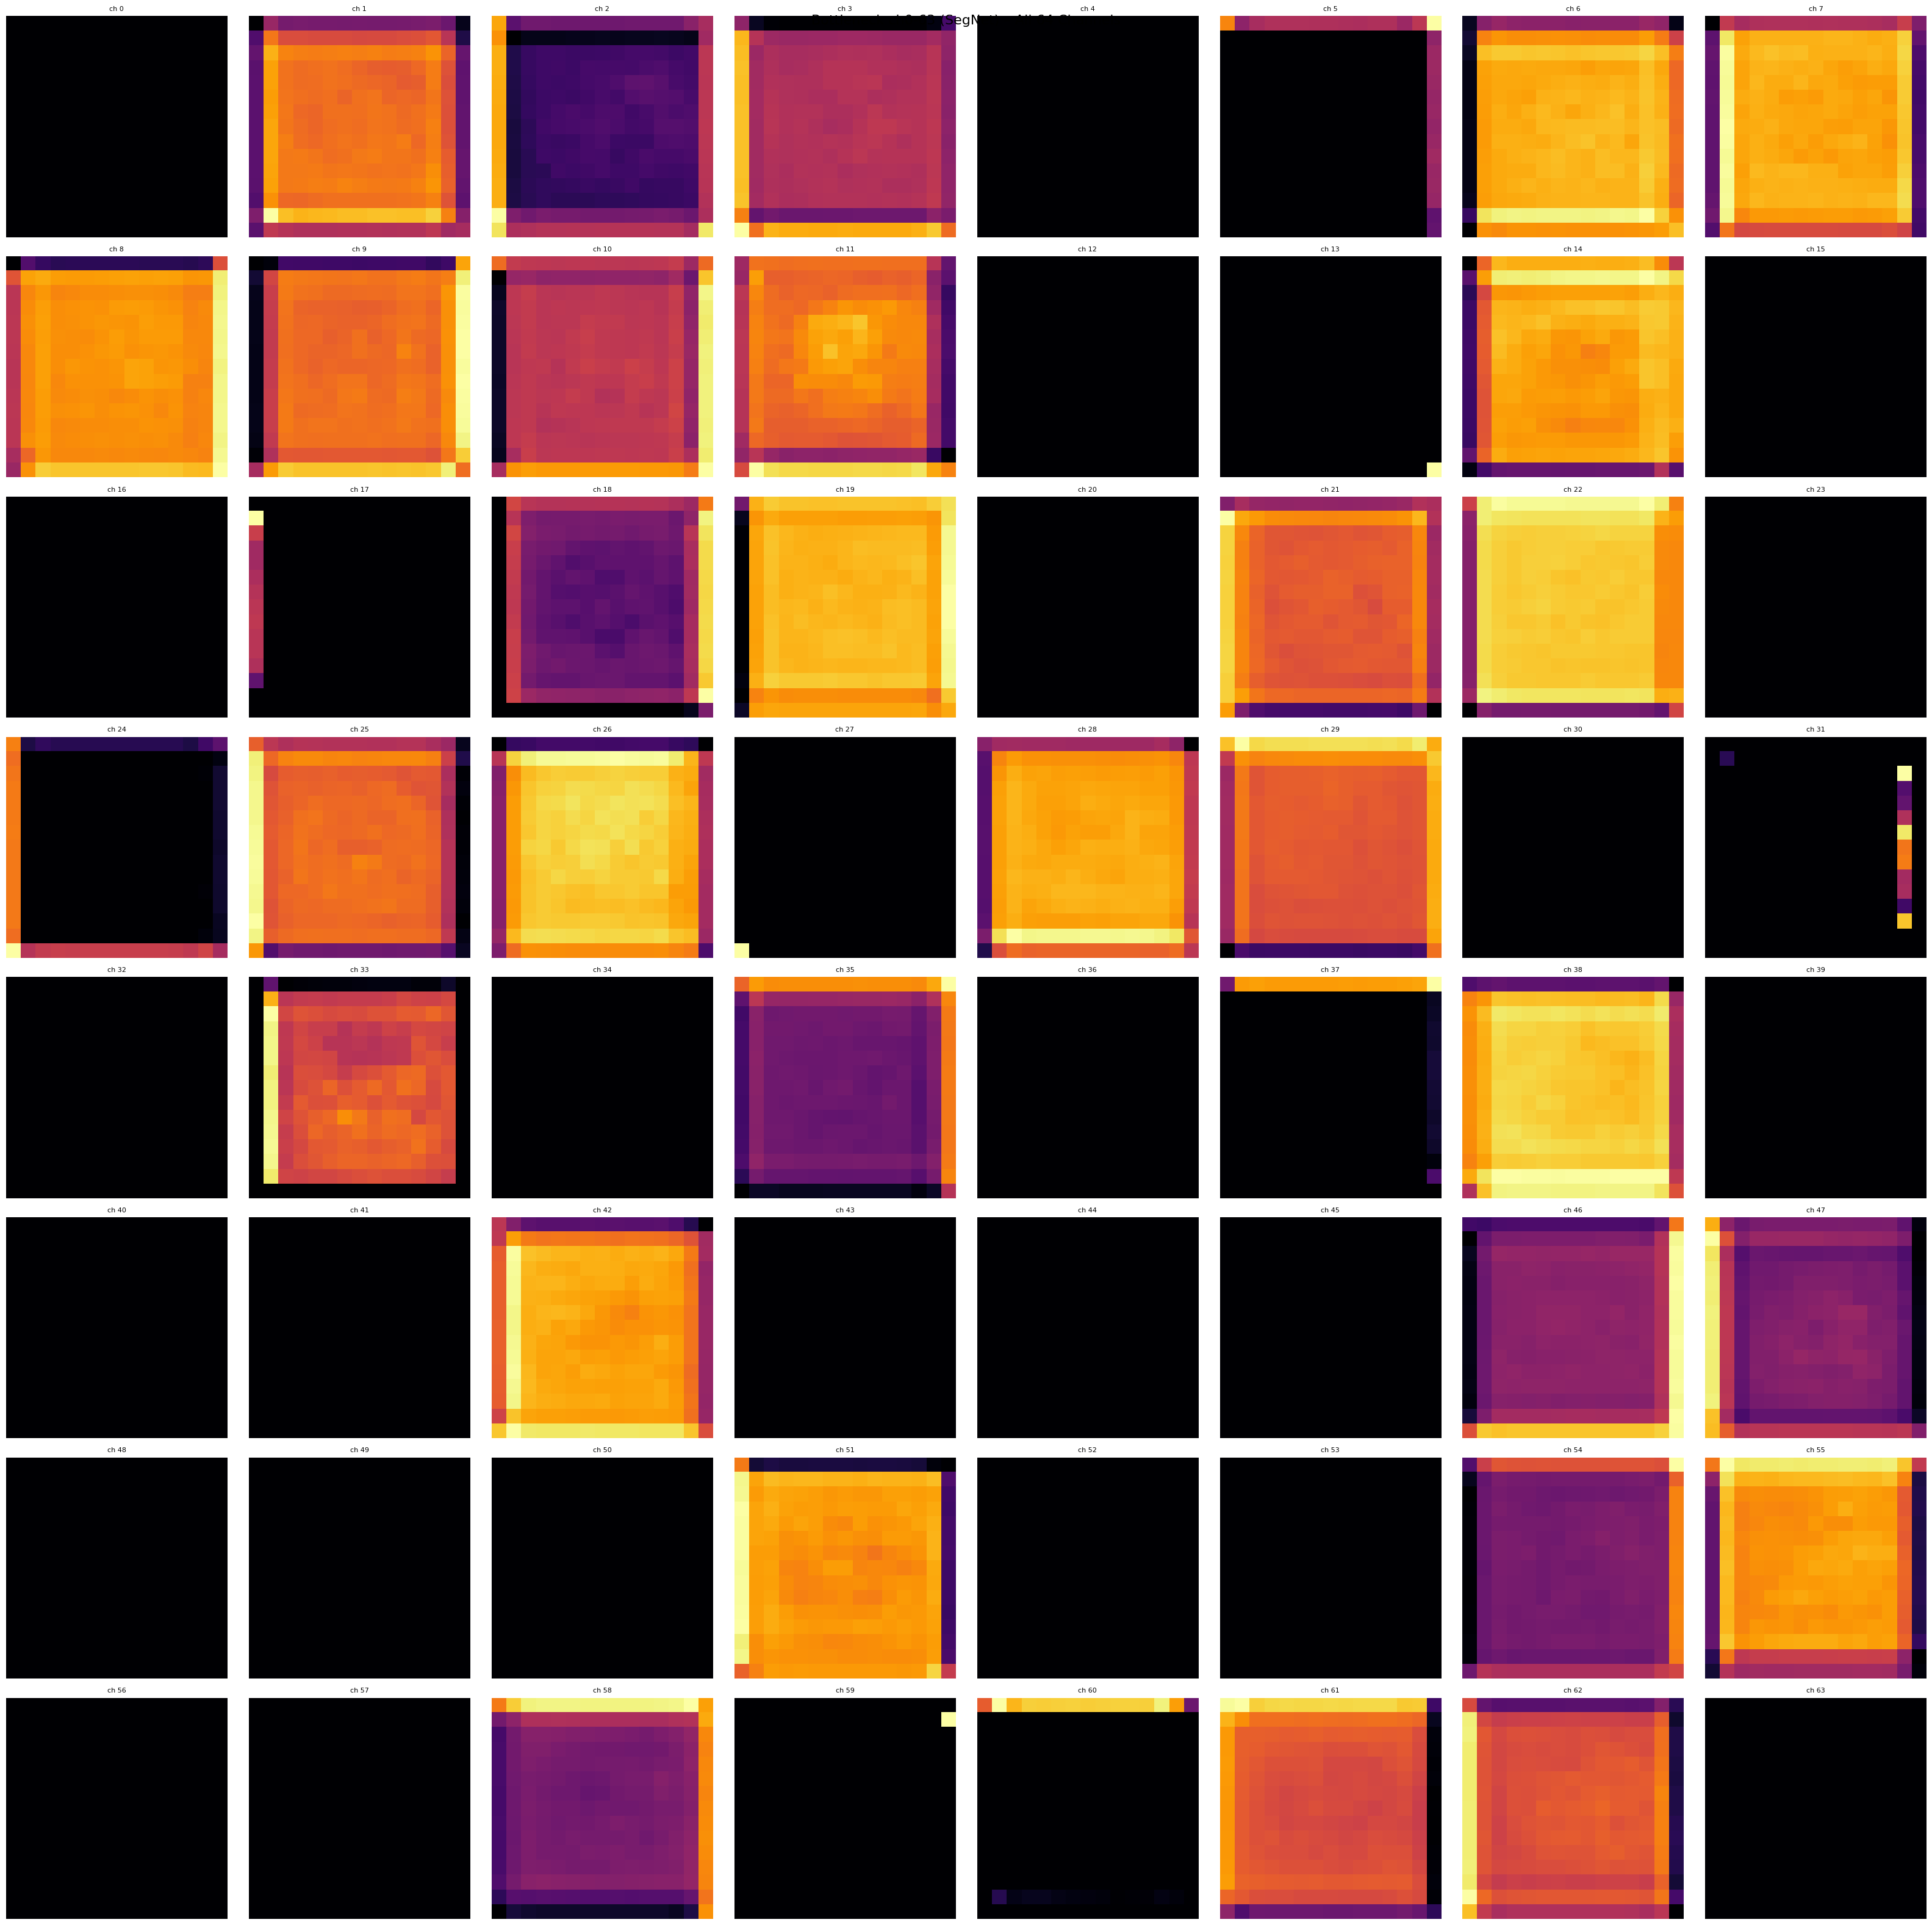

SegNet Bottleneck: Channels 64–127


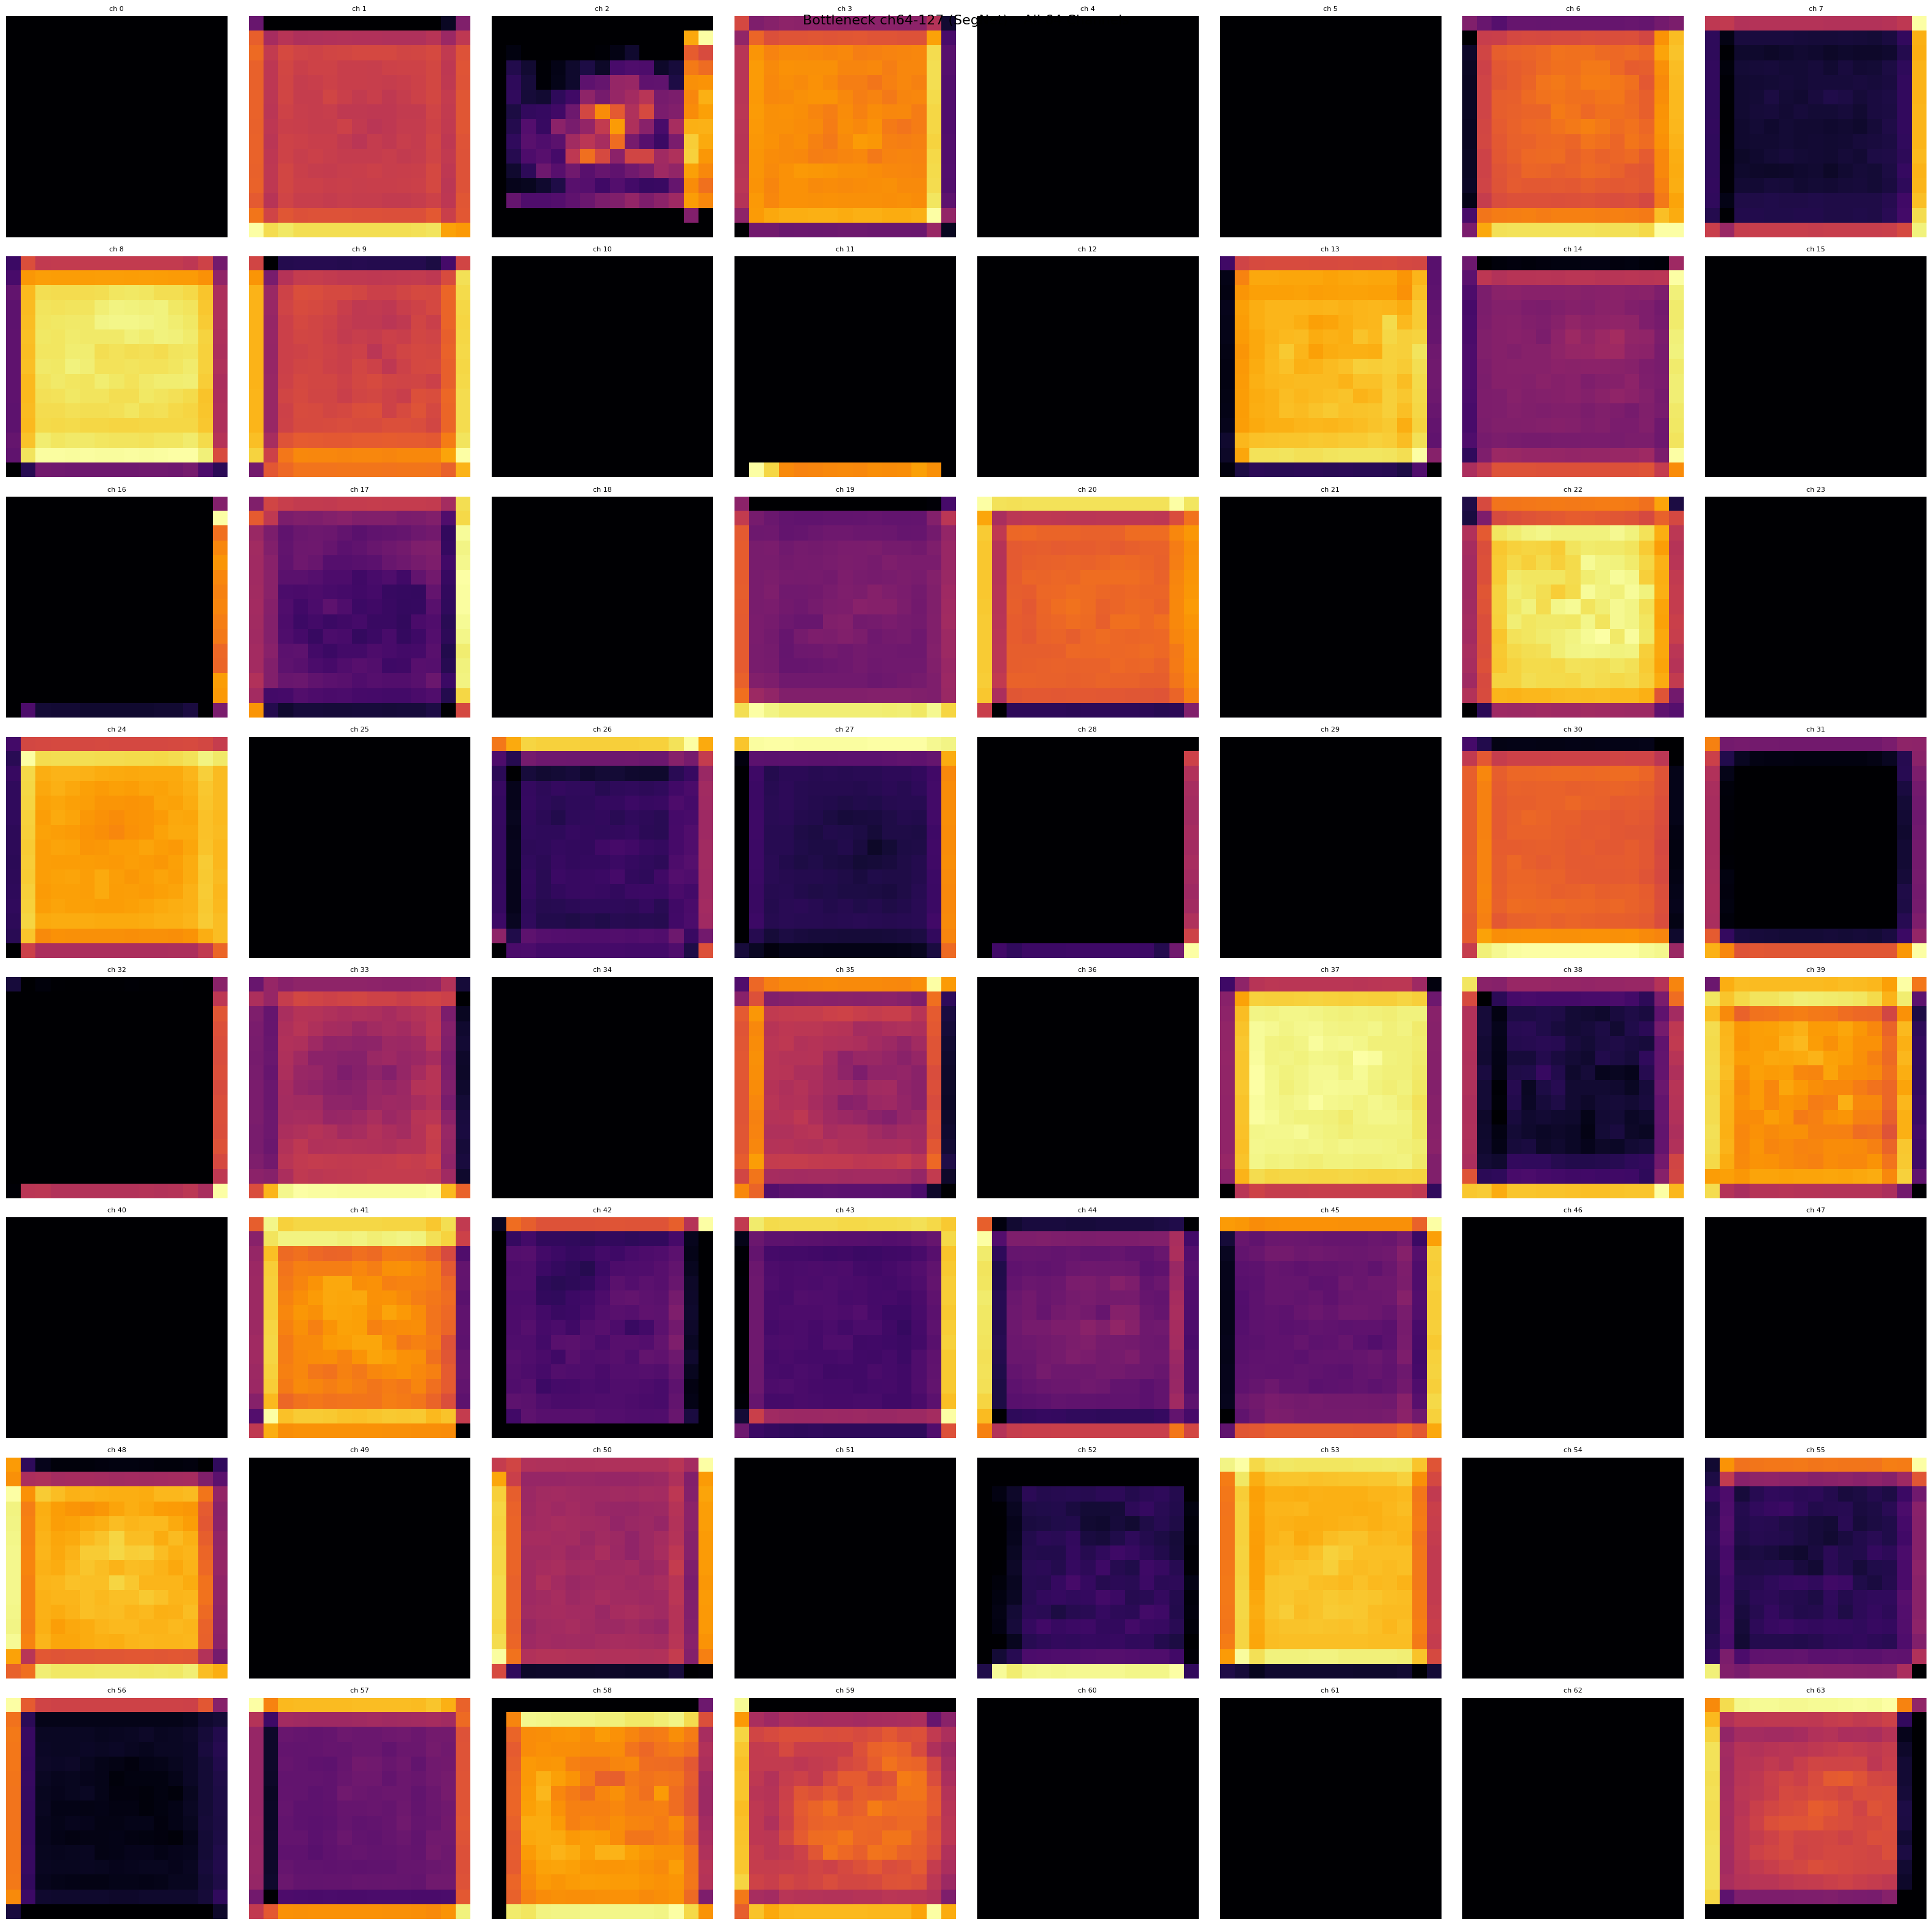

SegNet Bottleneck: Channels 128–191


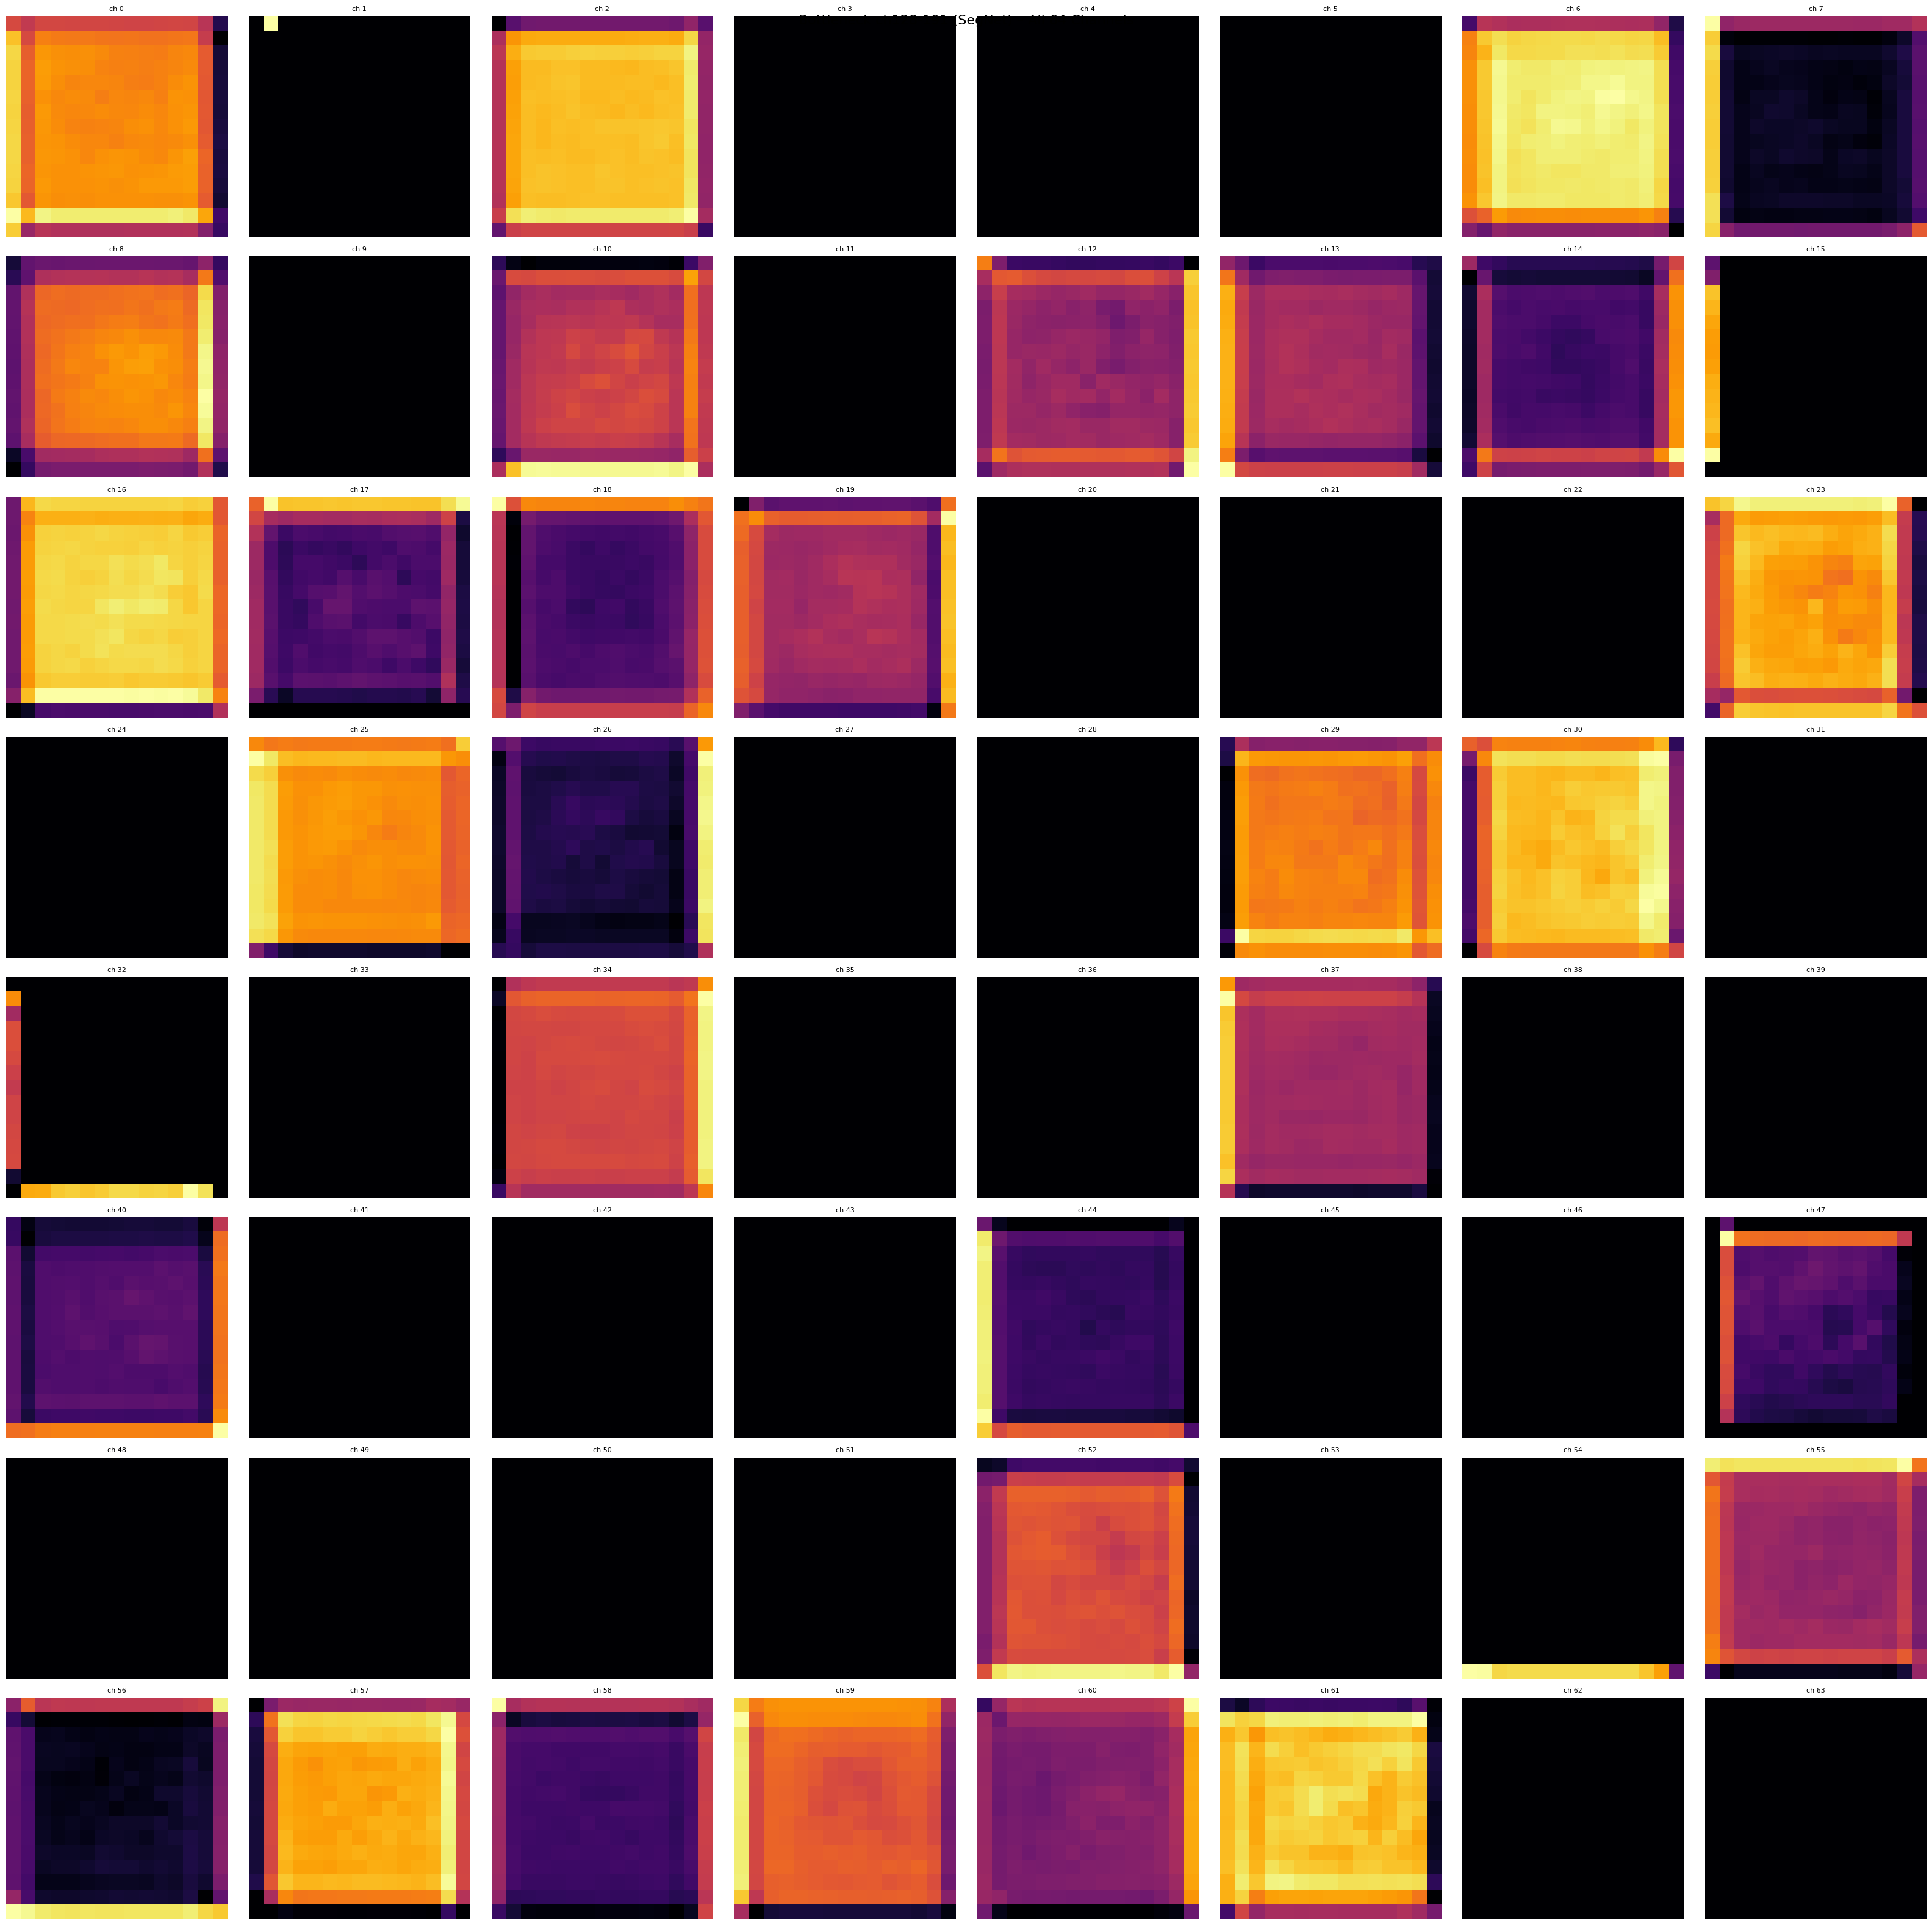

SegNet Bottleneck: Channels 192–255


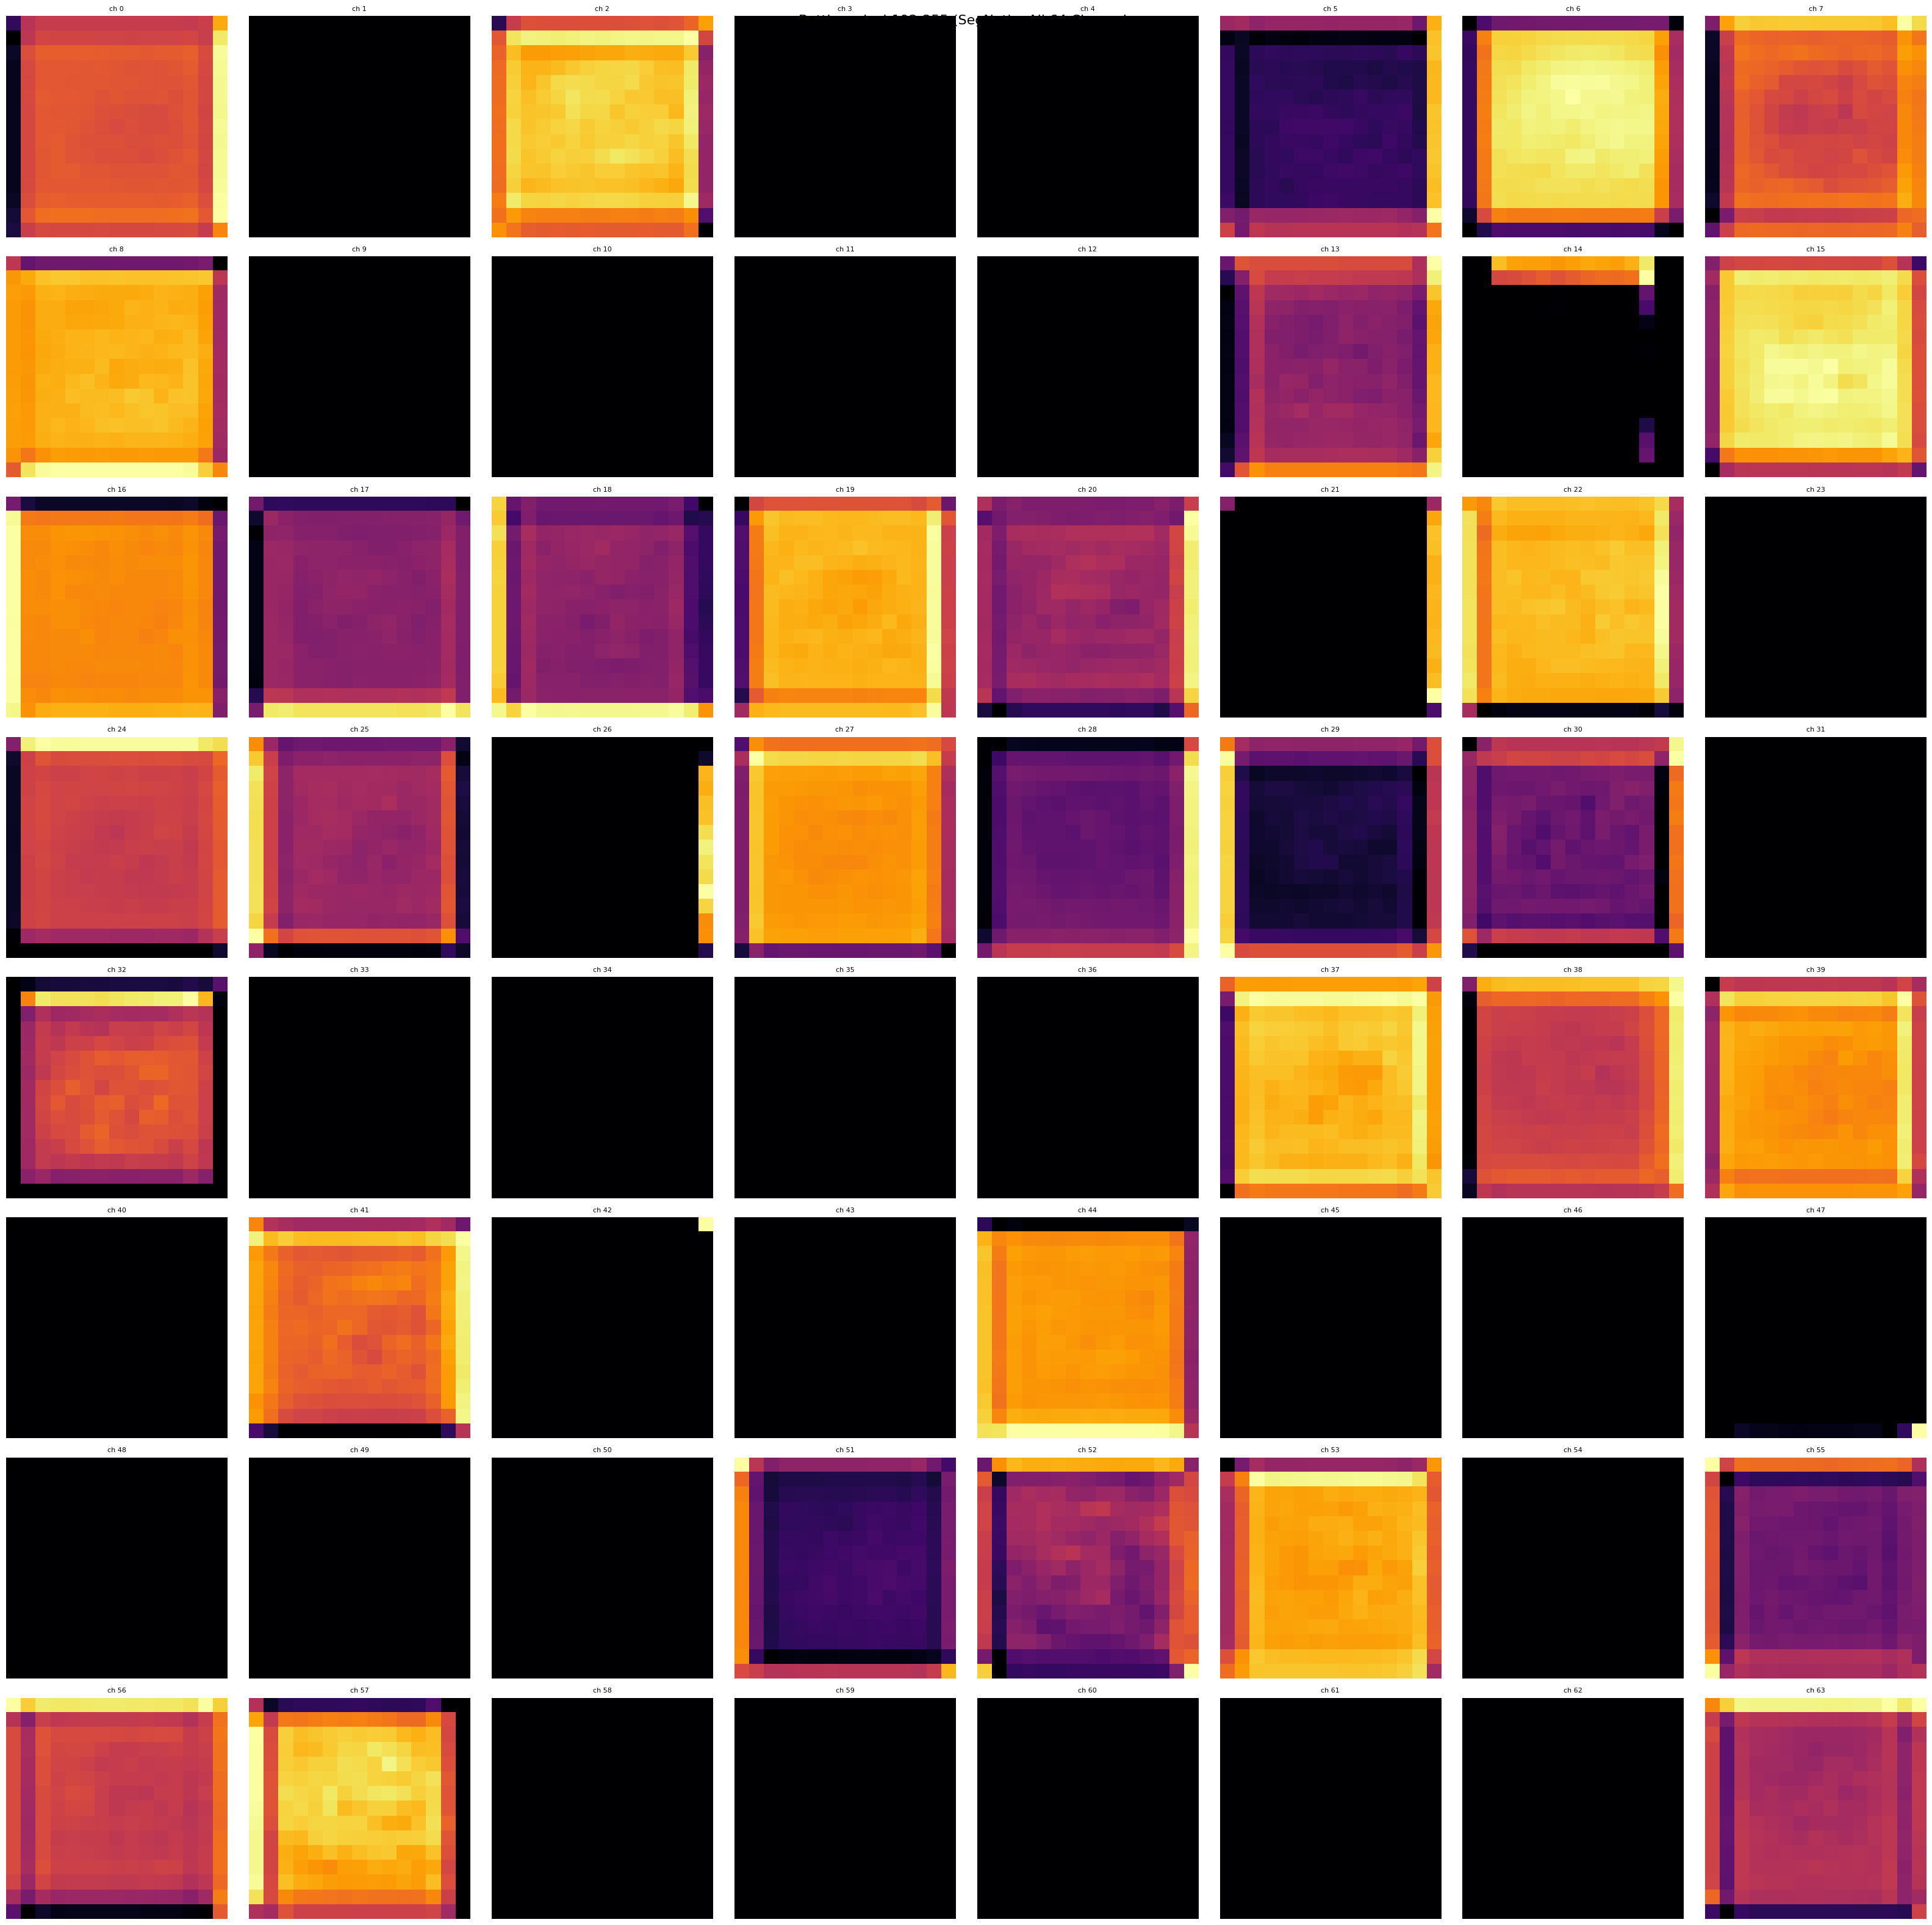

SegNet Bottleneck: Channels 256–319


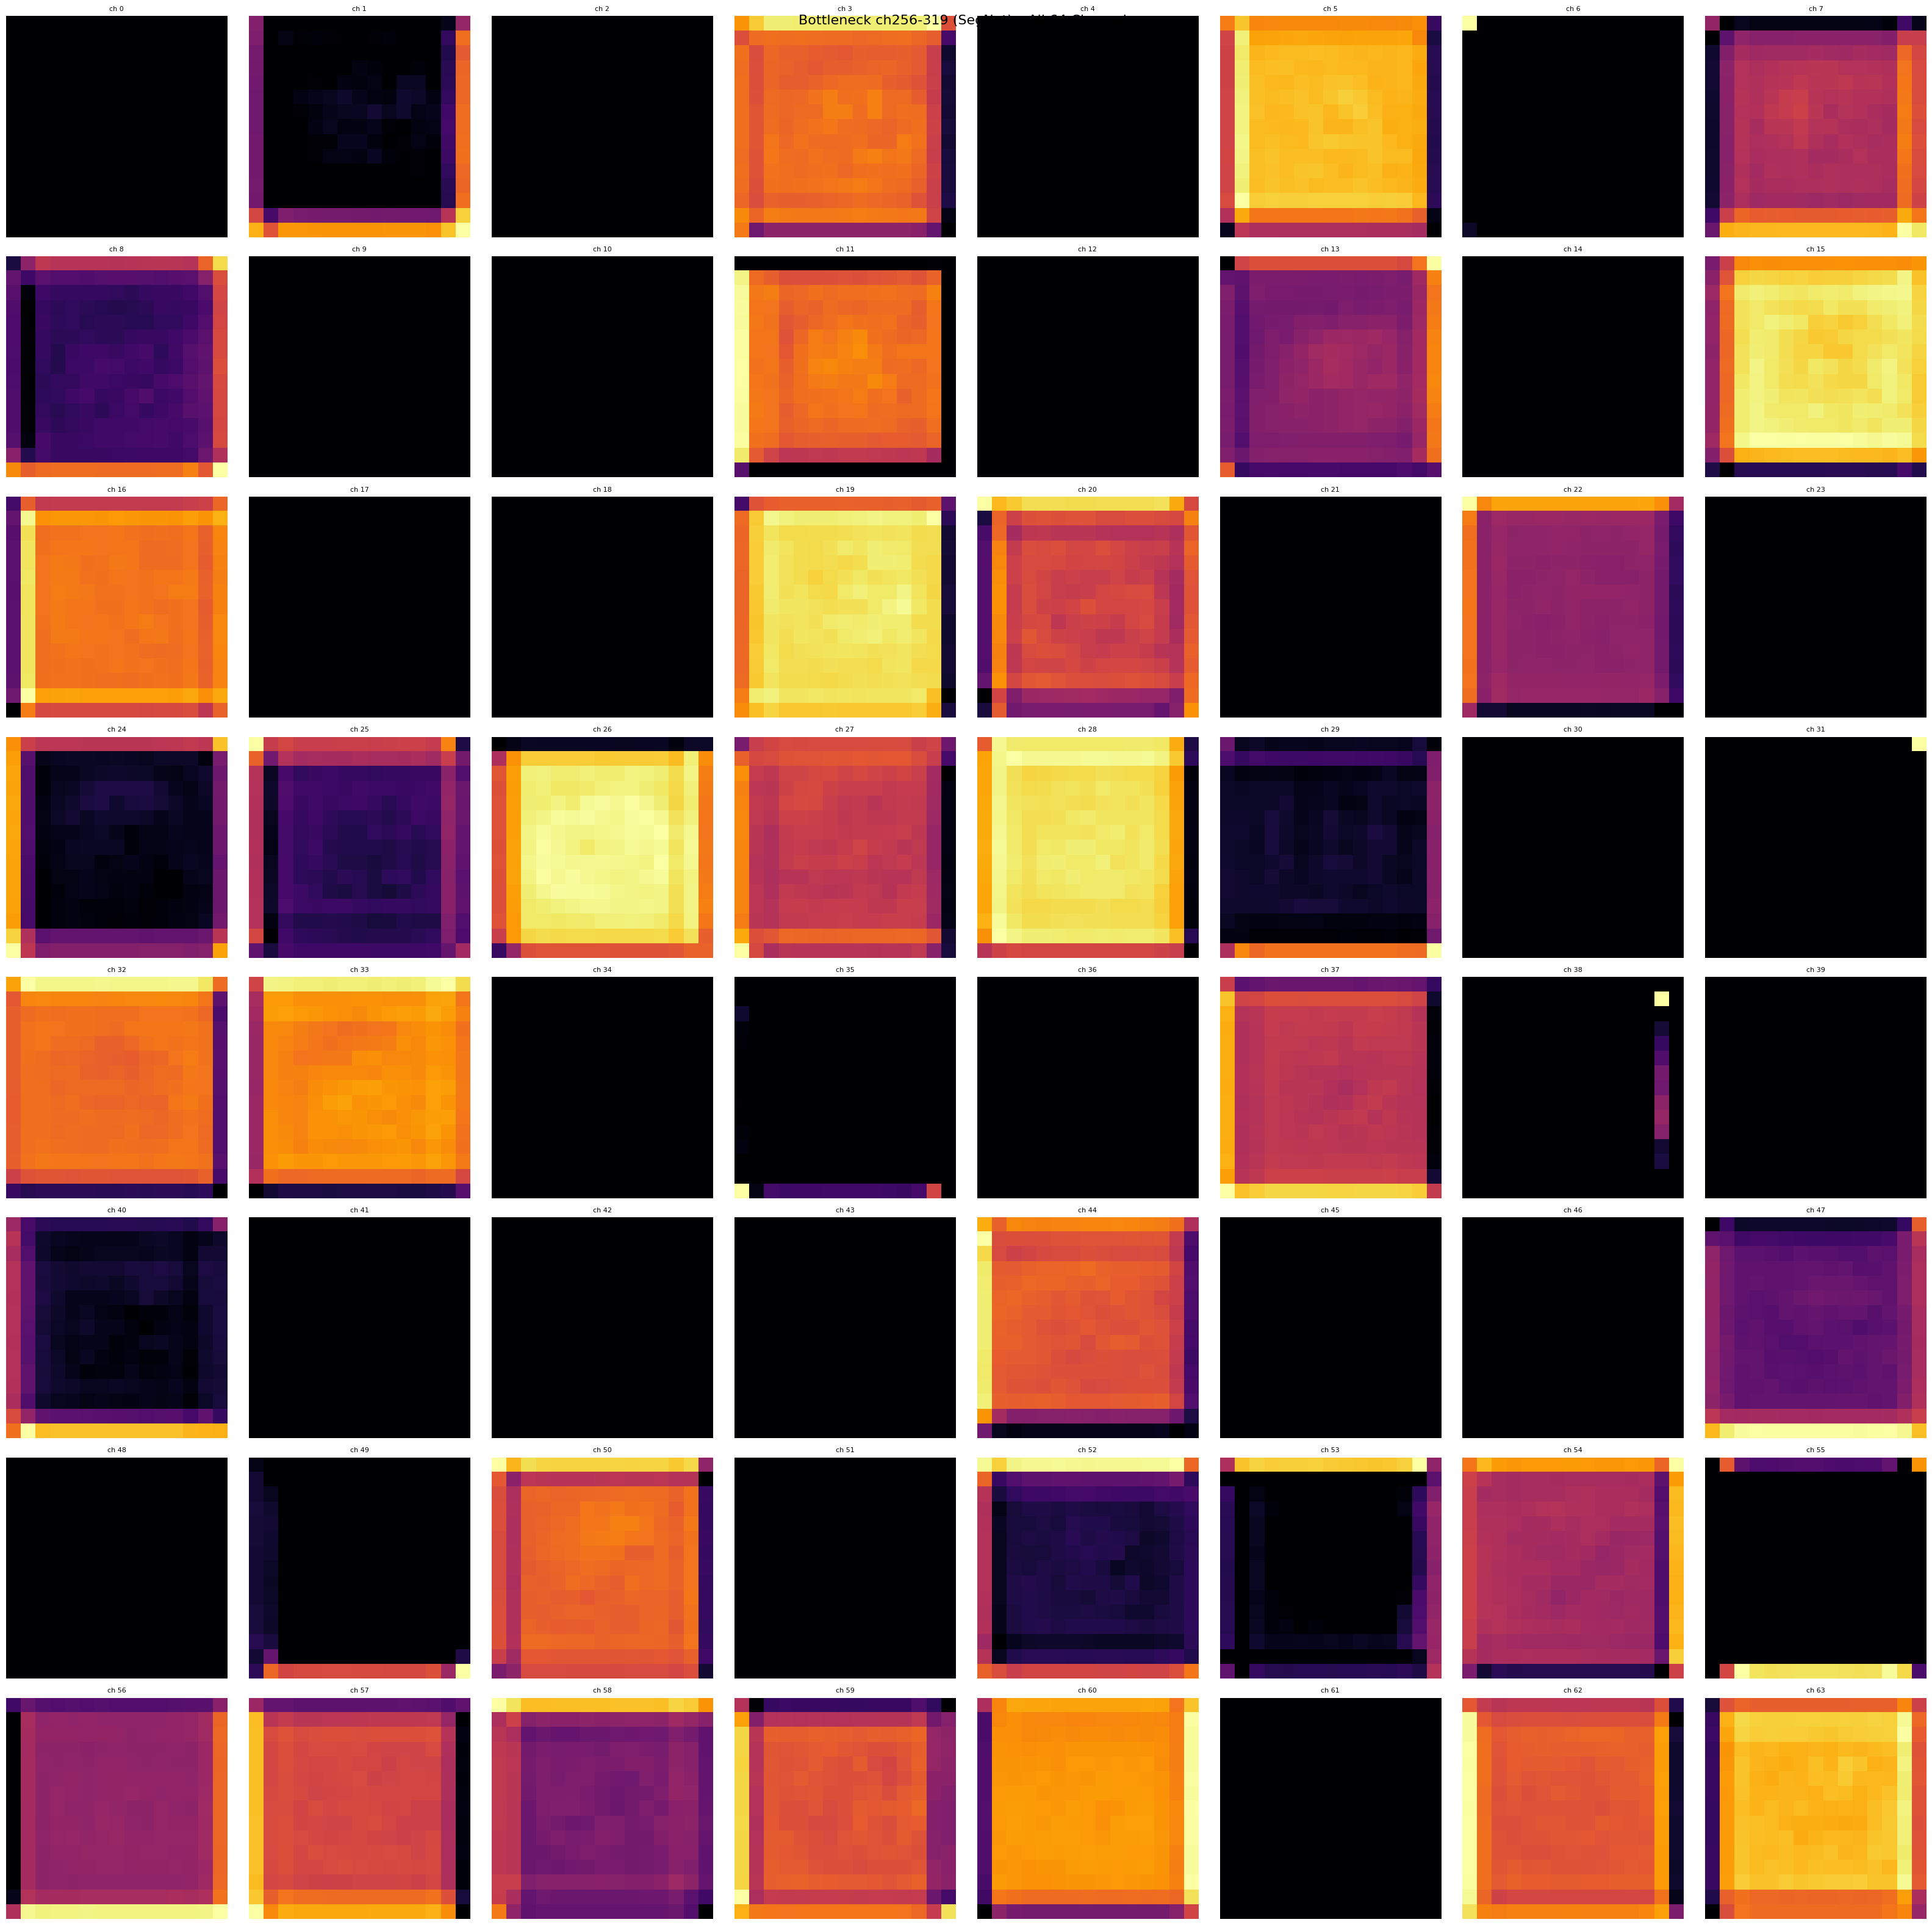

SegNet Bottleneck: Channels 320–383


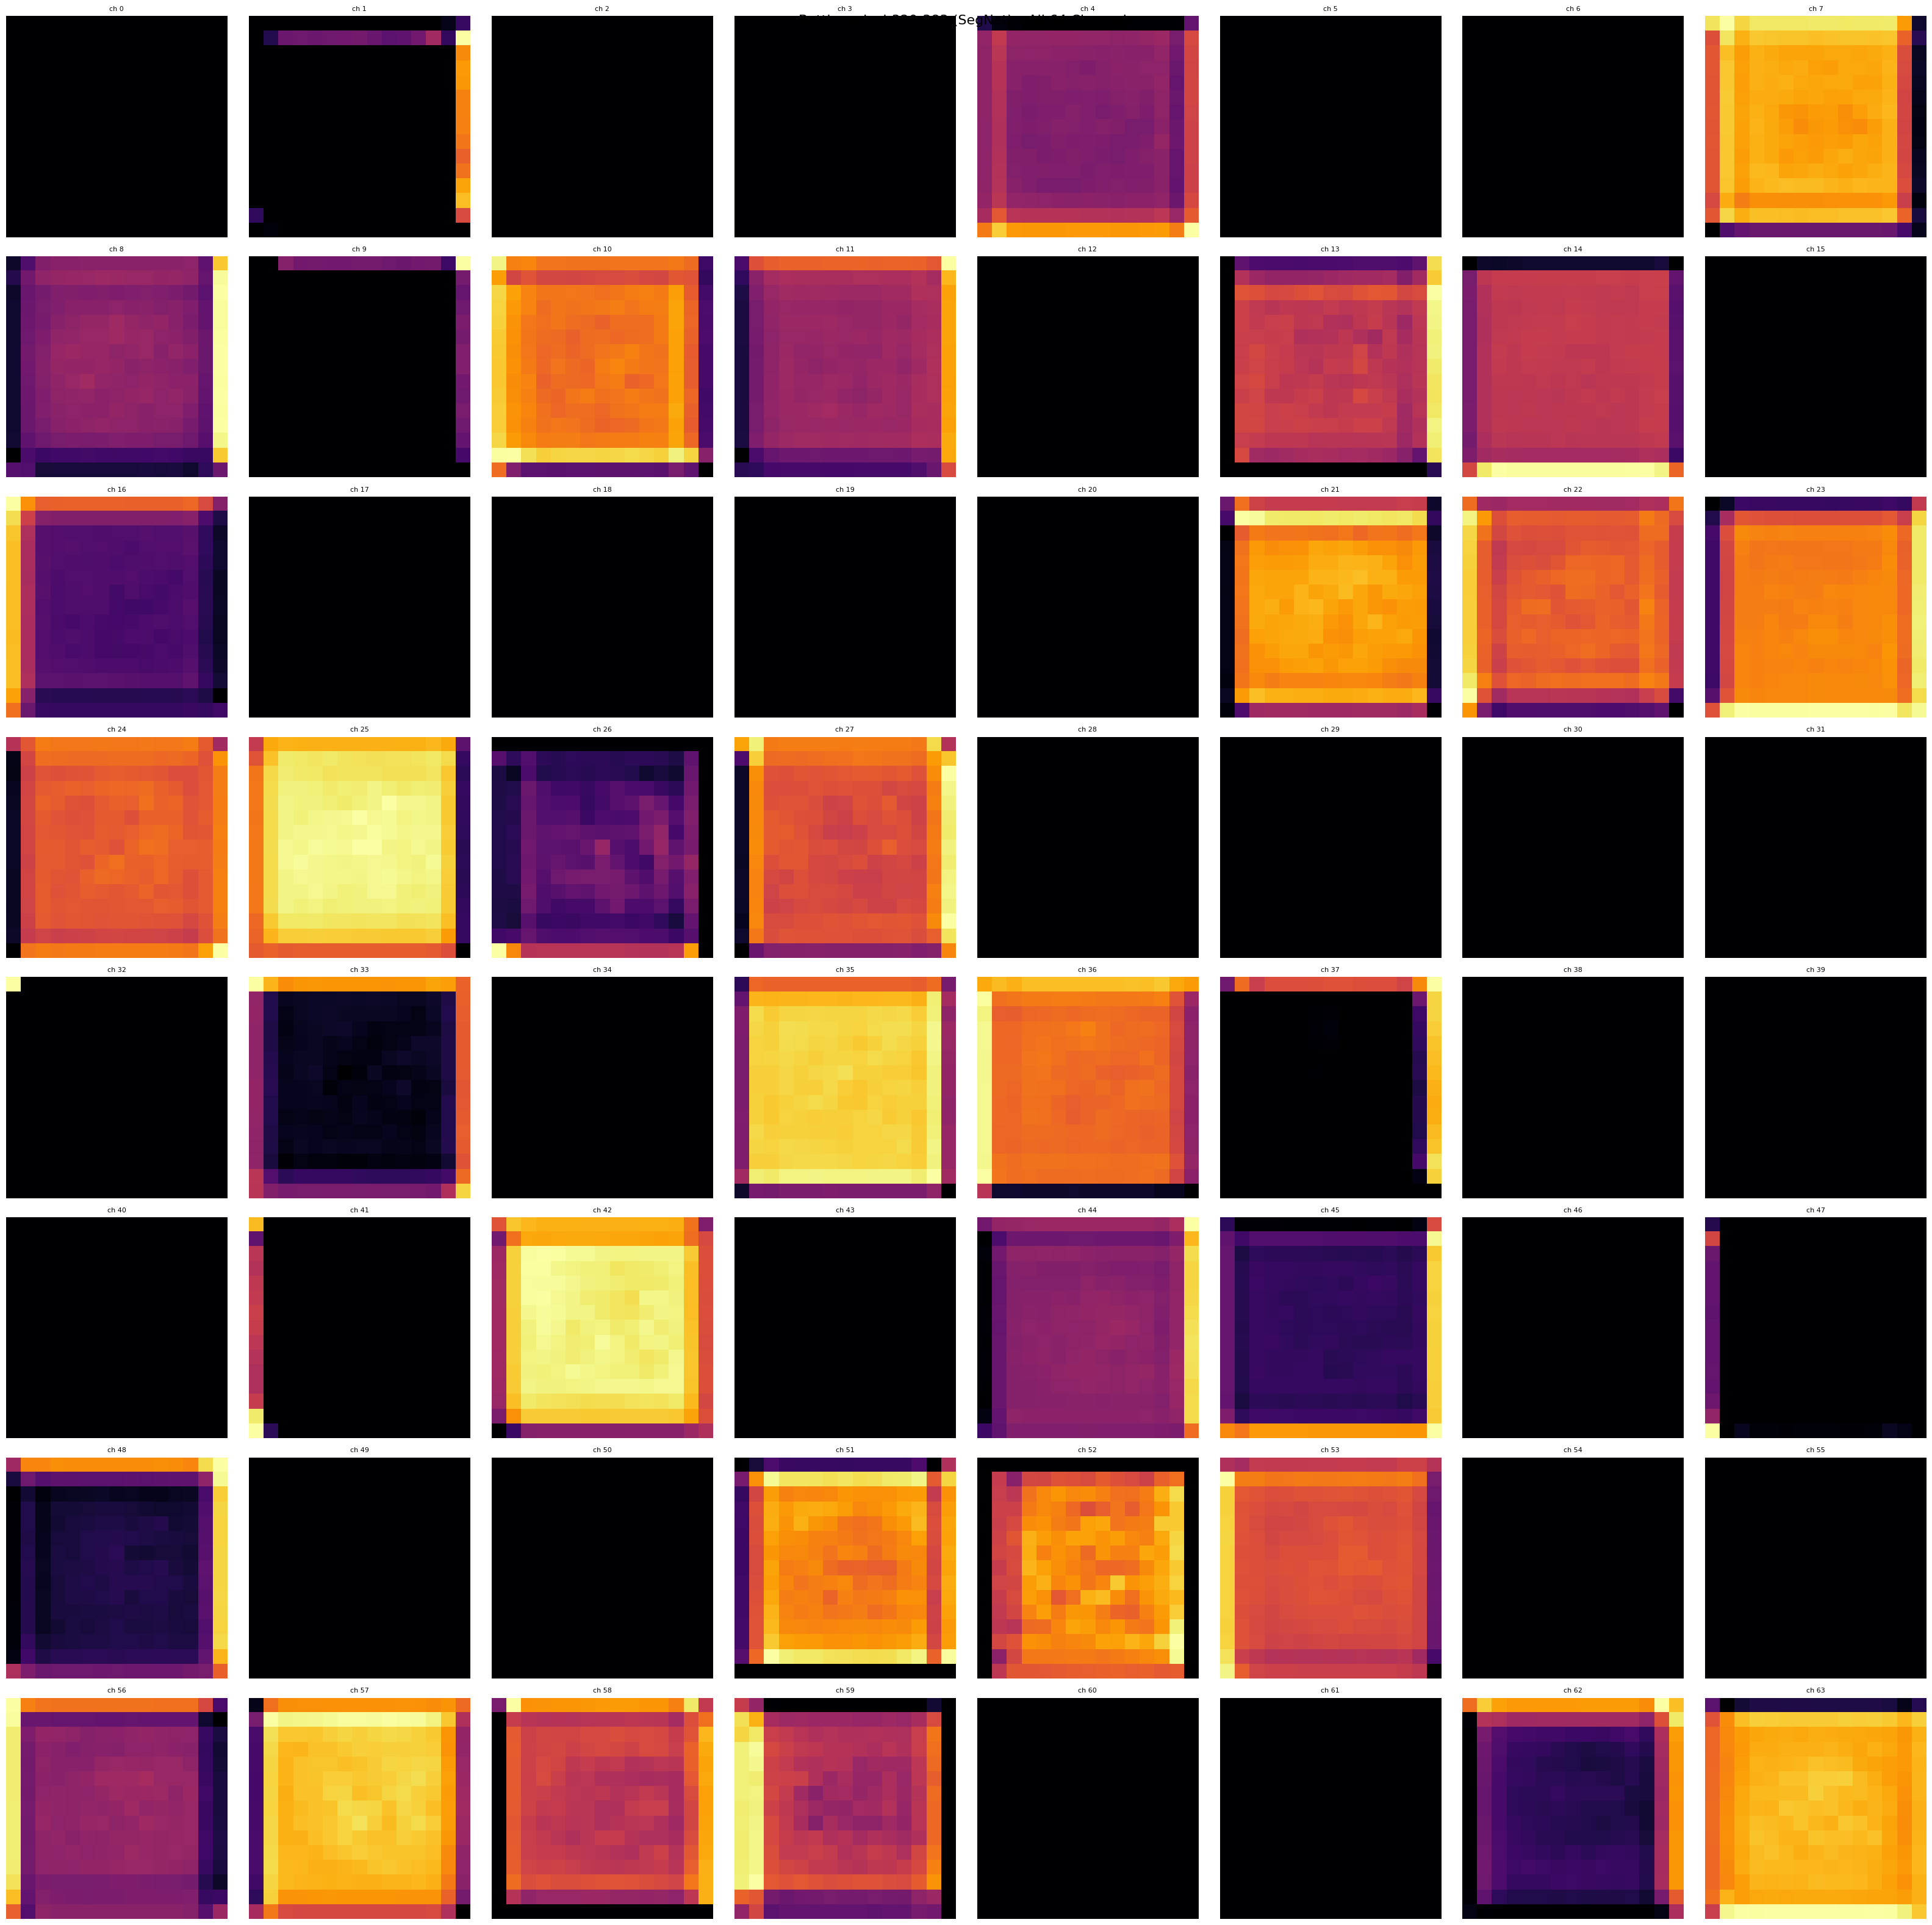

SegNet Bottleneck: Channels 384–447


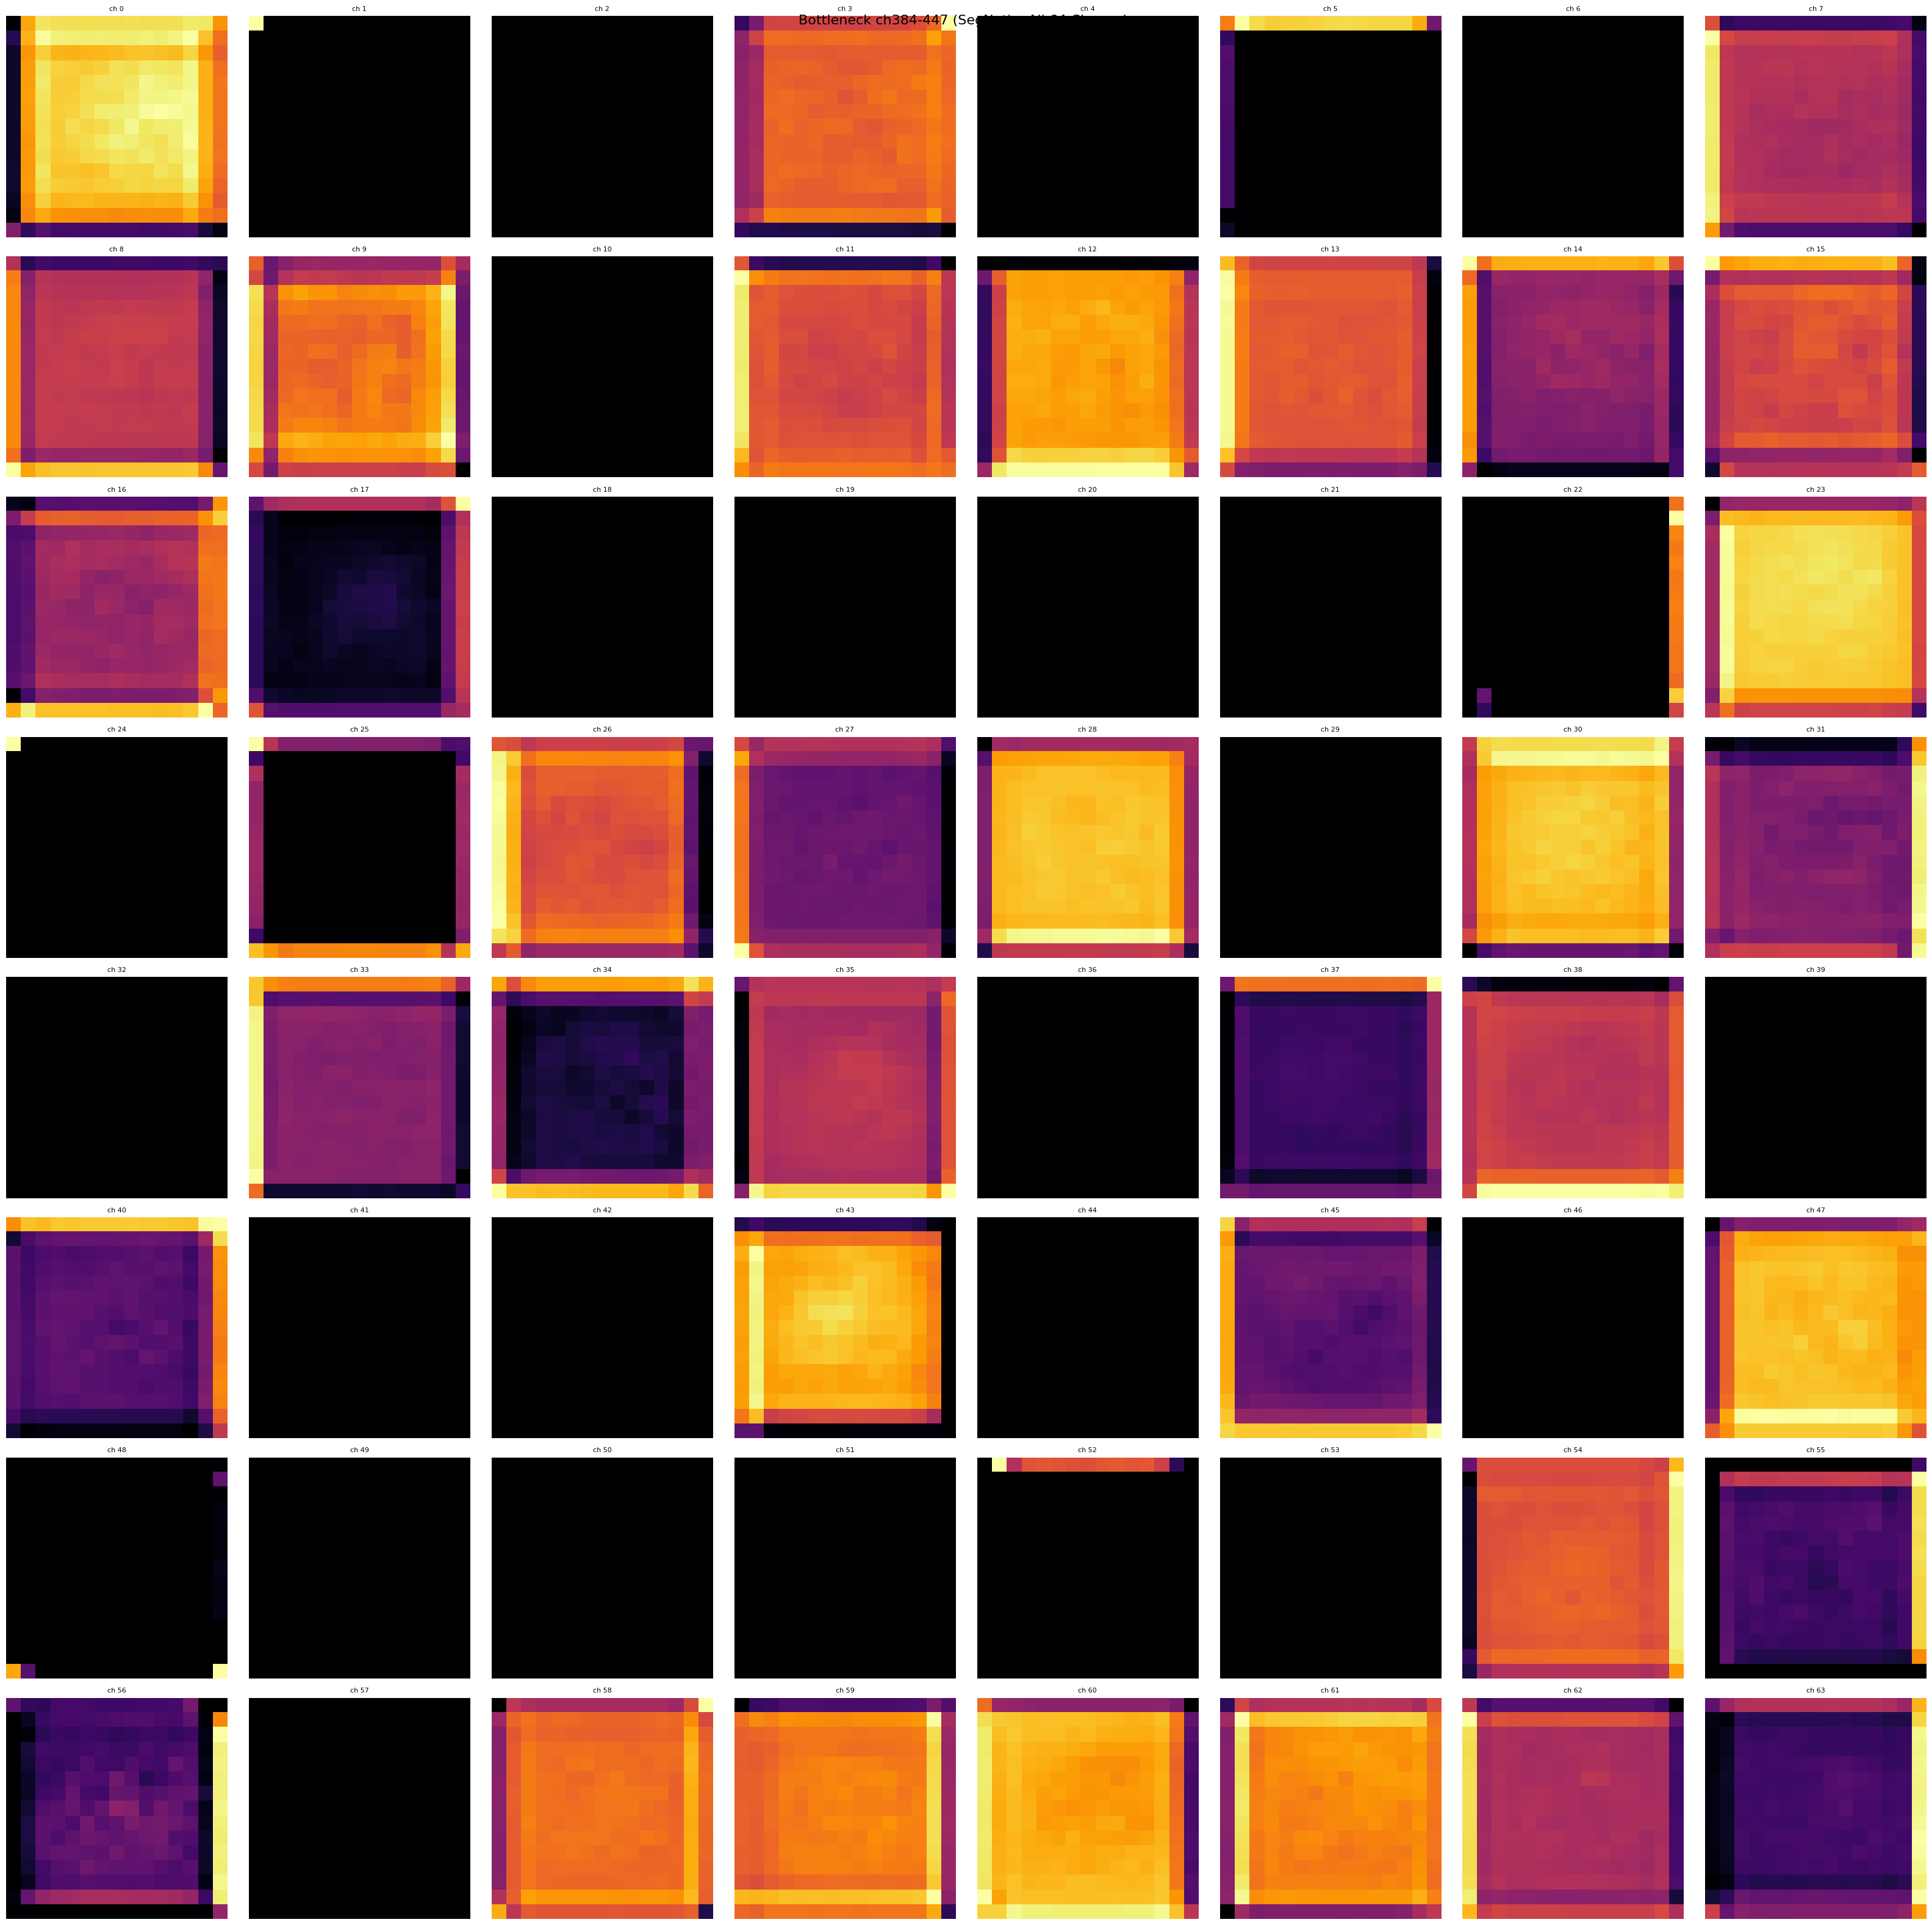

SegNet Bottleneck: Channels 448–511


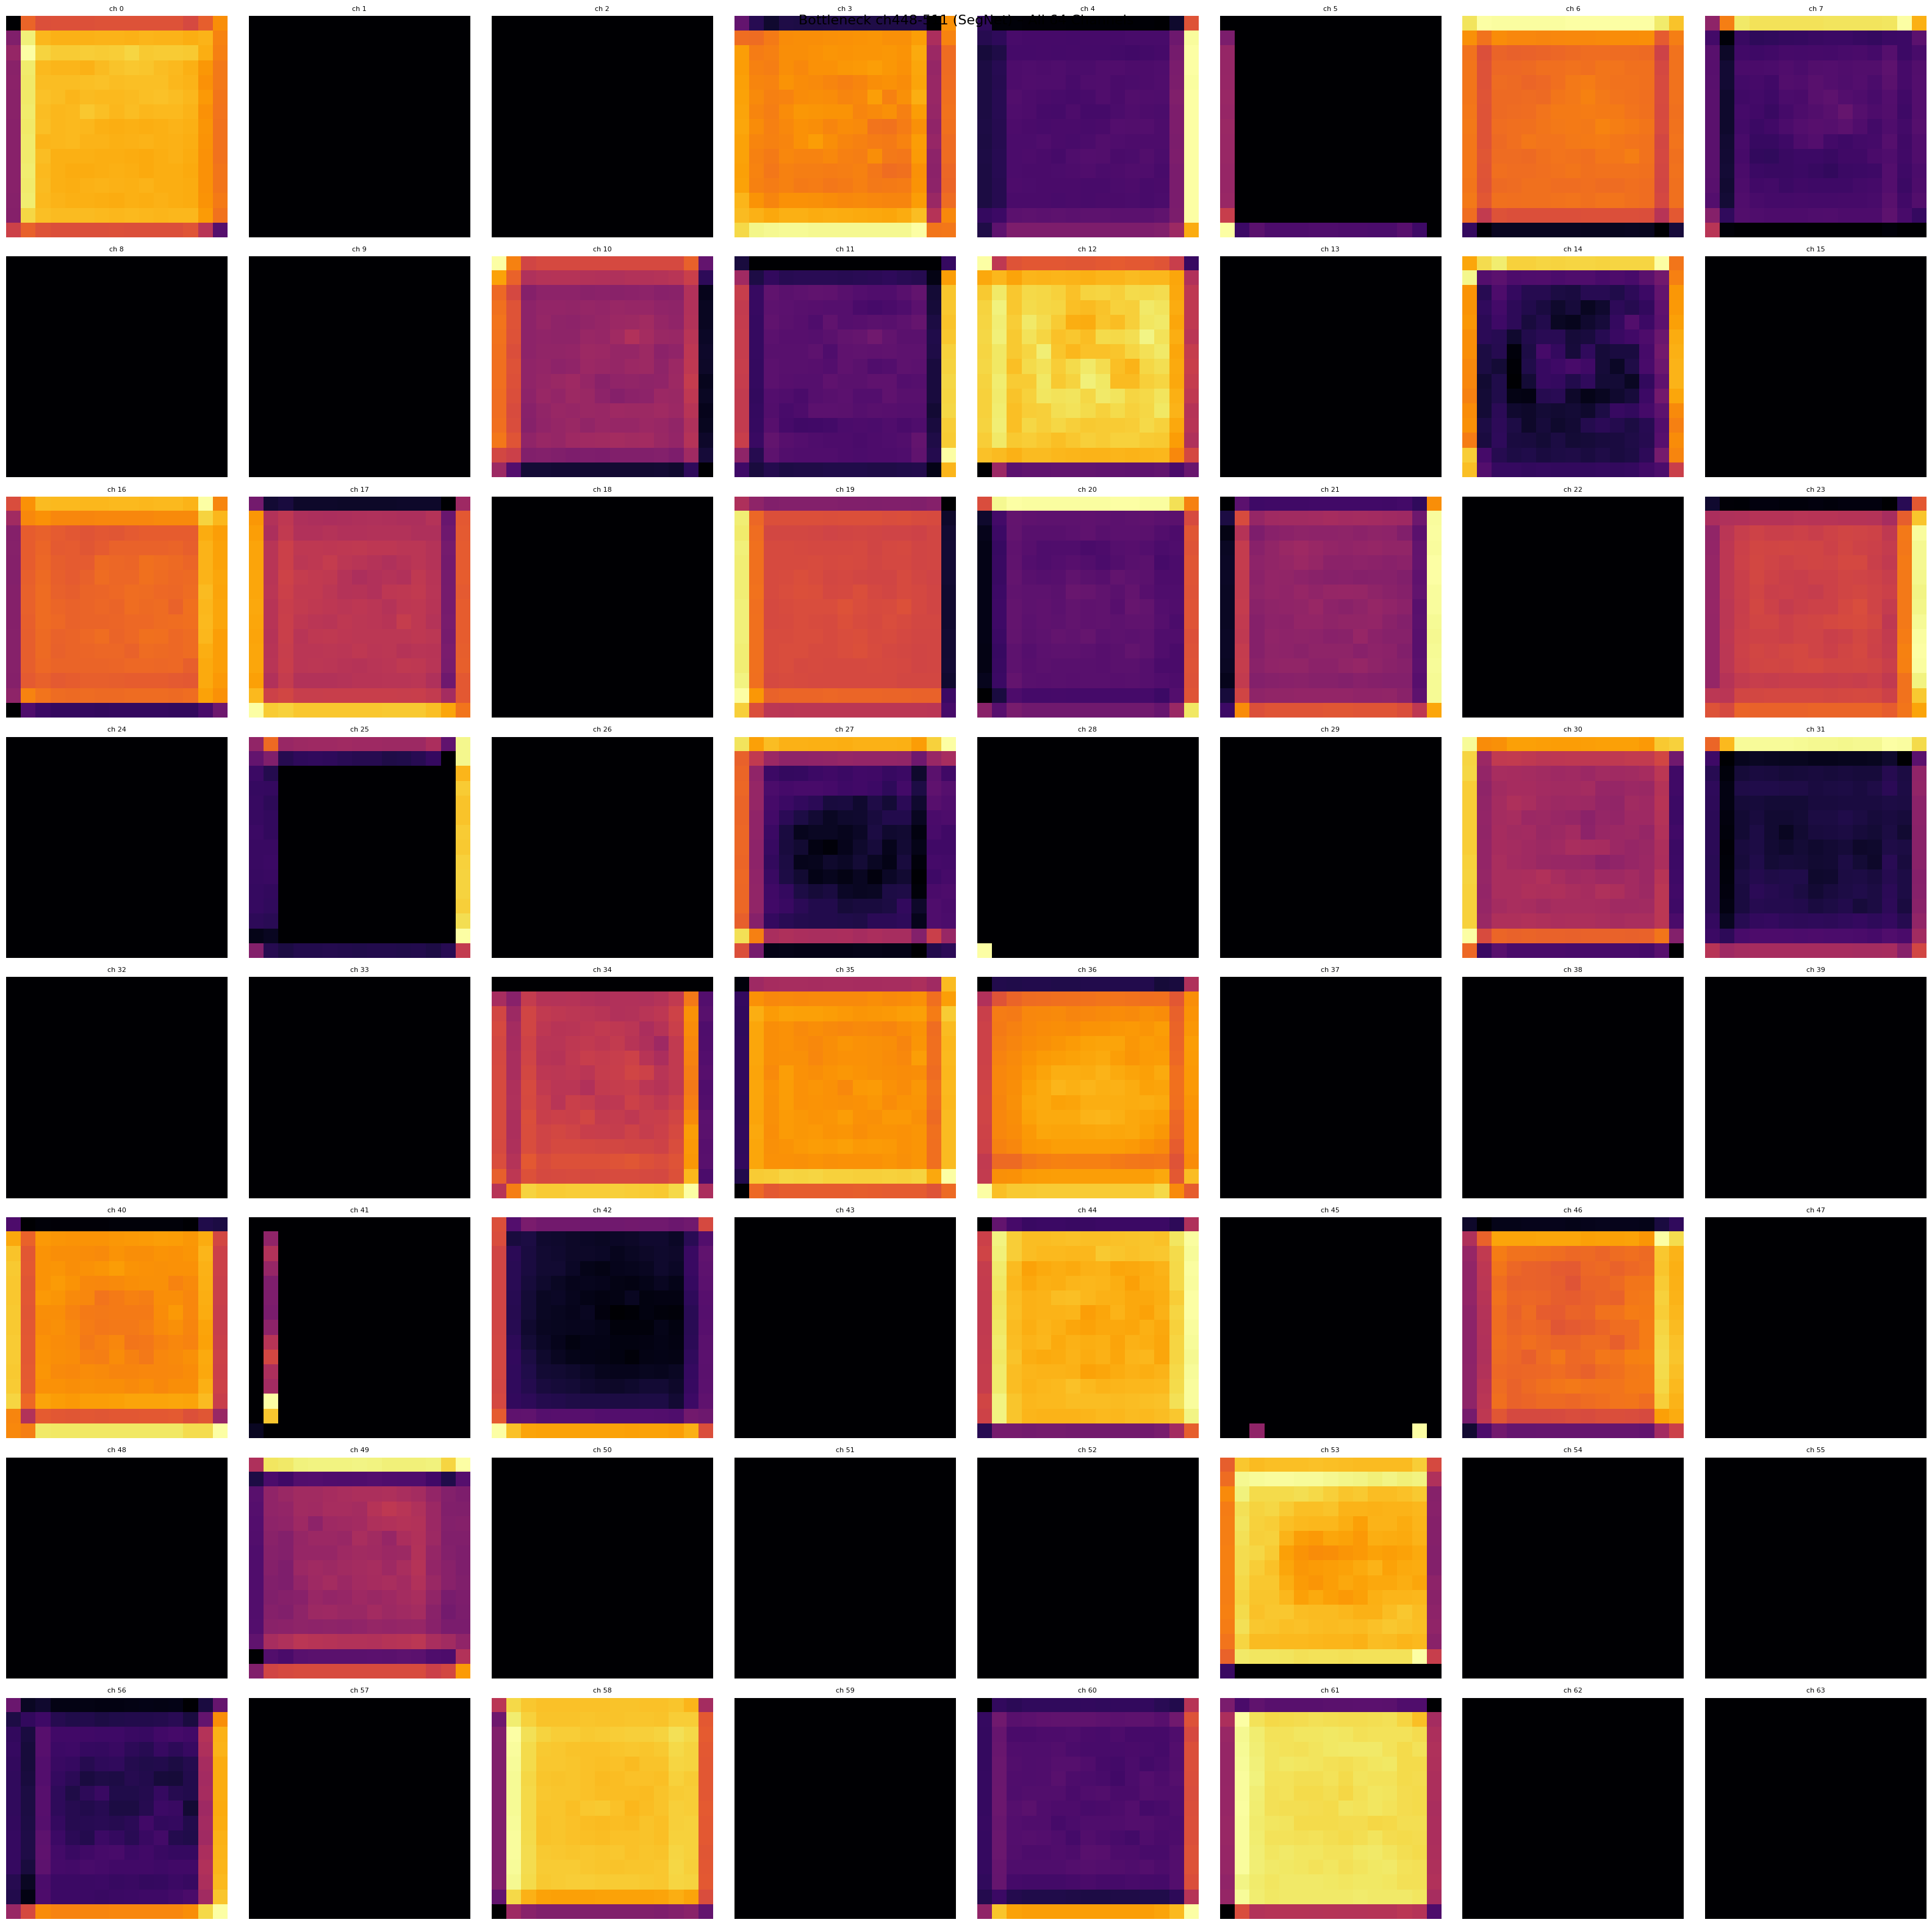

In [43]:
paginate_segnet_feature_maps(bottleneck_feat, 'Bottleneck')

SegNet Decoder: up3: Channels 0–63


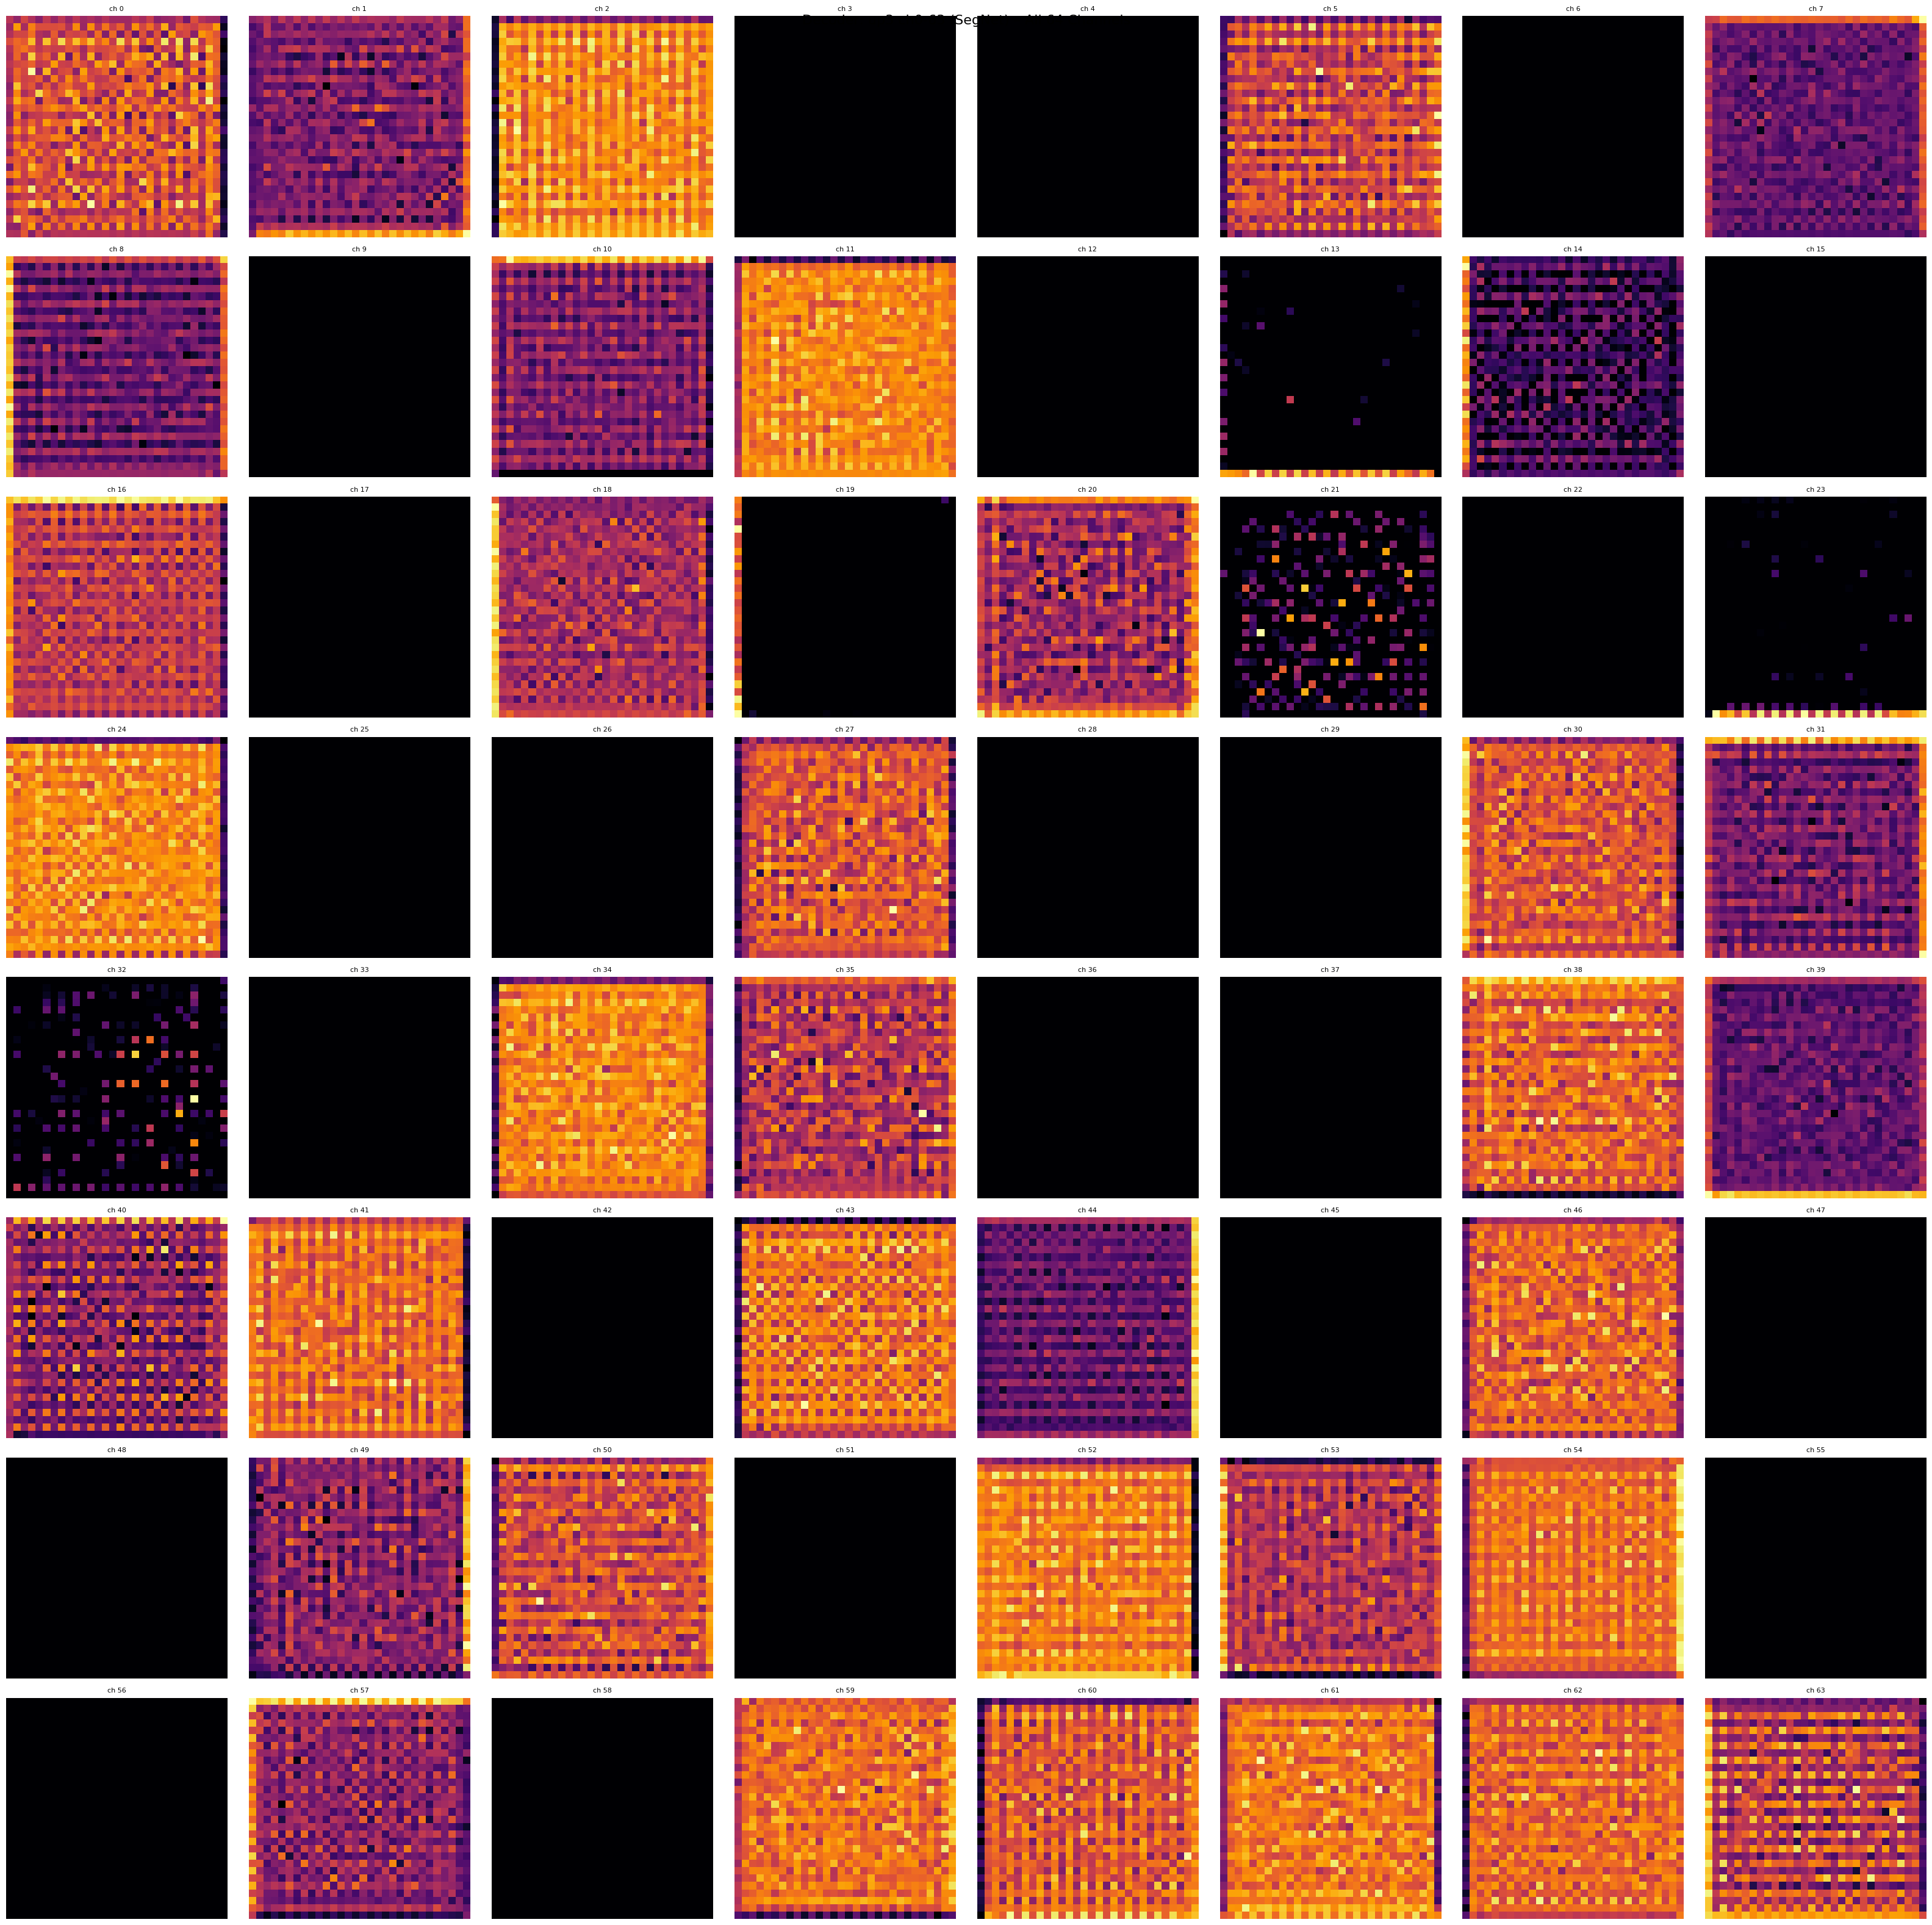

SegNet Decoder: up3: Channels 64–127


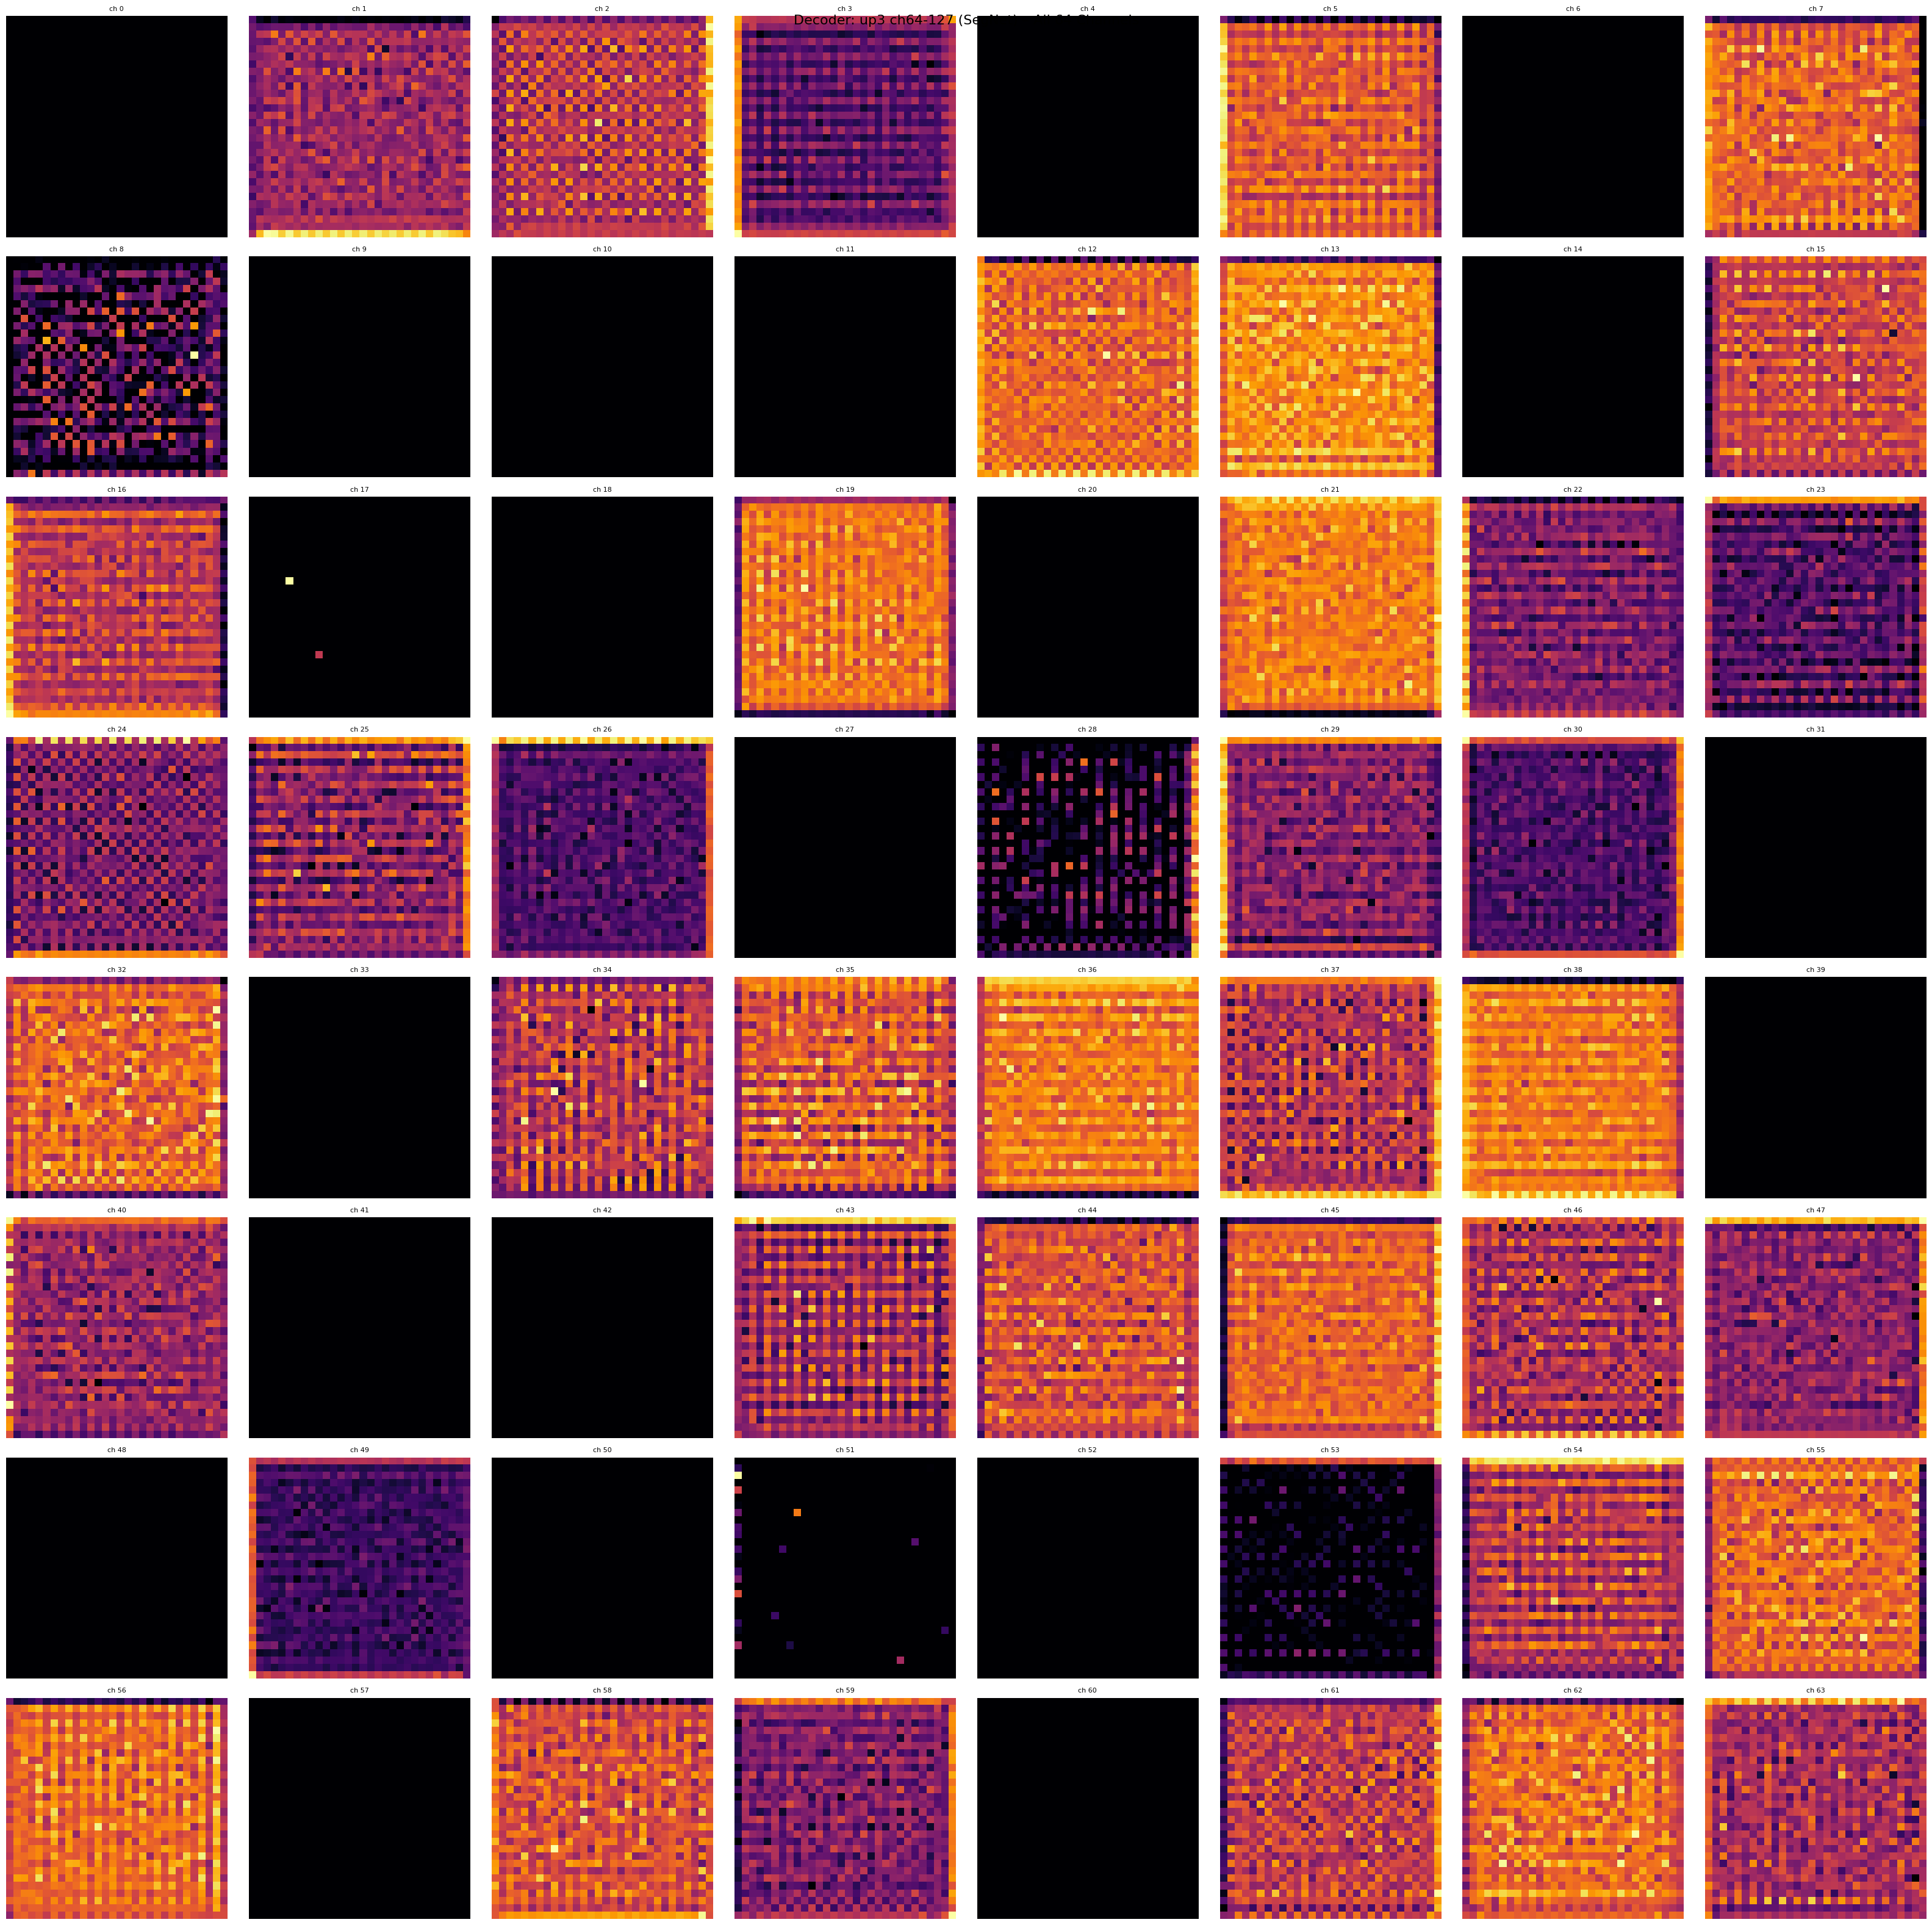

SegNet Decoder: up3: Channels 128–191


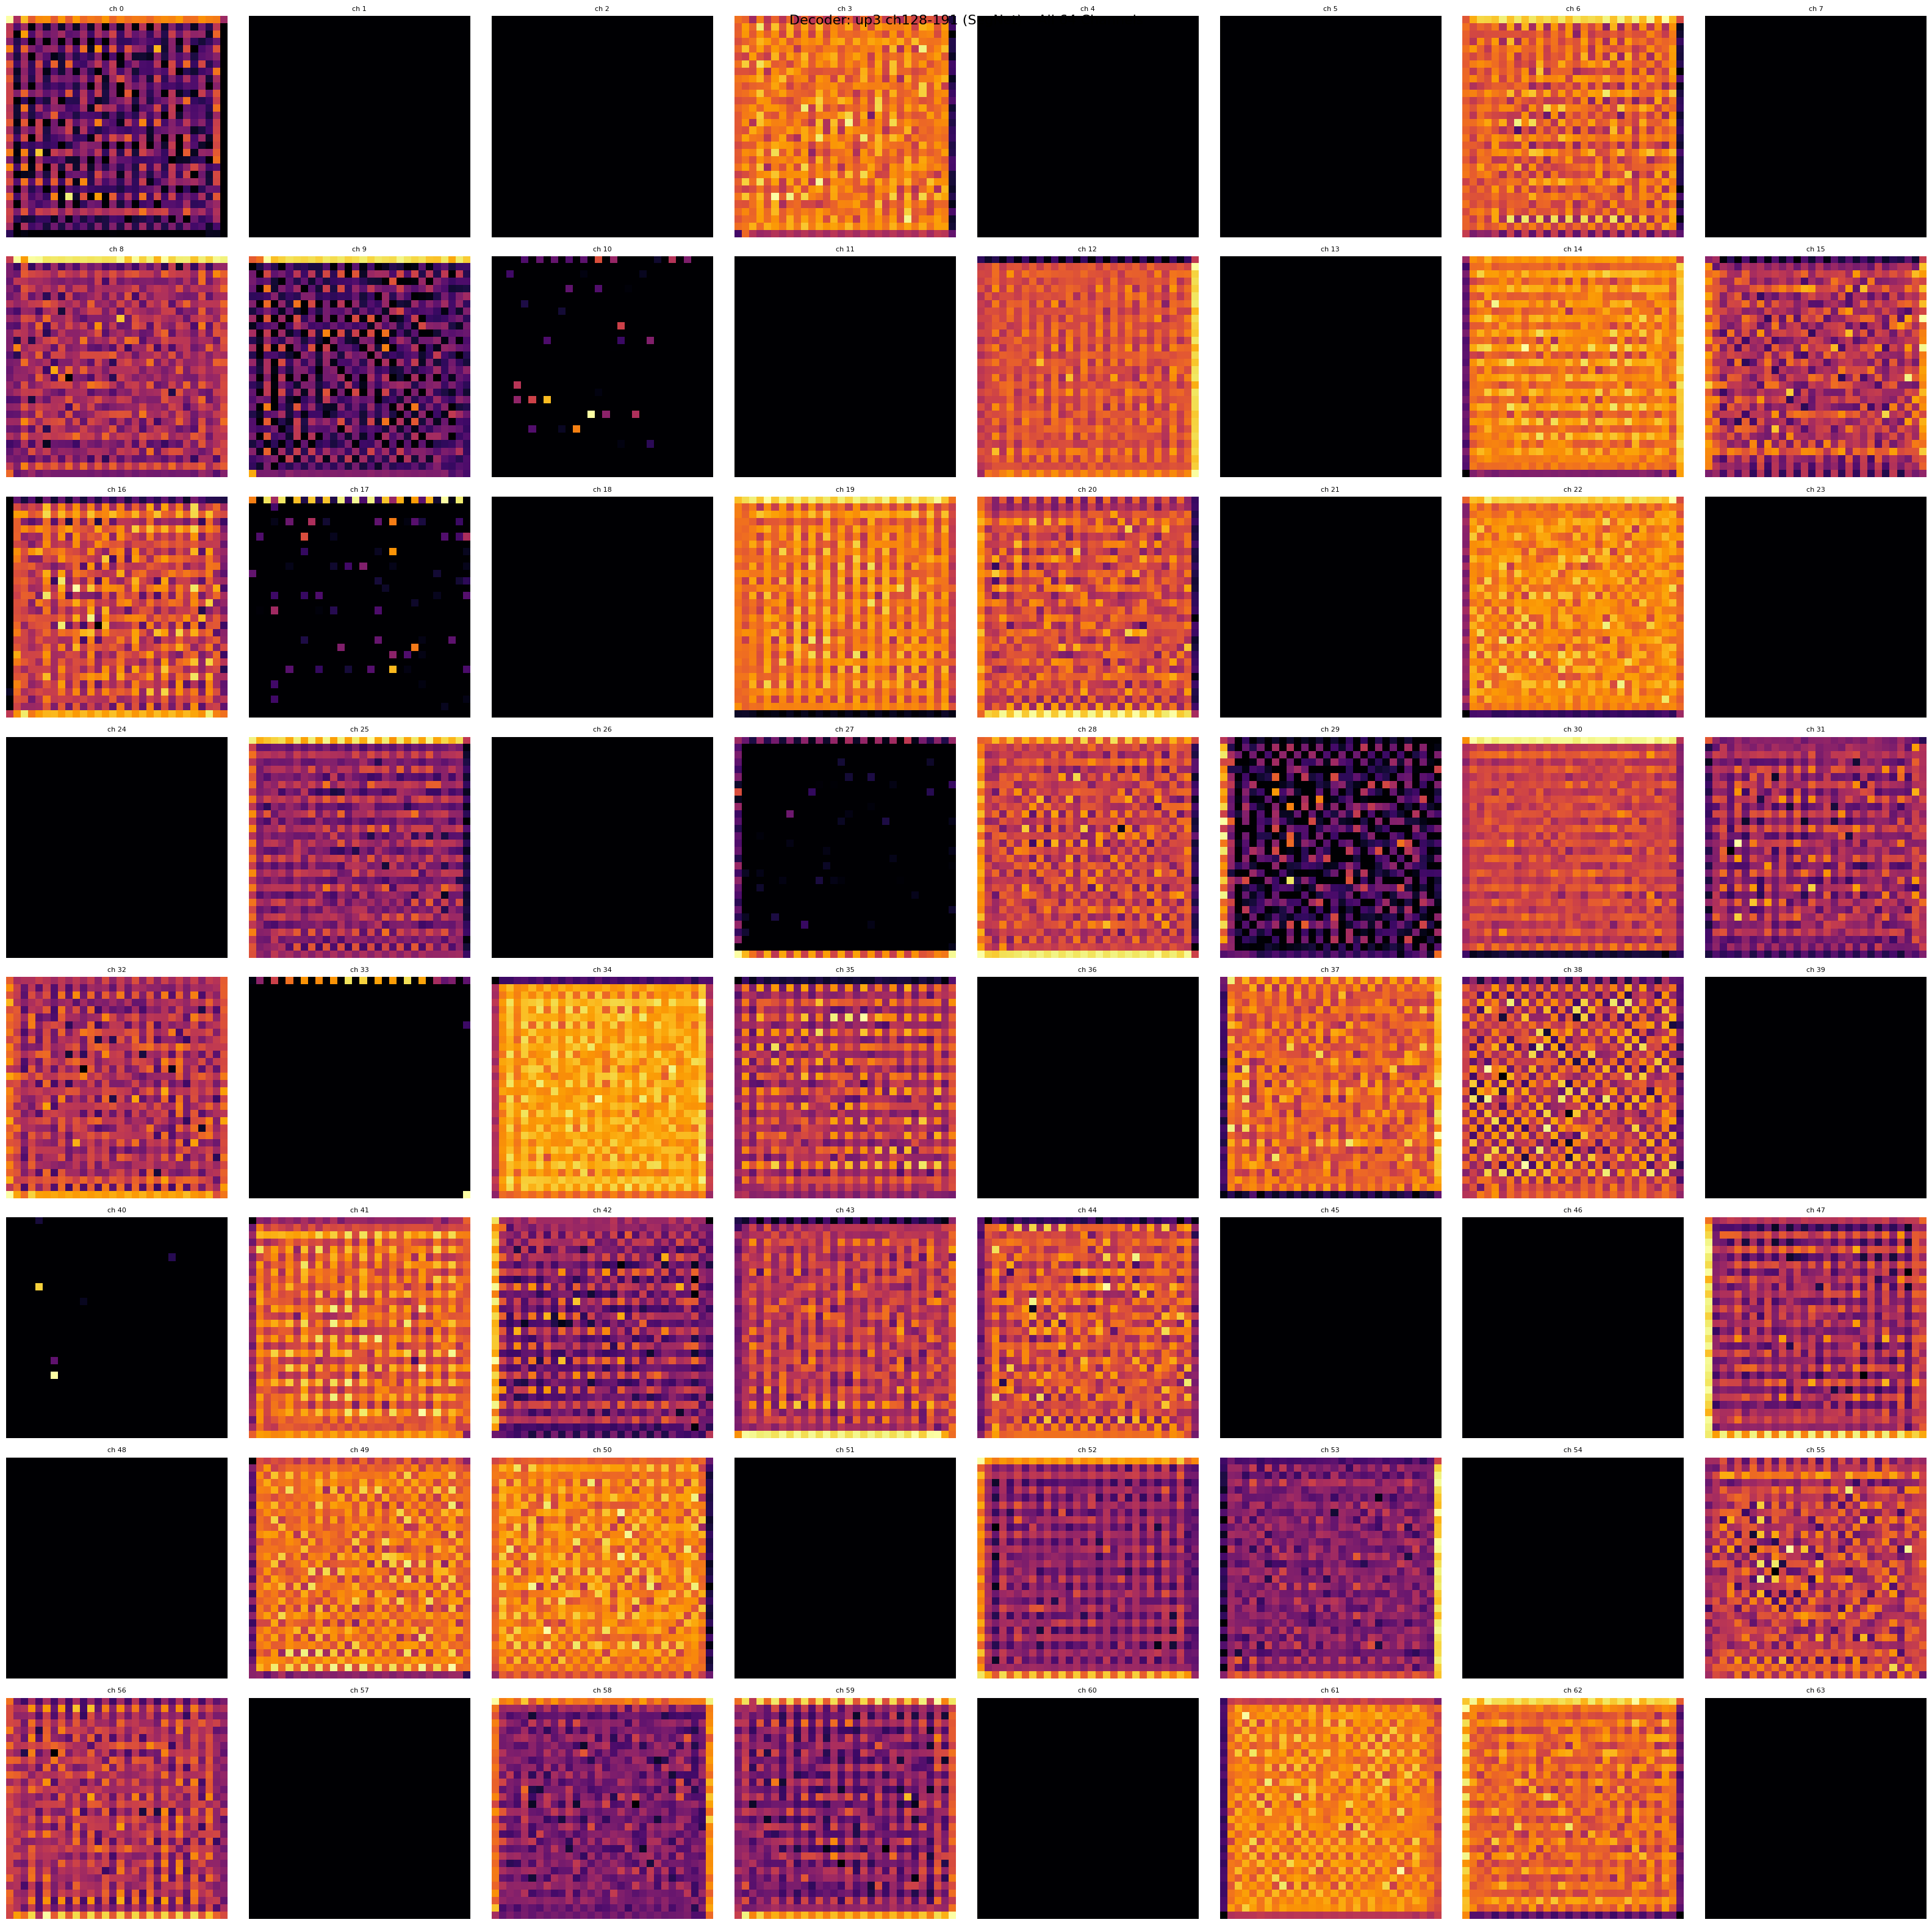

SegNet Decoder: up3: Channels 192–255


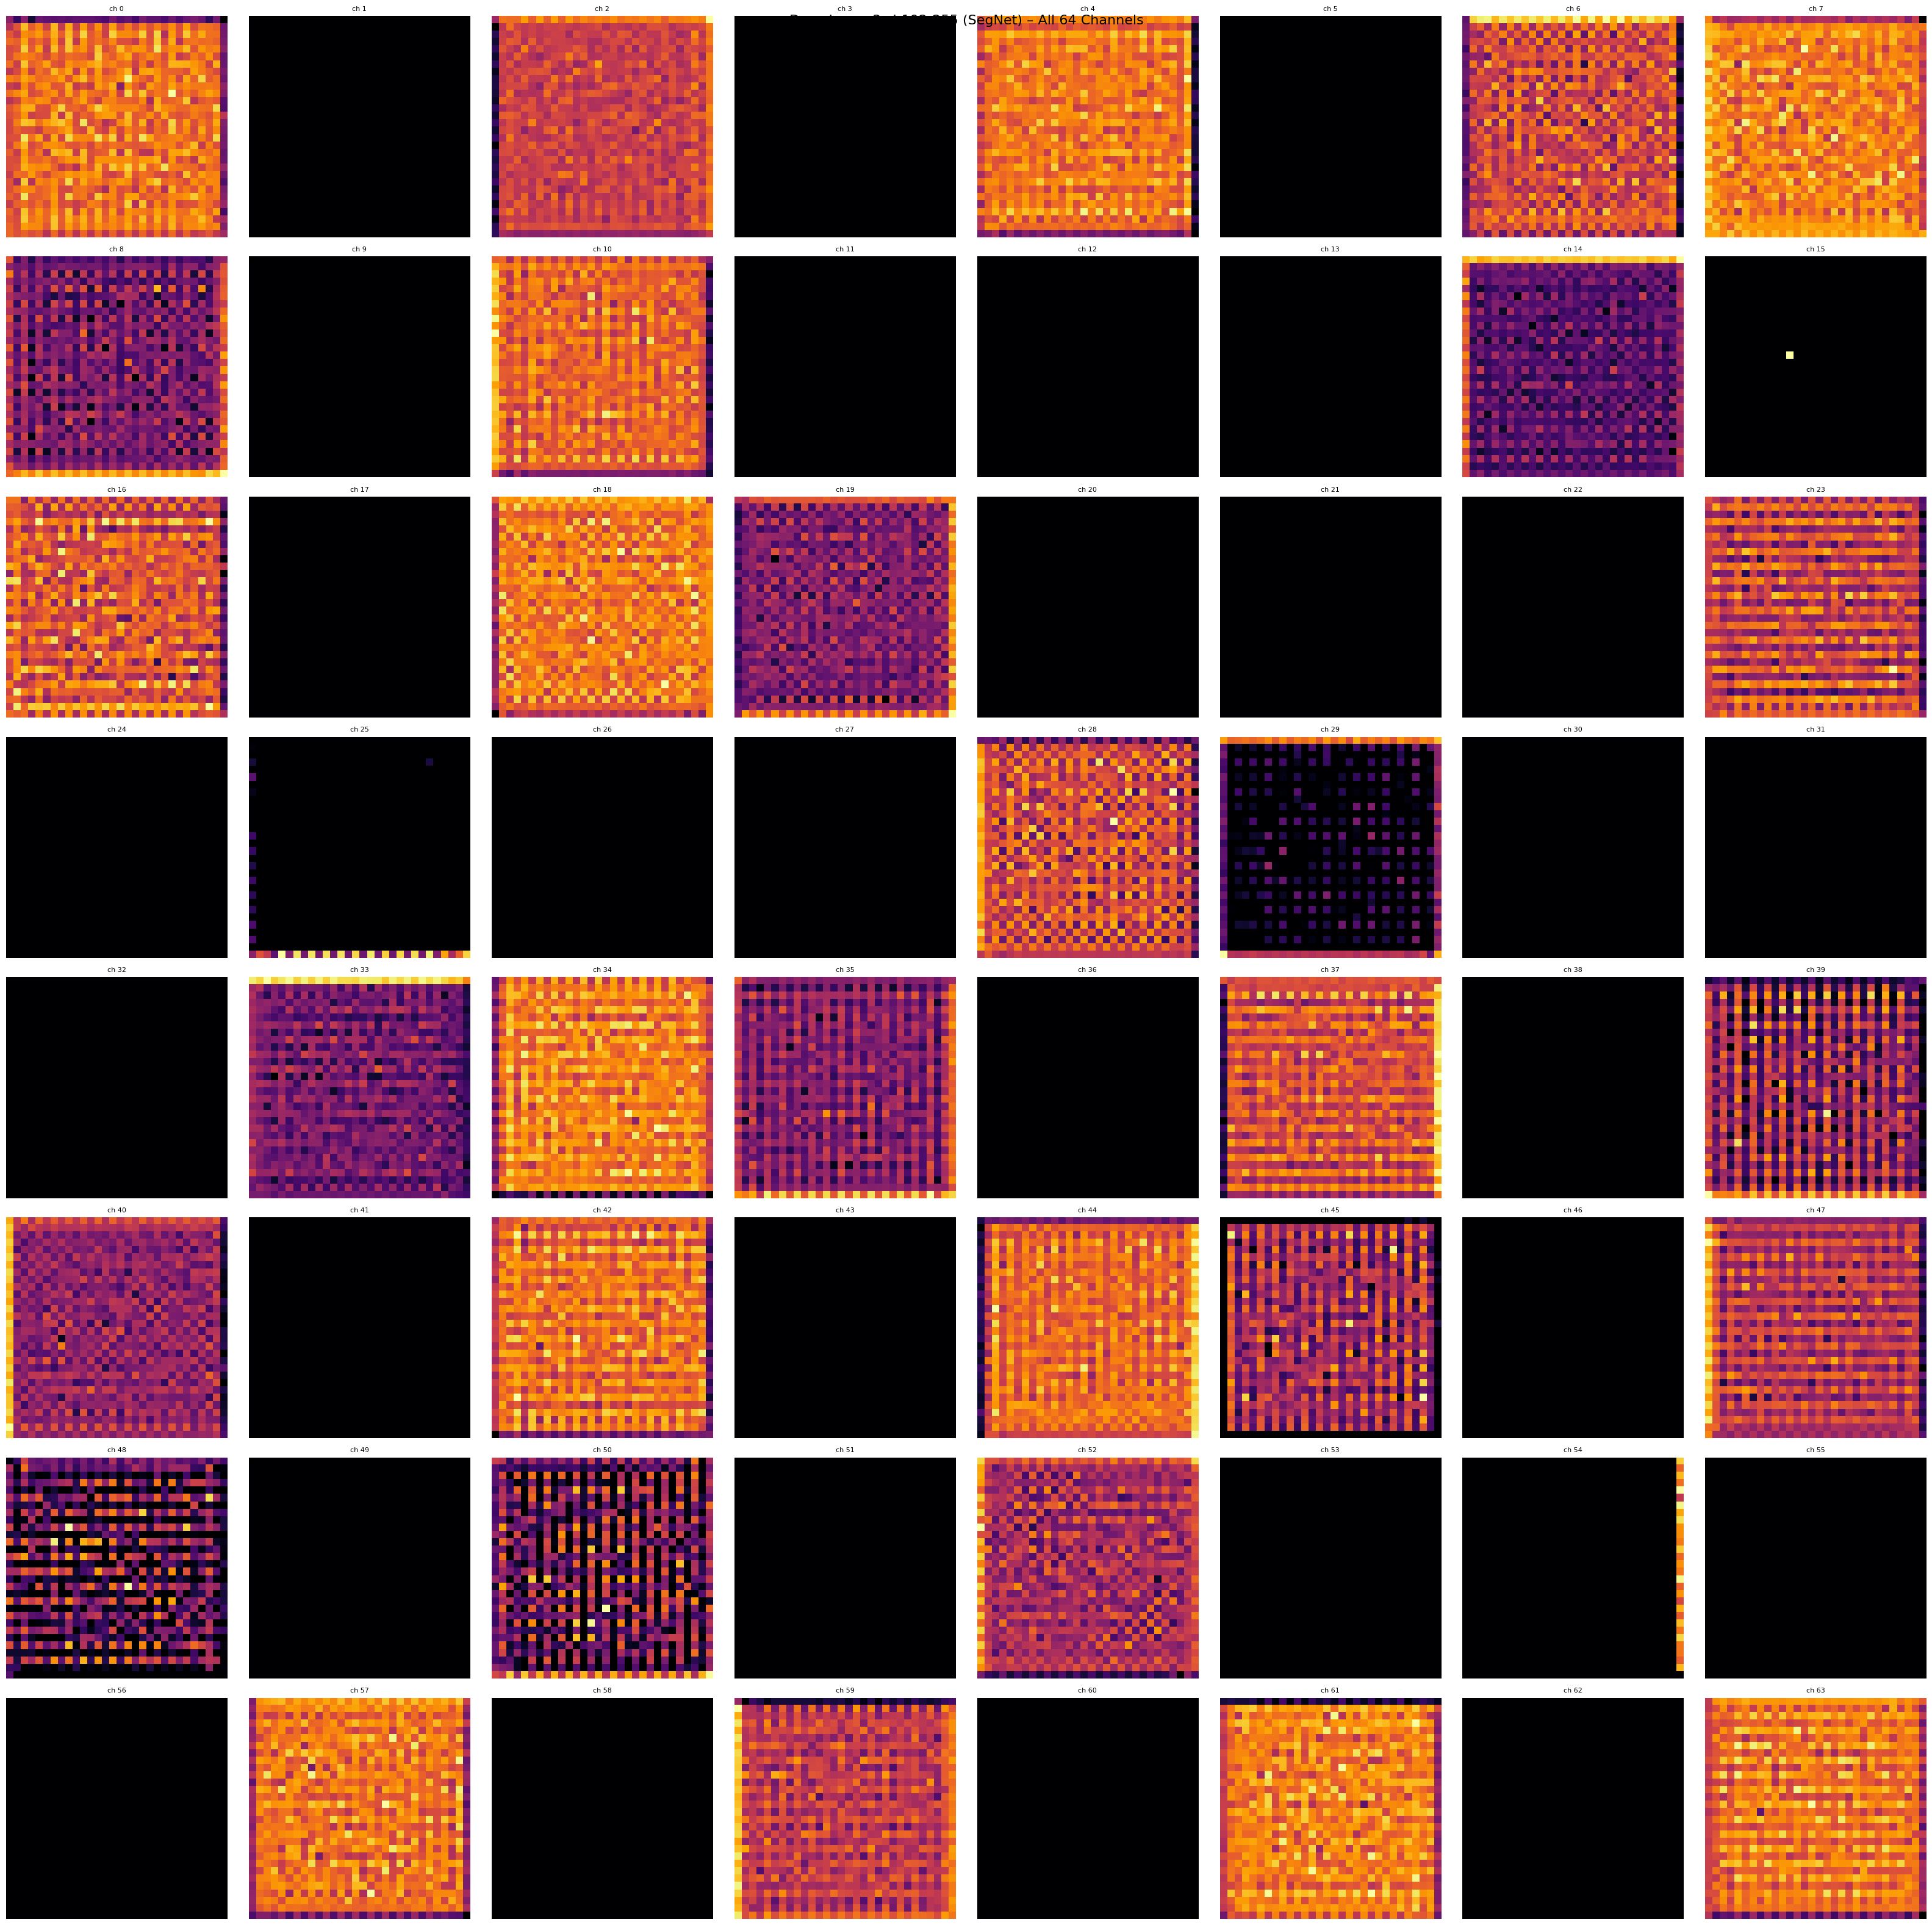

In [40]:
paginate_segnet_feature_maps(feats_idx['u3'], 'Decoder: up3')

SegNet Decoder: up2: Channels 0–63


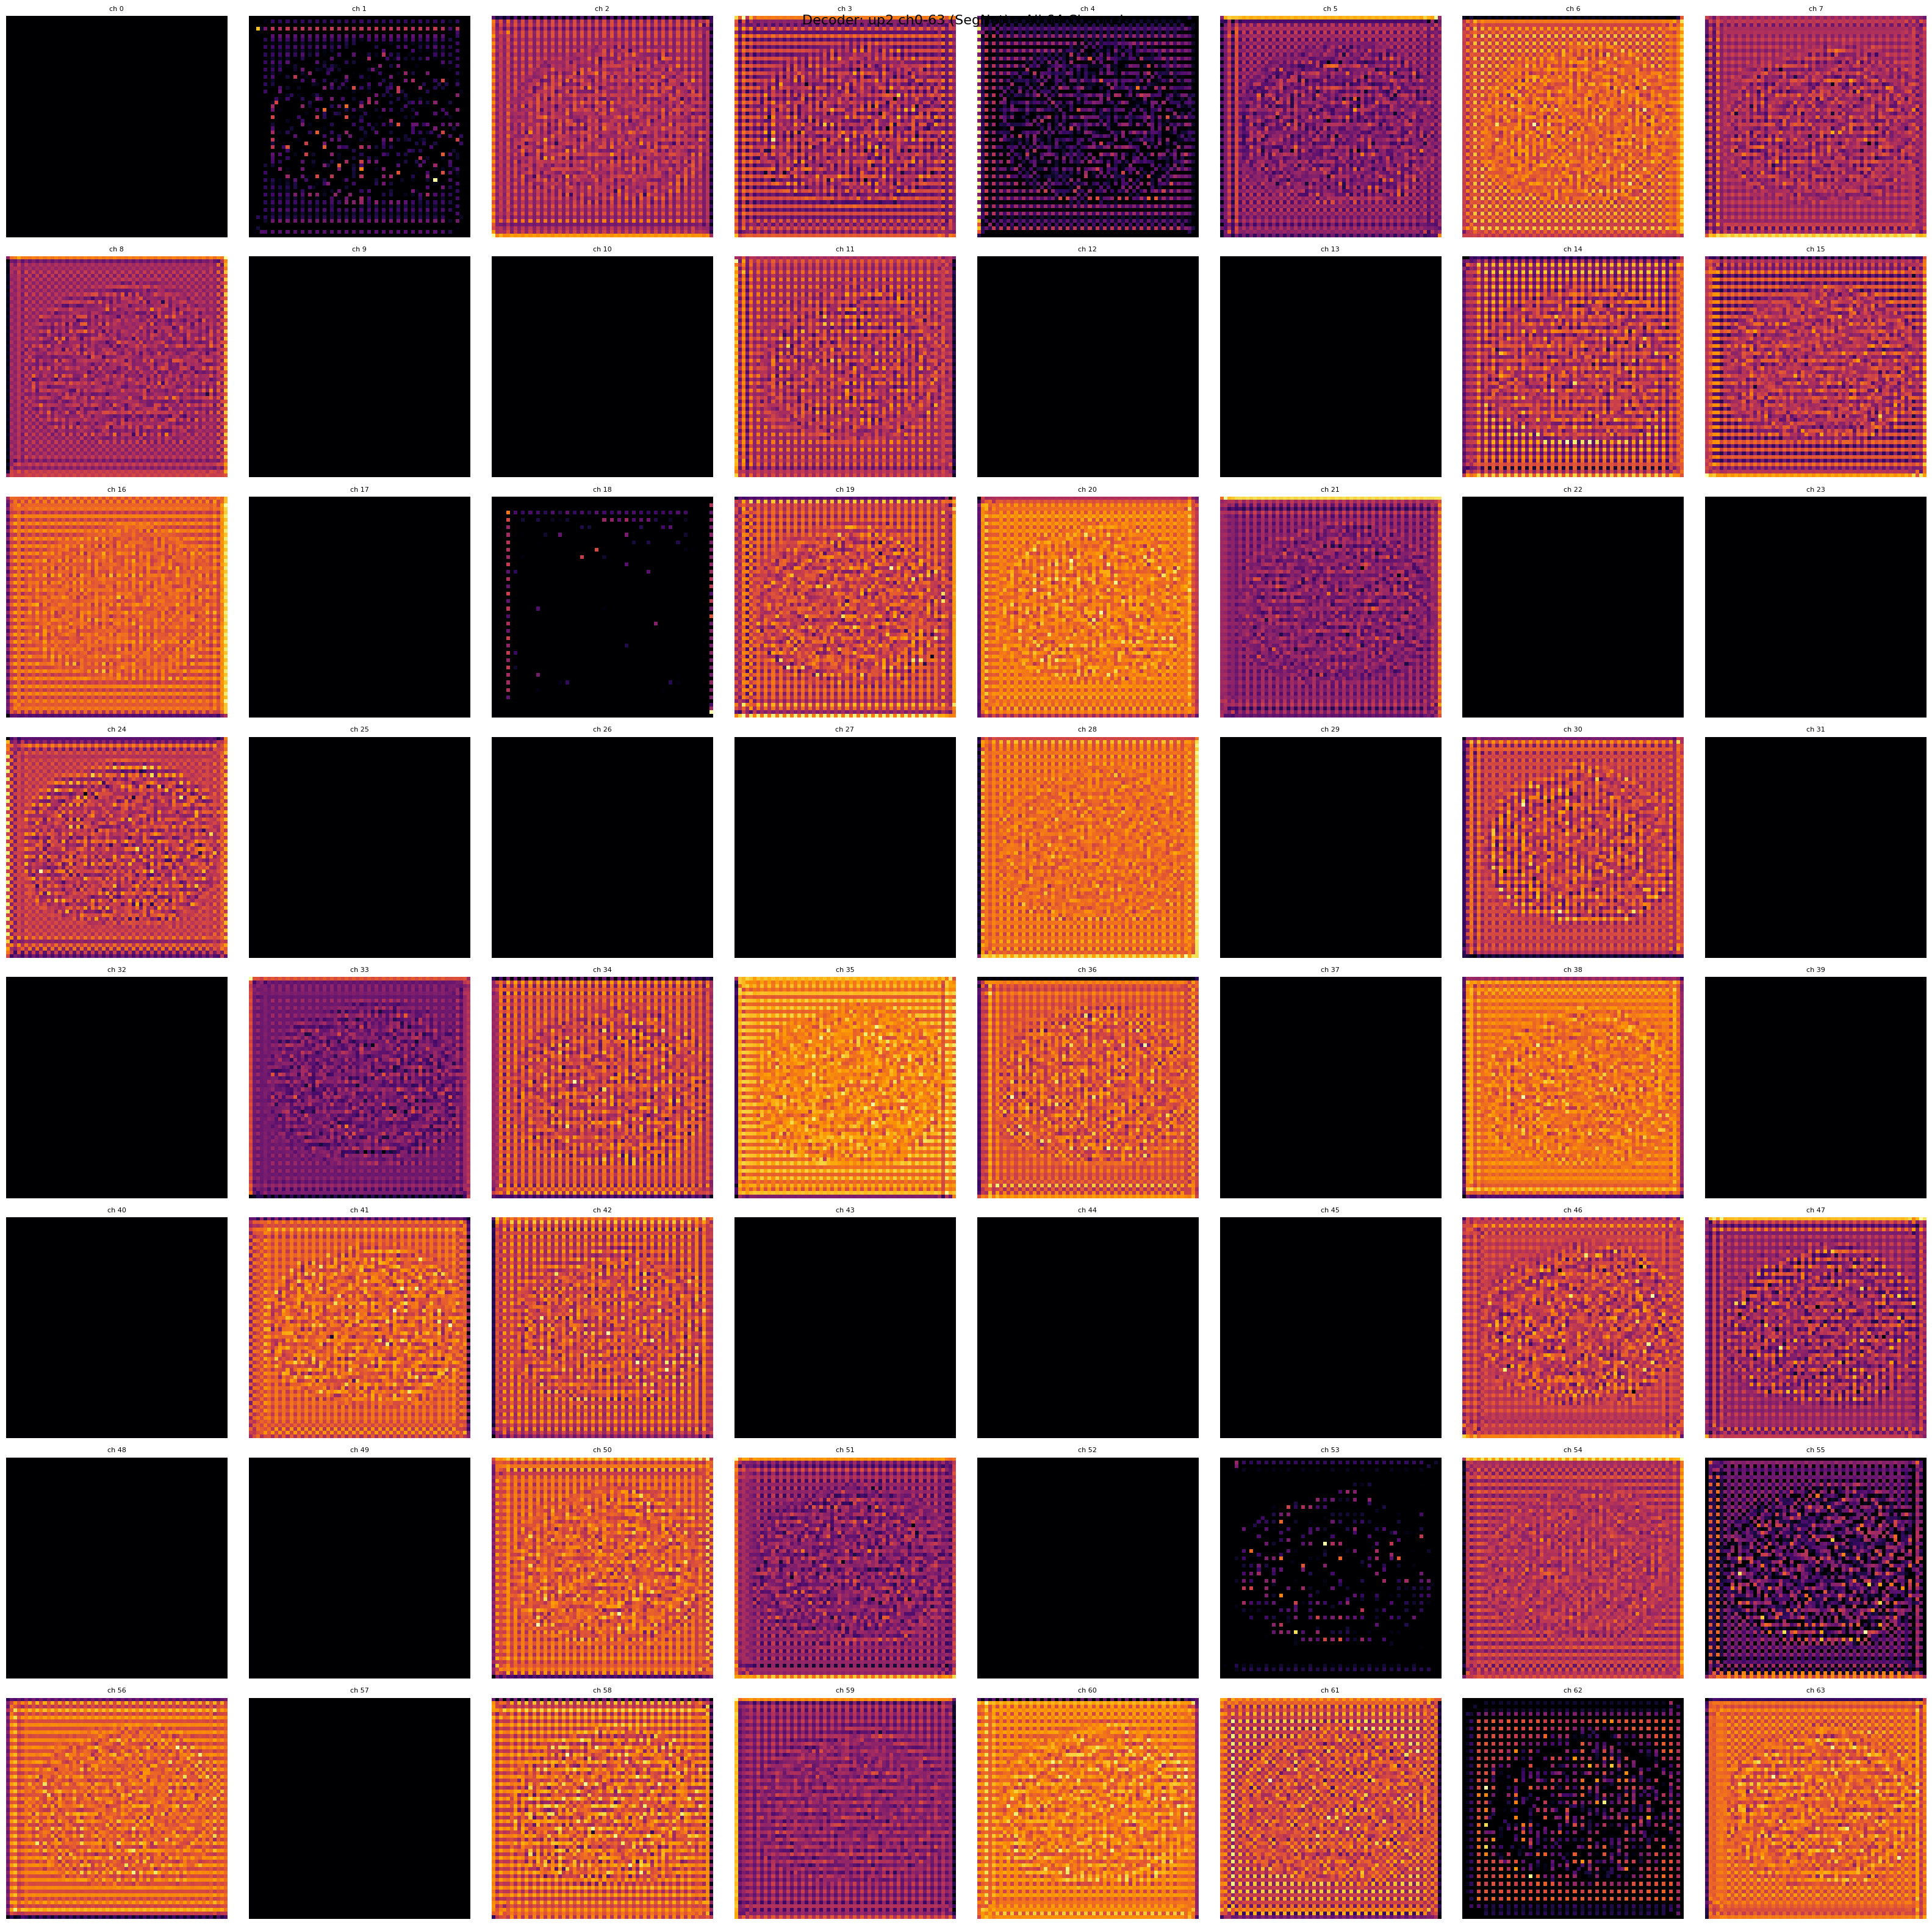

SegNet Decoder: up2: Channels 64–127


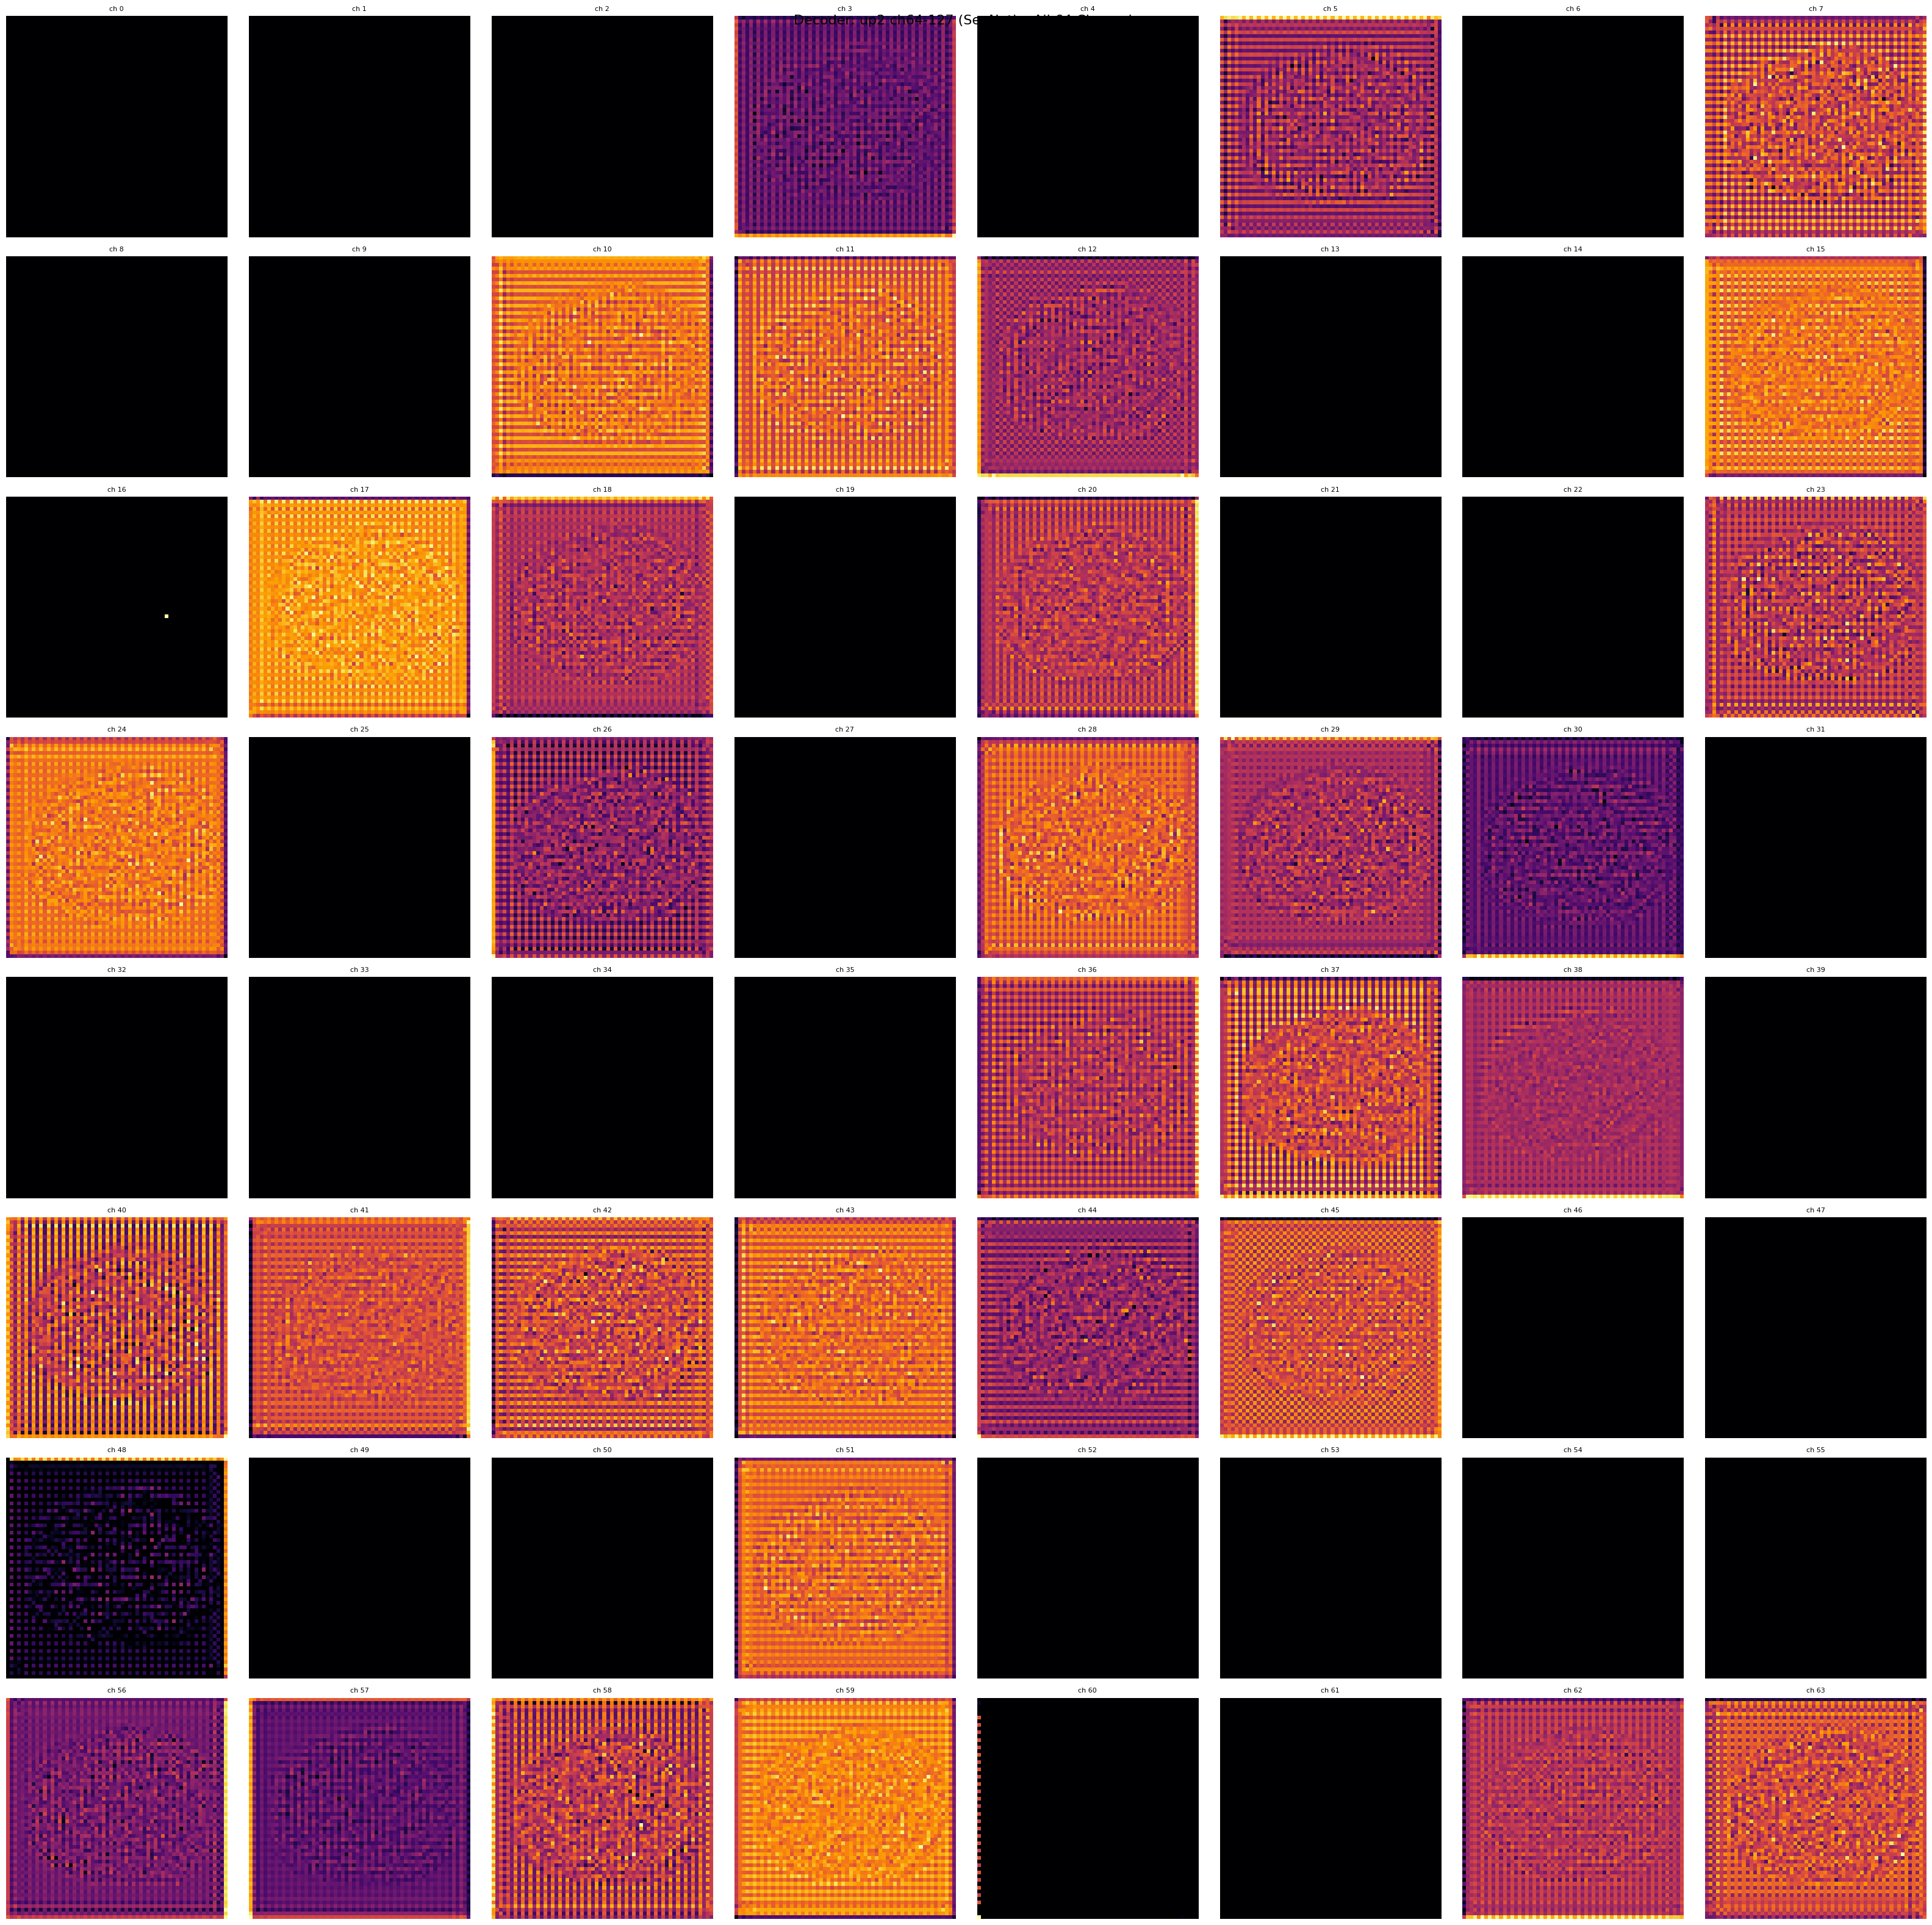

In [41]:
paginate_segnet_feature_maps(feats_idx['u2'], 'Decoder: up2')

SegNet Decoder: up1: Channels 0–63


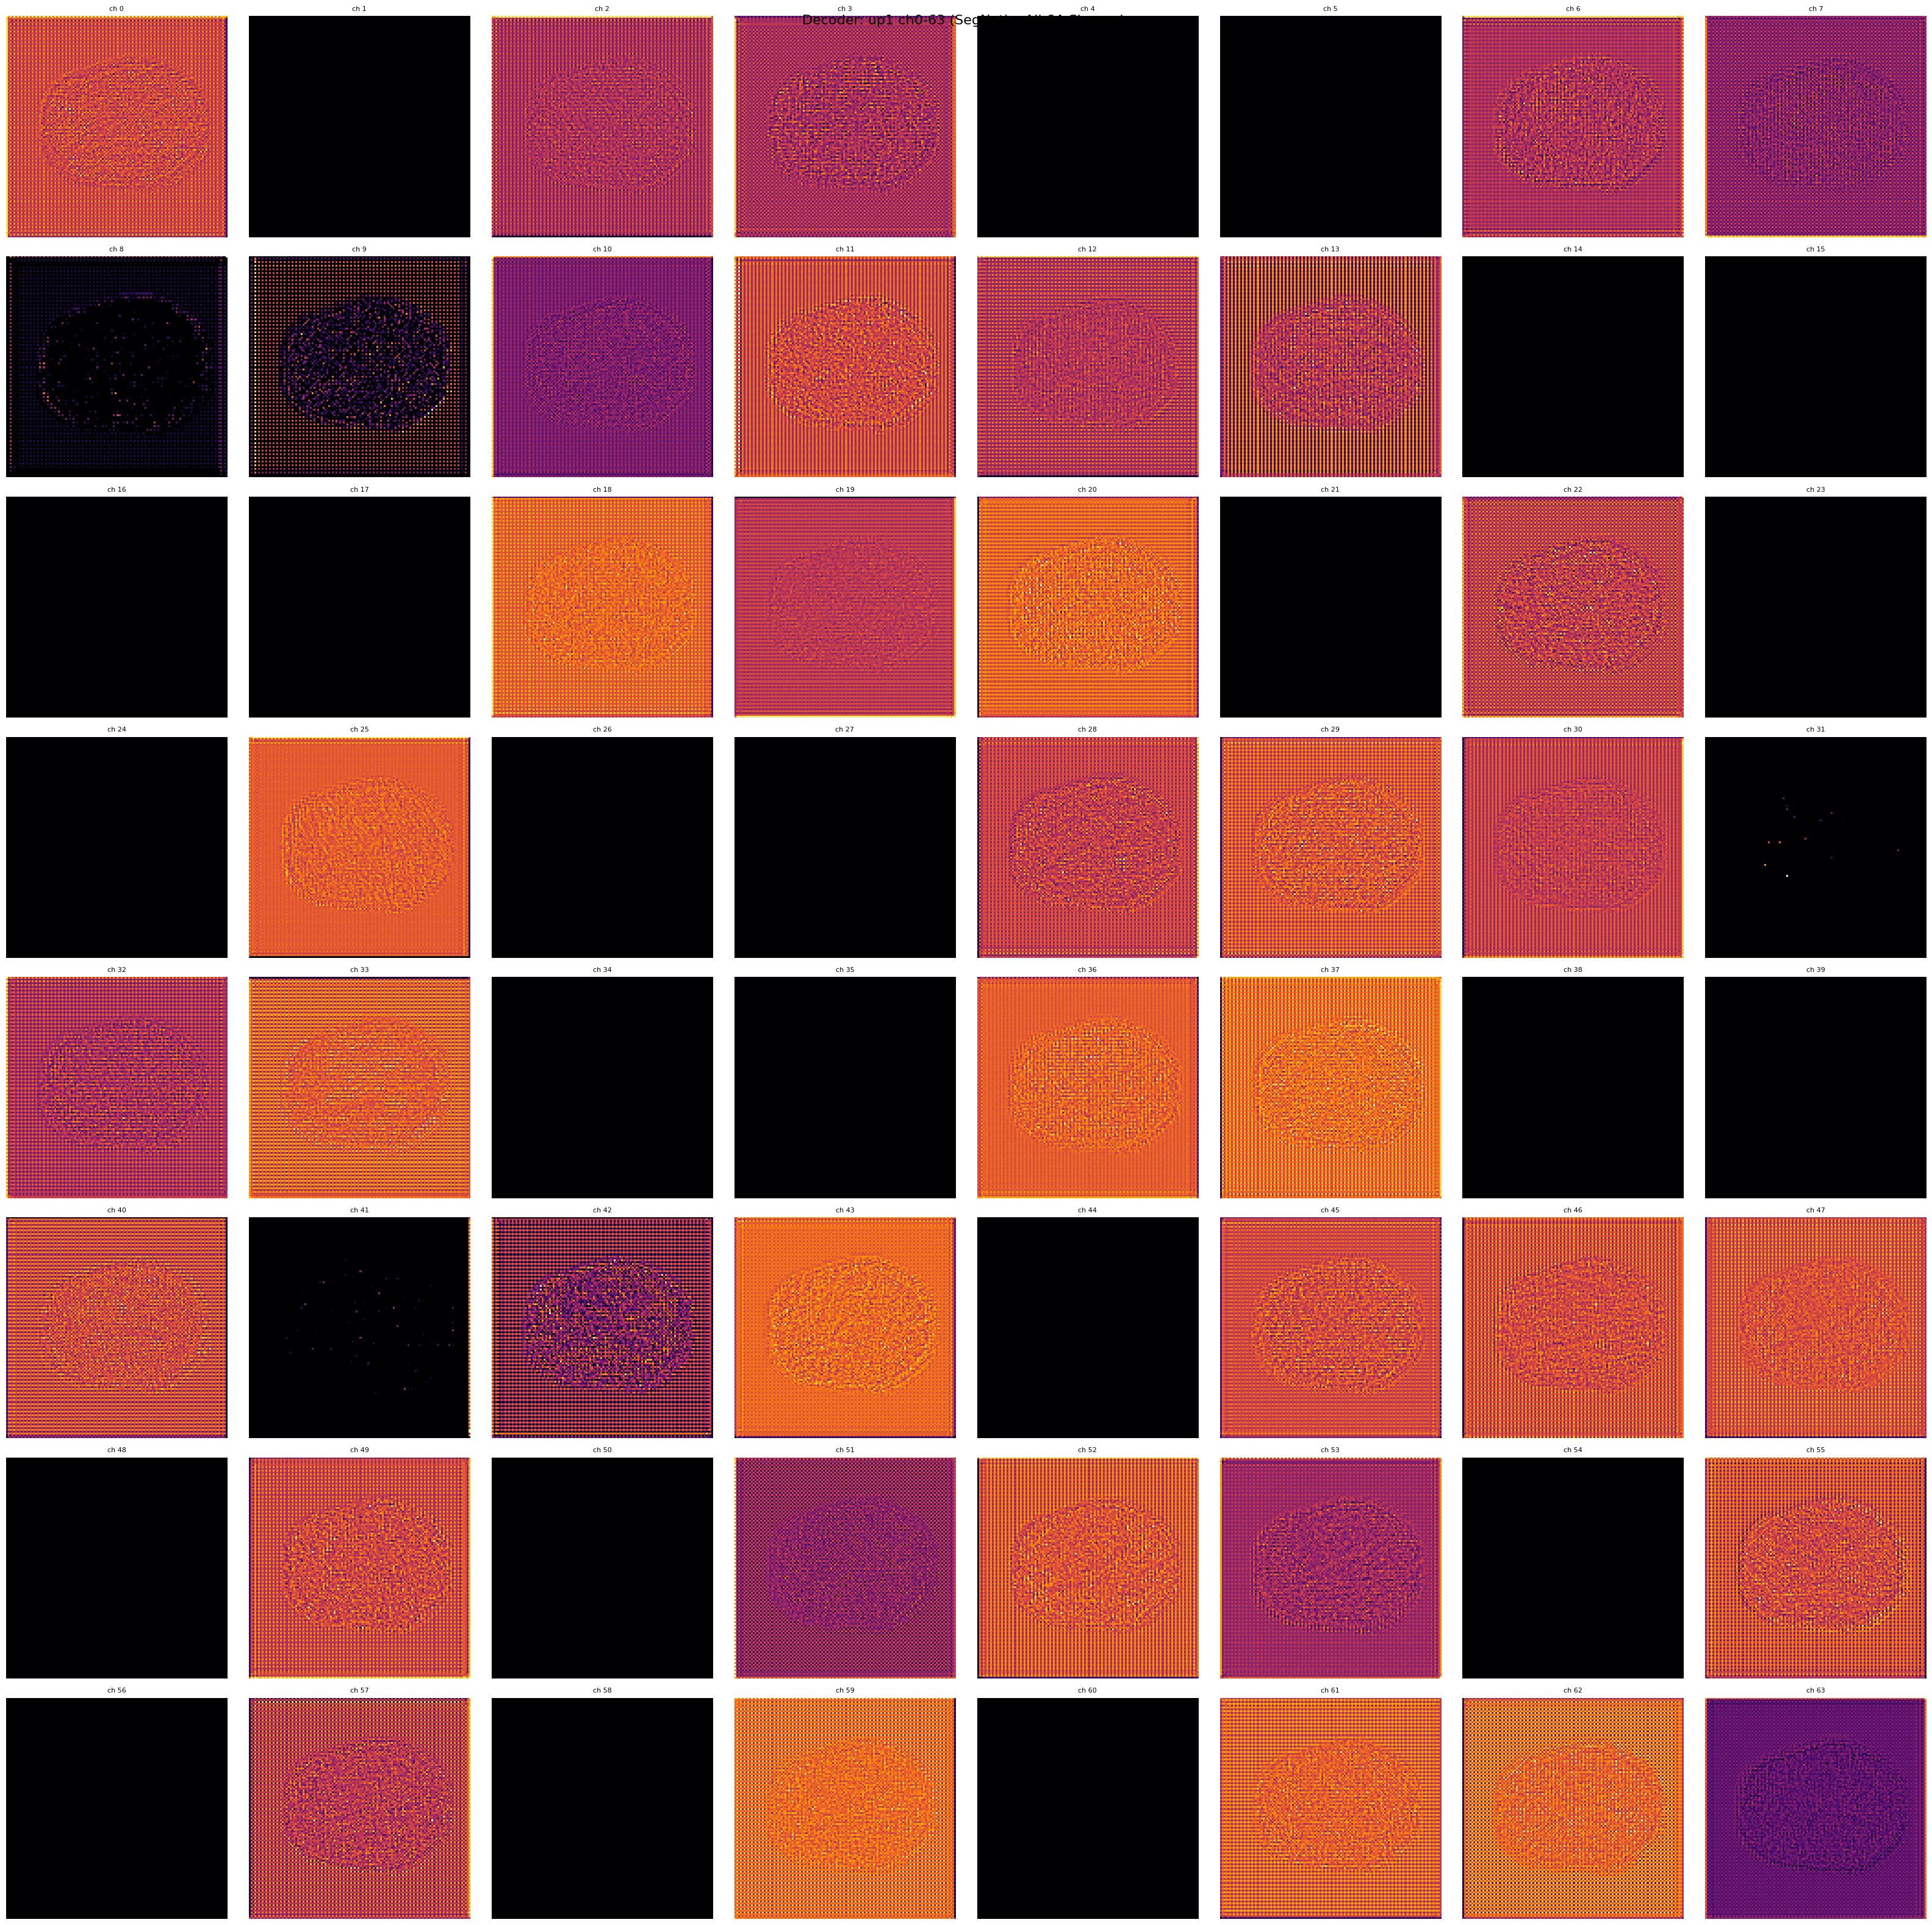

In [42]:
paginate_segnet_feature_maps(feats_idx['u1'], 'Decoder: up1')

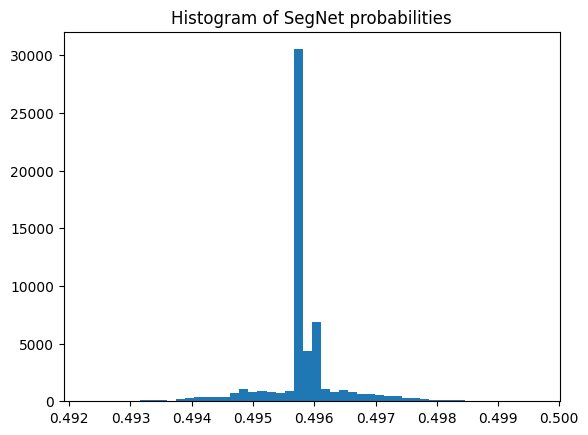

In [49]:
plt.hist(probs.flatten(), bins=50)
plt.title("Histogram of SegNet probabilities")
plt.show()


In [51]:
import torch.nn.functional as F
import torch
import numpy as np

def downsample_mask(mask_2d: np.ndarray, bottleneck_feat: torch.Tensor) -> np.ndarray:
    """
    Resize mask (H,W) to match bottleneck_feat spatial dimensions (h,w).
    Uses nearest-neighbor interpolation to preserve binary values.
    """
    _, _, h, w = bottleneck_feat.shape
    mask_t = torch.from_numpy(mask_2d.astype(np.float32))[None, None]  # shape [1,1,H,W]
    mask_resized = F.interpolate(mask_t, size=(h, w), mode="nearest")
    return mask_resized[0,0].cpu().numpy().astype(np.uint8)  # shape [h, w]
